In [ ]:
import json
import os
from dotenv import load_dotenv
from tqdm import tqdm
import re
import pandas as pd
from numpy import log10
import matplotlib.pyplot as plt
from langdetect import detect

import sentence_transformers

In [ ]:
load_dotenv()

In [ ]:
results_path = os.getenv('RESULTS')

In [ ]:
files = [f for f in os.listdir(results_path) if f.endswith('.jsonl') if 'summaries' in f]

In [ ]:
files

In [ ]:
# read jsonl

Summaries = []
for file in files:
    print(file)
    with open(os.path.join(results_path, file), 'r', encoding='utf-8') as f:
        Summaries.extend([json.loads(line) for line in f])

In [ ]:
# remove: chapter paragraph hoofdstuk paragraaf summary samenvatting 
re_replace = re.compile(r'\b(chapter|paragraph|hoofdstuk|paragraaf|summary|samenvatting)\b', re.IGNORECASE)
re_replace_m = re.compile(r'\s{2,}')
re_replace_t = re.compile(r'\t')

# initial words: english, dutch, engelse, nederlandse
re_replace_start = re.compile(r'^[\s\n\r]*(publications|references|english|dutch|engelse|nederlandse|appendix|appendices|dankwoord)\b', re.IGNORECASE)

Cleaned_Summaries = []
for summ in tqdm(Summaries):
    # use regex
    if summ['summary_dutch']:
        summ['summary_dutch'] = re_replace.sub('', summ['summary_dutch']).strip()
        summ['summary_dutch'] = re_replace_m.sub(' ', summ['summary_dutch'])
        summ['summary_dutch'] = re_replace_t.sub(' ', summ['summary_dutch'])
        summ['summary_dutch'] = re_replace_start.sub('', summ['summary_dutch']).strip()

        # remove all lines with less than <= 3 words
        summ['summary_dutch'] = '\n'.join([line for line in summ['summary_dutch'].split('\n') if len(line.split()) > 3])

    if summ['summary_english']:
        summ['summary_english'] = re_replace.sub('', summ['summary_english']).strip()
        summ['summary_english'] = re_replace_m.sub(' ', summ['summary_english'])
        summ['summary_english'] = re_replace_t.sub(' ', summ['summary_english'])
        summ['summary_english'] = re_replace_start.sub('', summ['summary_english']).strip()

        # remove all lines with less than <= 3 words
        summ['summary_english'] = '\n'.join([line for line in summ['summary_english'].split('\n') if len(line.split()) > 3])
    Cleaned_Summaries.append(summ)


In [ ]:
# Load multilingual model
model = sentence_transformers.SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [ ]:
Cleaned_Summaries[10]

In [ ]:
detect(Cleaned_Summaries[10]['summary_dutch'])

In [98]:
# summary english 
Paired = []
Dutch_Only = []
English_Only = []
failed=[]
for summ in tqdm(Cleaned_Summaries):
    # check if both summaries exist and have more than 25 words
    if 'summary_dutch' in summ and 'summary_english' in summ:
        dutch_len = len(summ['summary_dutch'].split()) if summ['summary_dutch'] else 0
        english_len = len(summ['summary_english'].split()) if summ['summary_english'] else 0

         # if both summaries have more than 25 words, compute similarity
         # if only one summary has more than 25 words, add to respective list

        # check if dutch summary is indeed dutch
        if dutch_len > 25:
            try:
                language = detect(summ['summary_dutch'])
            except Exception as e:
                print(f"Error detecting language for {summ['summary_dutch']}: {e}")
                continue
            if language != 'nl':
                #print(f"Detected language for Dutch summary in file {summ['file']} is not Dutch: {detect(summ['summary_dutch'])}")
                failed.append(summ['summary_dutch'])
        
        if (dutch_len> 25) and (english_len > 25):
            try:
                encs= model.encode([summ['summary_dutch'], summ['summary_english']])
                sim = sentence_transformers.util.cos_sim(encs[0], encs[1])
                Paired.append({
                    'id': summ['file'],
                    'institute': summ['institute'],
                    'summary_dutch': summ['summary_dutch'],
                    'summary_english': summ['summary_english'],
                    'dutch_len': dutch_len,
                    'english_len': english_len,
                    'similarity': float(sim[0][0])
                })
            except Exception as e:
                print(f"Error processing {summ['file']}: {e}")
                failed.append(summ['file'])
        else:
            print(f"Both summaries are less than 25 words or one is missing: {summ['file']}.")
            failed.append(summ['file'])

        
        if (dutch_len > 25) & (language == 'nl'):
            Dutch_Only.append({
                'id': summ['file'],
                'institute': summ['institute'],
                'summary_dutch': summ['summary_dutch'],
            })

        if english_len > 25:
            English_Only.append({
                'id': summ['file'],
                'institute': summ['institute'],
                'summary_english': summ['summary_english'],
            })

 13%|█▎        | 2032/15139 [03:18<17:15, 12.66it/s]

Both summaries are less than 25 words or one is missing: Leiden_HussaartsL_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_HuurmanVAL_2009_view.pdf.


 13%|█▎        | 2036/15139 [03:19<16:42, 13.07it/s]

Both summaries are less than 25 words or one is missing: Leiden_IJsselsteijnME_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_IbiD_2023_view.pdf.


 13%|█▎        | 2041/15139 [03:19<16:58, 12.86it/s]

Both summaries are less than 25 words or one is missing: Leiden_IendaltsevaO_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_IerselLvan_2011_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_IngenEvan_2022_view.pdf.


 14%|█▎        | 2044/15139 [03:19<14:13, 15.35it/s]

Both summaries are less than 25 words or one is missing: Leiden_InhetPanhuisW_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_InouyeM_2010_view.pdf.


 14%|█▎        | 2050/15139 [03:20<15:53, 13.73it/s]

Both summaries are less than 25 words or one is missing: Leiden_JLvanderPlas_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_Jaarsma-CoesMG_2023_view.pdf.


 14%|█▎        | 2052/15139 [03:20<14:45, 14.78it/s]

Both summaries are less than 25 words or one is missing: Leiden_JagerSCAde_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_JagtMAvander_2021_view.pdf.


 14%|█▎        | 2061/15139 [03:21<19:45, 11.03it/s]

Both summaries are less than 25 words or one is missing: Leiden_JansenWilhelminaMaria_2016_view.pdf.


 14%|█▎        | 2075/15139 [03:22<14:03, 15.49it/s]

Both summaries are less than 25 words or one is missing: Leiden_JeonY_2017_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_JiaY_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_JiangJ_2016_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_JiangM_2022_view.pdf.


 14%|█▎        | 2079/15139 [03:22<17:23, 12.52it/s]

Both summaries are less than 25 words or one is missing: Leiden_JongIEMde_2007_view.pdf.


 14%|█▍        | 2083/15139 [03:23<25:19,  8.59it/s]

Both summaries are less than 25 words or one is missing: Leiden_JongRCMde_2019_view.pdf.


 14%|█▍        | 2090/15139 [03:24<22:33,  9.64it/s]

Both summaries are less than 25 words or one is missing: Leiden_JongeMMde_2021_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_JongsmaMLM_2015_view.pdf.


 14%|█▍        | 2094/15139 [03:24<18:39, 11.65it/s]

Both summaries are less than 25 words or one is missing: Leiden_JonkerJT_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_Jorritsma-SmitA_2008_view.pdf.


 14%|█▍        | 2096/15139 [03:24<17:04, 12.73it/s]

Both summaries are less than 25 words or one is missing: Leiden_JoyceE_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_JurgensCK_2011_view.pdf.


 14%|█▍        | 2107/15139 [03:25<13:38, 15.91it/s]

Both summaries are less than 25 words or one is missing: Leiden_KakourouAA_2018_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KalkersK_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KalpoeJS_2007_view.pdf.


 14%|█▍        | 2111/15139 [03:25<14:08, 15.36it/s]

Both summaries are less than 25 words or one is missing: Leiden_KampJ_2021_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KamphorstJJ_2010_view.pdf.


 14%|█▍        | 2123/15139 [03:27<21:05, 10.29it/s]

Both summaries are less than 25 words or one is missing: Leiden_KapoerchanVV_2009_view.pdf.


 14%|█▍        | 2129/15139 [03:27<19:43, 10.99it/s]

Both summaries are less than 25 words or one is missing: Leiden_KarimR_2015_view.pdf.


 14%|█▍        | 2134/15139 [03:27<16:33, 13.09it/s]

Both summaries are less than 25 words or one is missing: Leiden_KarsM_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KarthausEG_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KazemS_2015_view.pdf.


 14%|█▍        | 2140/15139 [03:28<12:29, 17.34it/s]

Both summaries are less than 25 words or one is missing: Leiden_KefalasM_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KeijserS_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KelJM_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KeldermanS_2016_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KempV_2019_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KempersAC_2020_view.pdf.


 14%|█▍        | 2150/15139 [03:28<15:13, 14.22it/s]

Both summaries are less than 25 words or one is missing: Leiden_KesslerJ_2009_view.pdf.


 14%|█▍        | 2160/15139 [03:29<20:09, 10.73it/s]

Both summaries are less than 25 words or one is missing: Leiden_KisselT_2022_view.pdf.


 14%|█▍        | 2164/15139 [03:30<20:40, 10.46it/s]

Both summaries are less than 25 words or one is missing: Leiden_KlaauwAAvander_2008_view.pdf.


 14%|█▍        | 2168/15139 [03:30<20:16, 10.66it/s]

Both summaries are less than 25 words or one is missing: Leiden_KleijwegtFS_2015_view.pdf.


 14%|█▍        | 2182/15139 [03:32<21:55,  9.85it/s]

Both summaries are less than 25 words or one is missing: Leiden_KlopWMC_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KlumpersLE_2014_view.pdf.


 14%|█▍        | 2189/15139 [03:32<18:11, 11.86it/s]

Both summaries are less than 25 words or one is missing: Leiden_KoevoetsR_2014_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KokL_2023_view.pdf.


 14%|█▍        | 2193/15139 [03:33<18:49, 11.47it/s]

Both summaries are less than 25 words or one is missing: Leiden_KokshoornNE_2011_view.pdf.


 15%|█▍        | 2201/15139 [03:33<14:48, 14.57it/s]

Both summaries are less than 25 words or one is missing: Leiden_KoningMNCde_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KoningOHJ_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KooistraK_2007_view.pdf.


 15%|█▍        | 2207/15139 [03:34<17:08, 12.57it/s]

Both summaries are less than 25 words or one is missing: Leiden_KoopmanBC_2018_view.pdf.


 15%|█▍        | 2213/15139 [03:35<20:51, 10.33it/s]

Both summaries are less than 25 words or one is missing: Leiden_Koppers-LalićD_2007_view.pdf.


 15%|█▍        | 2219/15139 [03:35<17:05, 12.60it/s]

Both summaries are less than 25 words or one is missing: Leiden_KorndewalMarjolein_2017_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KorneCMde_2023_view.pdf.


 15%|█▍        | 2223/15139 [03:35<17:31, 12.28it/s]

Both summaries are less than 25 words or one is missing: Leiden_KortekaasKE_2021_view.pdf.


 15%|█▍        | 2227/15139 [03:36<19:28, 11.05it/s]

Both summaries are less than 25 words or one is missing: Leiden_KoudijsKKM_2023_view.pdf.


 15%|█▍        | 2231/15139 [03:36<20:54, 10.29it/s]

Both summaries are less than 25 words or one is missing: Leiden_KraanODE_2019_view.pdf.


 15%|█▍        | 2236/15139 [03:37<17:17, 12.43it/s]

Both summaries are less than 25 words or one is missing: Leiden_KralingenSvan_2011_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KramerCSM_2020_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KranenburgFJ_2023_view.pdf.


 15%|█▍        | 2248/15139 [03:38<18:20, 11.71it/s]

Both summaries are less than 25 words or one is missing: Leiden_KristyantoH_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KrogtJMvander_2018_view.pdf.


 15%|█▍        | 2254/15139 [03:38<17:47, 12.07it/s]

Both summaries are less than 25 words or one is missing: Leiden_KrouwelEM_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KruithofAC_2021_view.pdf.


 15%|█▍        | 2256/15139 [03:38<18:46, 11.44it/s]

Both summaries are less than 25 words or one is missing: Leiden_KruizingaMD_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KubbenFJGM_2007_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KuijjerML_2013_view.pdf.


 15%|█▌        | 2273/15139 [03:40<17:37, 12.16it/s]

Both summaries are less than 25 words or one is missing: Leiden_KurniawanF_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_KustersM_2009_view.pdf.


 15%|█▌        | 2277/15139 [03:40<19:16, 11.12it/s]

Both summaries are less than 25 words or one is missing: Leiden_KweekelDM_2009_view.pdf.


 15%|█▌        | 2285/15139 [03:41<14:08, 15.16it/s]

Both summaries are less than 25 words or one is missing: Leiden_LabraMuñozJA_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LaghmouchiA_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LagraauwHM_2015_view.pdf.


 15%|█▌        | 2287/15139 [03:41<14:50, 14.43it/s]

Both summaries are less than 25 words or one is missing: Leiden_LakemanIMM_2022_view.pdf.


 15%|█▌        | 2295/15139 [03:42<18:42, 11.44it/s]

Both summaries are less than 25 words or one is missing: Leiden_LammersB_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LangeJde_2012_view.pdf.


 15%|█▌        | 2297/15139 [03:42<18:43, 11.43it/s]

Both summaries are less than 25 words or one is missing: Leiden_LangersAMJ_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LangeveldeKvan_2012_view.pdf.


 15%|█▌        | 2303/15139 [03:42<15:30, 13.80it/s]

Both summaries are less than 25 words or one is missing: Leiden_LaporteK_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LauriaF_2022_view.pdf.


 15%|█▌        | 2308/15139 [03:43<14:56, 14.31it/s]

Both summaries are less than 25 words or one is missing: Leiden_LebrecJJP_2007_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LeeRAvander_2013_view.pdf.


 15%|█▌        | 2310/15139 [03:43<15:43, 13.60it/s]

Both summaries are less than 25 words or one is missing: Leiden_LeersumNJvan_2016_view.pdf.


 15%|█▌        | 2323/15139 [03:44<21:12, 10.07it/s]

Both summaries are less than 25 words or one is missing: Leiden_LestNAvande_2023_view.pdf.


 15%|█▌        | 2330/15139 [03:45<18:49, 11.34it/s]

Both summaries are less than 25 words or one is missing: Leiden_LiY_2016_view.pdf.


 15%|█▌        | 2338/15139 [03:46<18:42, 11.40it/s]

Both summaries are less than 25 words or one is missing: Leiden_LiberJM_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LiefaardC_2008_view.pdf.


 16%|█▌        | 2350/15139 [03:47<20:39, 10.32it/s]

Both summaries are less than 25 words or one is missing: Leiden_LingenEvan_2023_view.pdf.


 16%|█▌        | 2356/15139 [03:47<17:29, 12.18it/s]

Both summaries are less than 25 words or one is missing: Leiden_LipsEH_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LiuC_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_LiuF_2023_view.pdf.


 16%|█▌        | 2390/15139 [03:51<23:53,  8.89it/s]

Both summaries are less than 25 words or one is missing: Leiden_LuppinoFS_2015_view.pdf.


 16%|█▌        | 2396/15139 [03:52<23:06,  9.19it/s]

Both summaries are less than 25 words or one is missing: Leiden_MaasHJ_2007_view.pdf.


 16%|█▌        | 2410/15139 [03:54<22:48,  9.30it/s]

Both summaries are less than 25 words or one is missing: Leiden_MajowiczA_2014_view.pdf.


 16%|█▌        | 2419/15139 [03:55<19:53, 10.66it/s]

Both summaries are less than 25 words or one is missing: Leiden_MansLA_2018_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MantiE_2012_view.pdf.


 16%|█▌        | 2428/15139 [03:56<23:17,  9.09it/s]

Both summaries are less than 25 words or one is missing: Leiden_MartensLG_2023_view.pdf.


 16%|█▌        | 2434/15139 [03:57<22:39,  9.34it/s]

Both summaries are less than 25 words or one is missing: Leiden_MarvinDL_2023_view.pdf.


 16%|█▌        | 2439/15139 [03:57<21:03, 10.05it/s]

Both summaries are less than 25 words or one is missing: Leiden_MaulanaA_2018_view.pdf.


 16%|█▌        | 2441/15139 [03:58<20:15, 10.45it/s]

Both summaries are less than 25 words or one is missing: Leiden_MedinaRodriguezIA_2014_view.pdf.


 16%|█▌        | 2445/15139 [03:58<20:02, 10.56it/s]

Both summaries are less than 25 words or one is missing: Leiden_MeerLBvander_2015_view.pdf.


 16%|█▌        | 2451/15139 [03:58<18:49, 11.23it/s]

Both summaries are less than 25 words or one is missing: Leiden_MeessenJMTA_2019_view.pdf.


 16%|█▌        | 2457/15139 [03:59<15:19, 13.79it/s]

Both summaries are less than 25 words or one is missing: Leiden_MeijerFMM_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MeijerHNJ_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MeijerMJW_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MeirHvan_2017_view.pdf.


 16%|█▋        | 2463/15139 [03:59<15:42, 13.45it/s]

Both summaries are less than 25 words or one is missing: Leiden_MelisJ_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MelssenMM_2021_view.pdf.


 16%|█▋        | 2467/15139 [03:59<12:42, 16.63it/s]

Both summaries are less than 25 words or one is missing: Leiden_MenkeLA_2010_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MerensW_2007_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MerkelbachI_2018_view.pdf.


 16%|█▋        | 2471/15139 [04:00<13:45, 15.34it/s]

Both summaries are less than 25 words or one is missing: Leiden_MeskerWE_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MesmanRLS_2020_view.pdf.


 16%|█▋        | 2473/15139 [04:00<14:21, 14.69it/s]

Both summaries are less than 25 words or one is missing: Leiden_MeursI_2011_view.pdf.


 16%|█▋        | 2479/15139 [04:00<17:40, 11.93it/s]

Both summaries are less than 25 words or one is missing: Leiden_MiahIP_2022_view.pdf.


 16%|█▋        | 2486/15139 [04:01<21:57,  9.60it/s]

Both summaries are less than 25 words or one is missing: Leiden_MildnerM_2013_view.pdf.


 16%|█▋        | 2494/15139 [04:02<21:18,  9.89it/s]

Both summaries are less than 25 words or one is missing: Leiden_MochelJP_2015_view.pdf.


 16%|█▋        | 2496/15139 [04:02<18:54, 11.14it/s]

Both summaries are less than 25 words or one is missing: Leiden_MoerkampAT_2018_view.pdf.


 17%|█▋        | 2512/15139 [04:04<16:56, 12.43it/s]

Both summaries are less than 25 words or one is missing: Leiden_MontfortsMHMM_2005_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MoonenJEF_2017_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MooyaartAL_2011_view.pdf.


 17%|█▋        | 2516/15139 [04:04<14:59, 14.04it/s]

Both summaries are less than 25 words or one is missing: Leiden_MoreiraMarquesM_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_MorraAGT_2023_view.pdf.


 17%|█▋        | 2524/15139 [04:05<17:48, 11.81it/s]

Both summaries are less than 25 words or one is missing: Leiden_MouritsEVM_2016_view.pdf.


 17%|█▋        | 2532/15139 [04:06<20:38, 10.18it/s]

Both summaries are less than 25 words or one is missing: Leiden_MuskensIS_2021_view.pdf.


 17%|█▋        | 2539/15139 [04:07<21:02,  9.98it/s]

Both summaries are less than 25 words or one is missing: Leiden_NahonJE_2018_view.pdf.


 17%|█▋        | 2547/15139 [04:08<17:56, 11.70it/s]

Both summaries are less than 25 words or one is missing: Leiden_NefsSV_2013_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_NesJGHvan_2014_view.pdf.


 17%|█▋        | 2553/15139 [04:08<16:27, 12.75it/s]

Both summaries are less than 25 words or one is missing: Leiden_NicolaiMPJ_2014_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_NicolaieMA_2014_view.pdf.


 17%|█▋        | 2557/15139 [04:08<17:38, 11.88it/s]

Both summaries are less than 25 words or one is missing: Leiden_NiemeijerMC_2023_view.pdf.


 17%|█▋        | 2561/15139 [04:09<19:19, 10.85it/s]

Both summaries are less than 25 words or one is missing: Leiden_NieuwenhuisWP_2018_view.pdf.


 17%|█▋        | 2566/15139 [04:09<16:43, 12.53it/s]

Both summaries are less than 25 words or one is missing: Leiden_NiksEH_2013_view.pdf.


 17%|█▋        | 2568/15139 [04:09<17:46, 11.79it/s]

Both summaries are less than 25 words or one is missing: Leiden_NooijerRamonde_2005_view.pdf.


 17%|█▋        | 2578/15139 [04:11<20:40, 10.13it/s]

Both summaries are less than 25 words or one is missing: Leiden_NémethB_2020_view.pdf.


 17%|█▋        | 2584/15139 [04:11<19:16, 10.86it/s]

Both summaries are less than 25 words or one is missing: Leiden_OeverJessicaMariaElisabethvanden_2016_view.pdf.


 17%|█▋        | 2586/15139 [04:11<18:44, 11.17it/s]

Both summaries are less than 25 words or one is missing: Leiden_OkkerseP_2018_view.pdf.


 17%|█▋        | 2595/15139 [04:12<19:20, 10.81it/s]

Both summaries are less than 25 words or one is missing: Leiden_OostenLEM_2007_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_OosterhoutMvan_2008_view.pdf.


 17%|█▋        | 2600/15139 [04:13<19:46, 10.57it/s]

Both summaries are less than 25 words or one is missing: Leiden_OpdamFL_2015_view.pdf.


 17%|█▋        | 2609/15139 [04:14<16:43, 12.48it/s]

Both summaries are less than 25 words or one is missing: Leiden_OsingaN_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_OssowickiAS_2021_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_OuahoudS_2022_view.pdf.


 17%|█▋        | 2615/15139 [04:14<13:27, 15.51it/s]

Both summaries are less than 25 words or one is missing: Leiden_OuweneelAB_2019_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_OverbergRI_2013_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_OverveldPGMvan_2005_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PacheMJ_2018_view.pdf.


 17%|█▋        | 2629/15139 [04:15<22:26,  9.29it/s]

Both summaries are less than 25 words or one is missing: Leiden_PansuriyaTC_2012_view.pdf.


 17%|█▋        | 2632/15139 [04:16<23:04,  9.03it/s]

Both summaries are less than 25 words or one is missing: Leiden_PardiDJ_2019_view.pdf.


 17%|█▋        | 2641/15139 [04:17<22:06,  9.42it/s]

Both summaries are less than 25 words or one is missing: Leiden_PeerJMvan_2009_view.pdf.


 17%|█▋        | 2645/15139 [04:17<21:07,  9.85it/s]

Both summaries are less than 25 words or one is missing: Leiden_PeetersMYM_2007_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PeironcelyMiguelJE_2014_view.pdf.


 18%|█▊        | 2651/15139 [04:18<18:36, 11.18it/s]

Both summaries are less than 25 words or one is missing: Leiden_PelzerN_2018_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PenningsM_2008_view.pdf.


 18%|█▊        | 2653/15139 [04:18<17:22, 11.98it/s]

Both summaries are less than 25 words or one is missing: Leiden_PeppelRJvande_2021_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PerrinPC_2022_view.pdf.


 18%|█▊        | 2659/15139 [04:19<20:44, 10.02it/s]

Both summaries are less than 25 words or one is missing: Leiden_PetersEEM_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PetersSHP_2015_view.pdf.


 18%|█▊        | 2669/15139 [04:20<20:03, 10.36it/s]

Both summaries are less than 25 words or one is missing: Leiden_PianaC_2013_view.pdf.


 18%|█▊        | 2673/15139 [04:20<17:48, 11.66it/s]

Both summaries are less than 25 words or one is missing: Leiden_PieperS_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PiersmaSJ_2010_view.pdf.


 18%|█▊        | 2684/15139 [04:21<17:26, 11.90it/s]

Both summaries are less than 25 words or one is missing: Leiden_PlantagieL_2017_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PlasAAvander_2013_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PlasMCEvander_2023_view.pdf.


 18%|█▊        | 2690/15139 [04:22<21:21,  9.72it/s]

Both summaries are less than 25 words or one is missing: Leiden_PoelgeestEPvan_2018_view.pdf.


 18%|█▊        | 2696/15139 [04:22<15:34, 13.32it/s]

Both summaries are less than 25 words or one is missing: Leiden_PolTMvander_2018_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PolVvande_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PoldermanAM_1975_view.pdf.


 18%|█▊        | 2708/15139 [04:23<14:49, 13.98it/s]

Both summaries are less than 25 words or one is missing: Leiden_PostCCB_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PostJvander_2006_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PostTM_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PostmusI_2015_view.pdf.


 18%|█▊        | 2712/15139 [04:23<15:23, 13.46it/s]

Both summaries are less than 25 words or one is missing: Leiden_PouwerMG_2020_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PradhanB_2018_view.pdf.


 18%|█▊        | 2717/15139 [04:24<13:31, 15.30it/s]

Both summaries are less than 25 words or one is missing: Leiden_PratumchaiI_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_PreciatGonzalezGA_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_ProchazkovaE_2021_view.pdf.


 18%|█▊        | 2721/15139 [04:24<16:48, 12.31it/s]

Both summaries are less than 25 words or one is missing: Leiden_PuntBS_2015_view.pdf.


 18%|█▊        | 2727/15139 [04:25<17:25, 11.88it/s]

Both summaries are less than 25 words or one is missing: Leiden_QiaoY_2017_view.pdf.


 18%|█▊        | 2729/15139 [04:25<17:05, 12.11it/s]

Both summaries are less than 25 words or one is missing: Leiden_Quispel-JanssenJMMF_2020_view.pdf.


 18%|█▊        | 2735/15139 [04:25<17:54, 11.54it/s]

Both summaries are less than 25 words or one is missing: Leiden_RadM_2015_view.pdf.


 18%|█▊        | 2741/15139 [04:26<14:47, 13.97it/s]

Both summaries are less than 25 words or one is missing: Leiden_RamosYFM_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_Rampersad-KhedoePPSJ_2017_view.pdf.


 18%|█▊        | 2746/15139 [04:26<17:40, 11.69it/s]

Both summaries are less than 25 words or one is missing: Leiden_RastiS_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_RaterinkRJ_2014_view.pdf.


 18%|█▊        | 2754/15139 [04:27<18:13, 11.33it/s]

Both summaries are less than 25 words or one is missing: Leiden_RazzaqL_2011_view.pdf.


 18%|█▊        | 2766/15139 [04:29<30:53,  6.67it/s]

Both summaries are less than 25 words or one is missing: Leiden_RekersNV_2014_view.pdf.


 18%|█▊        | 2782/15139 [04:31<22:23,  9.20it/s]

Both summaries are less than 25 words or one is missing: Leiden_Rijn-KlinkALvan_2020_view.pdf.


 18%|█▊        | 2788/15139 [04:31<20:57,  9.82it/s]

Both summaries are less than 25 words or one is missing: Leiden_RiusOttenheimN_2012_view.pdf.


 18%|█▊        | 2796/15139 [04:32<16:06, 12.78it/s]

Both summaries are less than 25 words or one is missing: Leiden_RoeleveldPP_2021_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_RoesSD_2010_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_RolloosAM_2013_view.pdf.


 18%|█▊        | 2800/15139 [04:32<15:18, 13.44it/s]

Both summaries are less than 25 words or one is missing: Leiden_RongenAvan_2016_view.pdf.


 19%|█▊        | 2808/15139 [04:33<19:52, 10.34it/s]

Both summaries are less than 25 words or one is missing: Leiden_RooyDPCde_2014_view.pdf.


 19%|█▊        | 2812/15139 [04:33<20:02, 10.25it/s]

Both summaries are less than 25 words or one is missing: Leiden_RosendaelPJvan_2020_view.pdf.


 19%|█▊        | 2818/15139 [04:34<19:53, 10.32it/s]

Both summaries are less than 25 words or one is missing: Leiden_RothuizenTC_2016_view.pdf.


 19%|█▊        | 2824/15139 [04:35<19:09, 10.71it/s]

Both summaries are less than 25 words or one is missing: Leiden_RuhaakLR_2011_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_RuiterGde_2013_view.pdf.


 19%|█▊        | 2831/15139 [04:35<21:18,  9.63it/s]

Both summaries are less than 25 words or one is missing: Leiden_RuttenJW_Unknown_view.pdf.


 19%|█▊        | 2835/15139 [04:36<19:45, 10.38it/s]

Both summaries are less than 25 words or one is missing: Leiden_SahiratmadjaEK_2007_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SalaMichiel_2016_view.pdf.


 19%|█▉        | 2849/15139 [04:37<19:06, 10.72it/s]

Both summaries are less than 25 words or one is missing: Leiden_SandbergTP_2020_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SandelMH_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SantosMarquesIJdos_2011_view.pdf.


 19%|█▉        | 2855/15139 [04:38<14:04, 14.55it/s]

Both summaries are less than 25 words or one is missing: Leiden_SauterFM_2010_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchaafsmaBE_2017_view.pdf.


 19%|█▉        | 2860/15139 [04:38<14:07, 14.49it/s]

Both summaries are less than 25 words or one is missing: Leiden_SchaftenaarFH_2019_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchakelL_2019_view.pdf.


 19%|█▉        | 2864/15139 [04:38<16:51, 12.13it/s]

Both summaries are less than 25 words or one is missing: Leiden_Scheffers-BarnhoornMN_2023_view.pdf.


 19%|█▉        | 2868/15139 [04:39<15:22, 13.31it/s]

Both summaries are less than 25 words or one is missing: Leiden_SchepersA_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_ScherptongRWC_2013_view.pdf.


 19%|█▉        | 2882/15139 [04:40<15:09, 13.47it/s]

Both summaries are less than 25 words or one is missing: Leiden_SchoemakerNK_2020_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchoemanAE_2017_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchoemanJC_2016_view.pdf.


 19%|█▉        | 2888/15139 [04:41<17:22, 11.75it/s]

Both summaries are less than 25 words or one is missing: Leiden_SchoonderwoerdMJA_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchoonmanGG_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchoorlSMD_2013_view.pdf.


 19%|█▉        | 2895/15139 [04:41<11:48, 17.29it/s]

Both summaries are less than 25 words or one is missing: Leiden_SchoutenTM_2019_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchouwenburgMS_2019_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchraderAMR_2020_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchrageYM_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SchreuderM_2022_view.pdf.


 19%|█▉        | 2898/15139 [04:41<14:34, 14.00it/s]

Both summaries are less than 25 words or one is missing: Leiden_SchroijenMA_2020_view.pdf.


 19%|█▉        | 2904/15139 [04:42<18:09, 11.23it/s]

Both summaries are less than 25 words or one is missing: Leiden_SebibKorkmazK_2014_view.pdf.


 19%|█▉        | 2908/15139 [04:42<17:58, 11.34it/s]

Both summaries are less than 25 words or one is missing: Leiden_SegersFME_2010_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SendersJT_2022_view.pdf.


 19%|█▉        | 2912/15139 [04:43<18:28, 11.03it/s]

Both summaries are less than 25 words or one is missing: Leiden_ShanksM_2013_view.pdf.


 19%|█▉        | 2916/15139 [04:43<17:41, 11.52it/s]

Both summaries are less than 25 words or one is missing: Leiden_ShiST_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SiebengaPS_2020_view.pdf.


 19%|█▉        | 2925/15139 [04:44<16:48, 12.12it/s]

Both summaries are less than 25 words or one is missing: Leiden_SikrováD_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SilvaCGda_2021_view.pdf.


 19%|█▉        | 2929/15139 [04:44<17:39, 11.52it/s]

Both summaries are less than 25 words or one is missing: Leiden_SinghJK_2022_view.pdf.


 19%|█▉        | 2940/15139 [04:46<24:45,  8.21it/s]

Both summaries are less than 25 words or one is missing: Leiden_SmedenJvan_2013_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SmitCH_Unknown_view.pdf.


 19%|█▉        | 2952/15139 [04:47<20:36,  9.86it/s]

Both summaries are less than 25 words or one is missing: Leiden_SnoepJD_2011_view.pdf.


 20%|█▉        | 2957/15139 [04:48<16:33, 12.26it/s]

Both summaries are less than 25 words or one is missing: Leiden_SoetersSR_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SoethoudtM_2018_view.pdf.


 20%|█▉        | 2964/15139 [04:48<16:04, 12.62it/s]

Both summaries are less than 25 words or one is missing: Leiden_Sombroek-vanDoormMP_2019_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SongX_2023_view.pdf.


 20%|█▉        | 2968/15139 [04:49<20:20,  9.97it/s]

Both summaries are less than 25 words or one is missing: Leiden_SouwerY_2009_view.pdf.


 20%|█▉        | 2975/15139 [04:50<22:22,  9.06it/s]

Both summaries are less than 25 words or one is missing: Leiden_SpiltA_2006_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SpreaficoM_2022_view.pdf.


 20%|█▉        | 2998/15139 [04:52<19:58, 10.13it/s]

Both summaries are less than 25 words or one is missing: Leiden_SteinJM_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_StelJvander_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_StepniakDT_Unknown_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_Steup-BeekmanGM_2011_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_StevensJ_2011_view.pdf.


 20%|█▉        | 3004/15139 [04:53<14:34, 13.87it/s]

Both summaries are less than 25 words or one is missing: Leiden_StieltjesB_2011_view.pdf.


 20%|█▉        | 3007/15139 [04:53<13:26, 15.04it/s]

Both summaries are less than 25 words or one is missing: Leiden_StoepMYECvander_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_StoreyPA_2001_view.pdf.


 20%|█▉        | 3015/15139 [04:54<19:01, 10.62it/s]

Both summaries are less than 25 words or one is missing: Leiden_StrougoCastellideSouzaAshley_2015_view.pdf.


 20%|█▉        | 3020/15139 [04:54<16:03, 12.58it/s]

Both summaries are less than 25 words or one is missing: Leiden_SubediA_2011_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SuinesiaputraA_2010_view.pdf.


 20%|█▉        | 3023/15139 [04:54<15:23, 13.12it/s]

Both summaries are less than 25 words or one is missing: Leiden_SunX_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_SunYu_2013_view.pdf.


 20%|█▉        | 3027/15139 [04:55<16:10, 12.48it/s]

Both summaries are less than 25 words or one is missing: Leiden_SuwannalaiP_2012_view.pdf.


 20%|██        | 3038/15139 [04:56<15:17, 13.19it/s]

Both summaries are less than 25 words or one is missing: Leiden_TahaparyDL_2017_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_TaherAT_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_TakacsZK_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_TalebianYazdiM_2017_view.pdf.


 20%|██        | 3044/15139 [04:56<15:37, 12.90it/s]

Both summaries are less than 25 words or one is missing: Leiden_TangH_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_TascaF_2023_view.pdf.


 20%|██        | 3047/15139 [04:56<14:50, 13.58it/s]

Both summaries are less than 25 words or one is missing: Leiden_TengYKO_2008_view.pdf.


 20%|██        | 3057/15139 [04:57<18:20, 10.98it/s]

Both summaries are less than 25 words or one is missing: Leiden_ThomaidouS_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_ThongMSY_2009_view.pdf.


 20%|██        | 3062/15139 [04:58<13:55, 14.45it/s]

Both summaries are less than 25 words or one is missing: Leiden_TiemensmaJ_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_TilburgCRvan_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_TilburgsT_2008_view.pdf.


 20%|██        | 3072/15139 [04:59<16:17, 12.35it/s]

Both summaries are less than 25 words or one is missing: Leiden_TolBDMvan_2023_view.pdf.


 20%|██        | 3078/15139 [04:59<18:23, 10.93it/s]

Both summaries are less than 25 words or one is missing: Leiden_ToonenLJA_2018_view.pdf.


 20%|██        | 3082/15139 [05:00<17:56, 11.20it/s]

Both summaries are less than 25 words or one is missing: Leiden_TorresXirauI_2020_view.pdf.


 20%|██        | 3088/15139 [05:00<20:57,  9.59it/s]

Both summaries are less than 25 words or one is missing: Leiden_TrompetS_2010_view.pdf.


 20%|██        | 3093/15139 [05:01<17:52, 11.23it/s]

Both summaries are less than 25 words or one is missing: Leiden_TuerlingsM_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_TuinKvander_2019_view.pdf.


 21%|██        | 3105/15139 [05:02<21:52,  9.17it/s]

Both summaries are less than 25 words or one is missing: Leiden_UittedeWilligeS_2007_view.pdf.


 21%|██        | 3109/15139 [05:02<16:19, 12.28it/s]

Both summaries are less than 25 words or one is missing: Leiden_UnenVvan_2018_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_UrbanusEL_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_UremM_2017_view.pdf.


 21%|██        | 3111/15139 [05:02<15:24, 13.00it/s]

Both summaries are less than 25 words or one is missing: Leiden_ValkMJMvander_2020_view.pdf.


 21%|██        | 3117/15139 [05:03<17:50, 11.23it/s]

Both summaries are less than 25 words or one is missing: Leiden_VanderschuerenGMJM_2009_view.pdf.


 21%|██        | 3121/15139 [05:03<18:19, 10.93it/s]

Both summaries are less than 25 words or one is missing: Leiden_VeegerTTJ_2023_view.pdf.


 21%|██        | 3129/15139 [05:04<19:23, 10.32it/s]

Both summaries are less than 25 words or one is missing: Leiden_VellingaJ_2006_view.pdf.


 21%|██        | 3135/15139 [05:05<21:01,  9.52it/s]

Both summaries are less than 25 words or one is missing: Leiden_VenemanWJ_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VerbeekFPR_2015_view.pdf.


 21%|██        | 3146/15139 [05:06<15:08, 13.21it/s]

Both summaries are less than 25 words or one is missing: Leiden_VerboonAR_2010_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VerbreeJ_2018_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VerburgRJ_2005_view.pdf.


 21%|██        | 3150/15139 [05:06<16:18, 12.25it/s]

Both summaries are less than 25 words or one is missing: Leiden_VergoossenDLE_2023_view.pdf.


 21%|██        | 3158/15139 [05:07<19:55, 10.02it/s]

Both summaries are less than 25 words or one is missing: Leiden_VerkoeijenS_2011_view.pdf.


 21%|██        | 3161/15139 [05:07<16:57, 11.77it/s]

Both summaries are less than 25 words or one is missing: Leiden_VerkuilB_2010_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VermeerNCA_2021_view.pdf.


 21%|██        | 3167/15139 [05:08<16:34, 12.04it/s]

Both summaries are less than 25 words or one is missing: Leiden_VerschurenL_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VersluisA_2018_view.pdf.


 21%|██        | 3171/15139 [05:08<19:15, 10.36it/s]

Both summaries are less than 25 words or one is missing: Leiden_VersteegM_2021_view.pdf.


 21%|██        | 3175/15139 [05:09<17:51, 11.17it/s]

Both summaries are less than 25 words or one is missing: Leiden_VerwilligenRAF_2023_view.pdf.


 21%|██        | 3179/15139 [05:09<15:40, 12.71it/s]

Both summaries are less than 25 words or one is missing: Leiden_Veth-TelloLM_2005_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VihoEMG_2023_view.pdf.


 21%|██        | 3188/15139 [05:10<17:54, 11.13it/s]

Both summaries are less than 25 words or one is missing: Leiden_VinkersDJ_2005_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VisJK_2016_view.pdf.


 21%|██        | 3192/15139 [05:10<15:53, 12.53it/s]

Both summaries are less than 25 words or one is missing: Leiden_VisserK_2011_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VisserLL_2020_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VissersMFJM_2023_view.pdf.


 21%|██        | 3198/15139 [05:11<17:13, 11.55it/s]

Both summaries are less than 25 words or one is missing: Leiden_VlugtEPMvander_2015_view.pdf.


 21%|██        | 3200/15139 [05:11<16:34, 12.00it/s]

Both summaries are less than 25 words or one is missing: Leiden_VoetenSC_2020_view.pdf.


 21%|██        | 3204/15139 [05:11<17:48, 11.17it/s]

Both summaries are less than 25 words or one is missing: Leiden_VoorneveldPW_2020_view.pdf.


 21%|██        | 3208/15139 [05:12<18:25, 10.79it/s]

Both summaries are less than 25 words or one is missing: Leiden_VoorzaatBM_2021_view.pdf.


 21%|██        | 3210/15139 [05:12<15:57, 12.46it/s]

Both summaries are less than 25 words or one is missing: Leiden_VosACW_2011_view.pdf.


 21%|██▏       | 3218/15139 [05:12<17:20, 11.45it/s]

Both summaries are less than 25 words or one is missing: Leiden_VosholG_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VoskampAL_2016_view.pdf.


 21%|██▏       | 3224/15139 [05:13<16:59, 11.68it/s]

Both summaries are less than 25 words or one is missing: Leiden_VreekenD_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_VrielingF_2020_view.pdf.


 21%|██▏       | 3242/15139 [05:15<23:25,  8.47it/s]

Both summaries are less than 25 words or one is missing: Leiden_VrouweJPM_2022_view.pdf.


 21%|██▏       | 3246/15139 [05:16<20:31,  9.66it/s]

Both summaries are less than 25 words or one is missing: Leiden_WaandersMM_2009_view.pdf.


 22%|██▏       | 3256/15139 [05:17<16:39, 11.88it/s]

Both summaries are less than 25 words or one is missing: Leiden_WangD_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WangJW_2013_view.pdf.


 22%|██▏       | 3260/15139 [05:17<16:16, 12.16it/s]

Both summaries are less than 25 words or one is missing: Leiden_WangY_2023_view.pdf.


 22%|██▏       | 3266/15139 [05:18<18:47, 10.53it/s]

Both summaries are less than 25 words or one is missing: Leiden_WeegenWvander_2014_view.pdf.


 22%|██▏       | 3278/15139 [05:19<18:38, 10.60it/s]

Both summaries are less than 25 words or one is missing: Leiden_WendelTJ_2023_view.pdf.


 22%|██▏       | 3284/15139 [05:19<14:31, 13.60it/s]

Both summaries are less than 25 words or one is missing: Leiden_WesterhoutJ_2014_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WesterhuisR_2001_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WesterterpM_2007_view.pdf.


 22%|██▏       | 3290/15139 [05:20<16:09, 12.22it/s]

Both summaries are less than 25 words or one is missing: Leiden_WidenerAJ_2006_view.pdf.


 22%|██▏       | 3294/15139 [05:20<17:11, 11.48it/s]

Both summaries are less than 25 words or one is missing: Leiden_WietmarschenHAvan_2012_view.pdf.


 22%|██▏       | 3307/15139 [05:21<09:52, 19.97it/s]

Both summaries are less than 25 words or one is missing: Leiden_WijngaardIRvanden_2017_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WijngaardenMA_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WijngaardenSEvan_2023_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WijnmaalenAP_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WijsmanLW_2016_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WilbrinkLA_2019_view.pdf.


 22%|██▏       | 3315/15139 [05:22<16:17, 12.10it/s]

Both summaries are less than 25 words or one is missing: Leiden_WillemsHPJ_2006_view.pdf.


 22%|██▏       | 3321/15139 [05:22<17:41, 11.13it/s]

Both summaries are less than 25 words or one is missing: Leiden_WilleumierJJ_2018_view.pdf.


 22%|██▏       | 3331/15139 [05:23<15:27, 12.73it/s]

Both summaries are less than 25 words or one is missing: Leiden_WinterMJ_2008_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WinterRFPde_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WintrebertCMA_2007_view.pdf.


 22%|██▏       | 3335/15139 [05:24<14:40, 13.40it/s]

Both summaries are less than 25 words or one is missing: Leiden_WissingMD_2014_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WitFRCde_2013_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WitjasFMR_2023_view.pdf.


 22%|██▏       | 3341/15139 [05:24<15:36, 12.59it/s]

Both summaries are less than 25 words or one is missing: Leiden_WitteMD_2009_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WitteWEAde_2017_view.pdf.


 22%|██▏       | 3346/15139 [05:24<12:47, 15.36it/s]

Both summaries are less than 25 words or one is missing: Leiden_WitteveenJE_2012_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WokkeBHA_2015_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WollenbergDianavanden_2015_view.pdf.


 22%|██▏       | 3350/15139 [05:25<15:16, 12.86it/s]

Both summaries are less than 25 words or one is missing: Leiden_WortmanBG_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_WoudenCHvander_2020_view.pdf.


 22%|██▏       | 3352/15139 [05:25<15:25, 12.74it/s]

Both summaries are less than 25 words or one is missing: Leiden_WoutersMWJM_2013_view.pdf.


 22%|██▏       | 3365/15139 [05:26<18:05, 10.84it/s]

Both summaries are less than 25 words or one is missing: Leiden_YangW_2023_view.pdf.


 22%|██▏       | 3371/15139 [05:27<18:51, 10.40it/s]

Both summaries are less than 25 words or one is missing: Leiden_YuCH_2011_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_YuZ_2023_view.pdf.


 22%|██▏       | 3378/15139 [05:27<12:45, 15.37it/s]

Both summaries are less than 25 words or one is missing: Leiden_YusufE_2013_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_ZamanipoorNajafabadiAH_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_ZandbergenGvan_1999_view.pdf.


 22%|██▏       | 3381/15139 [05:28<12:44, 15.38it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZandeHJPvander_2023_view.pdf.


 22%|██▏       | 3389/15139 [05:28<16:04, 12.18it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZeestratenECM_2014_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_ZeijlMCTvan_2023_view.pdf.


 22%|██▏       | 3391/15139 [05:28<16:39, 11.75it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZengY_2022_view.pdf.
Both summaries are less than 25 words or one is missing: Leiden_ZhaiZ_2020_view.pdf.


 22%|██▏       | 3395/15139 [05:29<16:18, 12.00it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZhangI_2023_view.pdf.


 22%|██▏       | 3397/15139 [05:29<16:20, 11.98it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZhangW_2020_view.pdf.


 22%|██▏       | 3403/15139 [05:30<17:12, 11.36it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZhaoZ_2023_view.pdf.


 23%|██▎       | 3407/15139 [05:30<17:49, 10.97it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZhuH_2014_view.pdf.


 23%|██▎       | 3415/15139 [05:31<17:01, 11.47it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZuikerRobertusGerardusJohannesAntonius_2016_view.pdf.


 23%|██▎       | 3419/15139 [05:31<18:30, 10.56it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZwaanswijkW_2017_view.pdf.


 23%|██▎       | 3425/15139 [05:32<17:42, 11.02it/s]

Both summaries are less than 25 words or one is missing: Leiden_ZwepLB_2023_view.pdf.


 23%|██▎       | 3432/15139 [05:32<20:07,  9.69it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Aarts-EssersMaureen_2015-01-01_guid-ba2915d2-c593-4732-b97b-359885c9a60f-ASSET10.pdf.


 23%|██▎       | 3438/15139 [05:33<12:44, 15.31it/s]

Both summaries are less than 25 words or one is missing: Maastricht_AbtahiShahab_2021_c7226.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_AdangEMM_1997-01-01_guid-95e9a594-7d9a-442f-b95c-f5f6000222e5-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_AdarkwahYiadomCC_2015-01-01_guid-8dc9c9ba-27a9-4366-ba02-adf25b3f732c-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_AdriaensMichielEmanuel_2012-01-01_guid-c935bb1d-8175-4641-850d-fc52fa9e1410-ASSET10.pdf.


 23%|██▎       | 3447/15139 [05:34<16:23, 11.88it/s]

Both summaries are less than 25 words or one is missing: Maastricht_AlahmariMohammedAli_2021_c7174.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_AliMuhammad_2019_c6446.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_AlptekinOnur_2021_c7100.pdf.


 23%|██▎       | 3455/15139 [05:34<14:33, 13.38it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Ammann-ReifferCorinne_2018_c6181.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_AndrianopoulosVasileios_2017_c5650.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_AppajiAbhishekMahesh_2020_c6625.pdf.


 23%|██▎       | 3461/15139 [05:35<18:16, 10.65it/s]

Both summaries are less than 25 words or one is missing: Maastricht_AtherJ_2014-01-01_guid-8eb48c29-d2b8-413b-82d9-7110048829f3-ASSET10.pdf.


 23%|██▎       | 3468/15139 [05:35<15:30, 12.55it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BaganhaSabatinoAlice_2021_c7302.pdf.


 23%|██▎       | 3474/15139 [05:36<16:42, 11.64it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Baleanu-CurajAdelina_2017_c5813.pdf.


 23%|██▎       | 3476/15139 [05:36<16:05, 12.08it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BalthasarAndreaJR_2018_c5962.pdf.


 23%|██▎       | 3480/15139 [05:37<17:37, 11.02it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BaranskaAgnieszkaLidia_2021_c7272.pdf.


 23%|██▎       | 3484/15139 [05:37<14:37, 13.28it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BaschungPierrette_2021_c7096.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BastianiM_2015_guid-5c433c93-3c43-43d2-9fe9-ae150e6e504d-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BattuRajani_2018_c6264.pdf.


 23%|██▎       | 3493/15139 [05:38<16:59, 11.43it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BellezzoMurillo_2020_c6707.pdf.


 23%|██▎       | 3499/15139 [05:38<15:52, 12.22it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BennisFranciscusCornelis_2020_c6858.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BergM_1995-01-01_guid-0331a240-0e1b-4458-99ec-581972ffb108-ASSET10.pdf.


 23%|██▎       | 3504/15139 [05:39<14:33, 13.32it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BernasAntoine_2020_c6787.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BeuqueManon_2023_c7954.pdf.


 23%|██▎       | 3515/15139 [05:39<14:33, 13.31it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BiletL_2015_guid-0b8fc7a6-bbd0-4546-a994-600f84004aec-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BindelsElisa_2021_c6975.pdf.


 23%|██▎       | 3520/15139 [05:40<11:49, 16.37it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BlaauwY_2005-01-01_guid-92a893ae-01e3-4ab2-980a-f907ae7bfd25-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BloemMW_1989-01-01_guid-fde004b2-bc07-43ff-81d8-f82bc250da28-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BloemenJG_2012-01-01_guid-de66cf9a-722b-4aac-8ecd-6c124831cfa3-ASSET10.pdf.


 23%|██▎       | 3524/15139 [05:40<11:49, 16.37it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BoddenDHM_2006-01-01_guid-1802f4e9-6888-46eb-82f2-d4eb4ad9ee1c-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BodeGerardHendrik_2016_c5444.pdf.


 23%|██▎       | 3529/15139 [05:40<11:12, 17.25it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BoitenJ_1991-01-01_guid-3cf68aa8-2937-430f-a101-5c3326d03477-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BolmanCAW_2001-01-01_guid-b147c53c-6ccc-403e-9898-4f9106f1f462-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BoltLarsJohannesJerome_2022_c7406.pdf.


 23%|██▎       | 3540/15139 [05:41<14:23, 13.43it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BorissoffJI_2012-01-01_guid-eae23c68-de38-40e6-a073-7ff118de6c2f-ASSET10.pdf.


 23%|██▎       | 3544/15139 [05:41<15:14, 12.67it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BoshuizenHenny_1989-01-01_guid-d356689d-cbfc-4f58-92b2-177ab143aa37-ASSET10.pdf.


 23%|██▎       | 3548/15139 [05:42<14:30, 13.32it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BosmansJohannaWAM(Anne-Claire)_2017_c5621.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BoswijkEllen(PetronellaFroukjeElske)_2021_c7128.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BoumanHJ_2012-01-01_guid-a633fe49-dc9c-4c76-8b1d-86ee0cc26695-ASSET10.pdf.


 23%|██▎       | 3553/15139 [05:42<13:47, 14.00it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BouwensTimAntoniusMartinus_2022_c7591.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BovensAMPM_1991-01-01_guid-61766113-8144-4bd4-98de-9caadd73b03d-ASSET10.pdf.


 24%|██▎       | 3559/15139 [05:43<15:54, 12.13it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BrachtelElenaFrauke_2022_c7453.pdf.


 24%|██▎       | 3570/15139 [05:44<17:15, 11.17it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BreemhaarB_1996-01-01_guid-79626be4-ddb8-4583-94ef-03368b50f09c-ASSET10.pdf.


 24%|██▎       | 3578/15139 [05:44<15:50, 12.16it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BroosWouterAdrianusMaria_2021_c7131.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BrouwerEmmalineElisabeth_2022_c7688.pdf.


 24%|██▎       | 3584/15139 [05:45<15:12, 12.66it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BrulsYvonne_2018_c6031.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_BuijsenJ_2015_guid-f90a8d35-8b47-466e-8c83-0b93cf8d693a-ASSET10.pdf.


 24%|██▎       | 3588/15139 [05:45<16:36, 11.59it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BurgstallerJakobMartin_2016_c5516.pdf.


 24%|██▎       | 3593/15139 [05:46<14:14, 13.51it/s]

Both summaries are less than 25 words or one is missing: Maastricht_BärFWHM_1982-01-01_guid-f95084fc-f760-4814-8826-ea769dd8c643-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_CaldronPH_2016_c5485.pdf.


 24%|██▍       | 3600/15139 [05:46<11:49, 16.26it/s]

Both summaries are less than 25 words or one is missing: Maastricht_CaroliA_2010-01-01_guid-563e8127-afa8-45ac-9f04-7bda30a1256c-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_CastellaniJoëlleStéphanie_2020_c6896.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_CauwenberghsS_2007-01-01_guid-11a1a344-2037-42d1-9bed-4f349b888c18-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_CeilerDLBrouwers_1998-01-01_guid-851461a7-d024-4d68-9524-51400213c49e-ASSET10.pdf.


 24%|██▍       | 3610/15139 [05:47<14:35, 13.16it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ChedrauiPA_2015-01-01_guid-06f6a206-f476-4c40-bd0f-bed3705c7a0b-ASSET10.pdf.


 24%|██▍       | 3616/15139 [05:47<15:07, 12.69it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ClaessensAnoukKarinMaria_2022_c7462.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_ClerxMichaelPeterÉamon_2017_c5637.pdf.


 24%|██▍       | 3618/15139 [05:47<14:16, 13.45it/s]

Both summaries are less than 25 words or one is missing: Maastricht_CobussenMaarten_2021_c7060.pdf.


 24%|██▍       | 3624/15139 [05:48<13:32, 14.18it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ConnellNielsJ_2021_c6955.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_CorollerThibaudP_2017_c5866.pdf.


 24%|██▍       | 3627/15139 [05:48<12:15, 15.65it/s]

Both summaries are less than 25 words or one is missing: Maastricht_CostanzoS_2012-01-01_guid-6de2507a-acd5-4109-9d0b-1a799c2bcaab-ASSET10.pdf.


 24%|██▍       | 3642/15139 [05:49<11:23, 16.83it/s]

Both summaries are less than 25 words or one is missing: Maastricht_CámaraTorresMaria_2021_c7171.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DabirSupriya_2022_c7345.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DaemenJWHC_1998-01-01_guid-4dadc291-6552-4373-837f-25c6f5e2319c-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DahhamJalal_2023_c7999.pdf.


 24%|██▍       | 3650/15139 [05:50<12:21, 15.49it/s]

Both summaries are less than 25 words or one is missing: Maastricht_DavarzaniNasser_2018_c6063.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DeBotelhoFerreiraBragaMalheiroAfonso_2021_c7087.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DeBruijn-GeraetsDaisyPhilomina_2018_c6218.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DeLaPuenteSecadesSofia_2023_c8054.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DeLorenziF_2003-01-01_guid-9d8c0d31-7303-492a-a487-dbe84c053b9f-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DeckersAnnaMariaJosef_2022_c7487.pdf.


 24%|██▍       | 3657/15139 [05:50<12:02, 15.90it/s]

Both summaries are less than 25 words or one is missing: Maastricht_DeistTimoMatthias_2019_c6431.pdf.


 24%|██▍       | 3663/15139 [05:51<14:56, 12.81it/s]

Both summaries are less than 25 words or one is missing: Maastricht_DewiTrianaKesuma_2021_c7255.pdf.


 24%|██▍       | 3677/15139 [05:52<18:59, 10.06it/s]

Both summaries are less than 25 words or one is missing: Maastricht_DispersynGD_2001-01-01_guid-5e87a175-e6a3-407f-8c35-3cdae783ee80-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DominguezTorresLuisCarlos_2021_c6978.pdf.


 24%|██▍       | 3683/15139 [05:53<14:28, 13.19it/s]

Both summaries are less than 25 words or one is missing: Maastricht_DonfrancescoC_2013-01-01_guid-a0460023-1d60-4334-8a07-d5e581c1f0a3-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DonnersMMPC_2005-01-01_guid-22556721-272e-4886-a350-78e465622354-ASSET10.pdf.


 24%|██▍       | 3685/15139 [05:53<14:37, 13.06it/s]

Both summaries are less than 25 words or one is missing: Maastricht_DoorslaerEKA_1987-01-01_guid-92bdb82a-f5f4-463d-9c3a-ee90d2a44b47-ASSET10.pdf.


 24%|██▍       | 3706/15139 [05:55<11:27, 16.64it/s]

Both summaries are less than 25 words or one is missing: Maastricht_DuvocelleBenoit(GeorgesPhilippe)_2021_c6977.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DuyguBurcu_2017_c5809.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_DörenkampSarah_2016_c5412.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_EchávarriZalbaC_2012-01-01_guid-3d90d138-4991-4d94-a78d-228f75940b2b-ASSET10.pdf.


 25%|██▍       | 3712/15139 [05:55<13:21, 14.26it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ElbatrikMahmoud(HassanMahmoud)_2020_c6733.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_Elias-SonnenscheinLS_2013-01-01_guid-76ee06db-b484-451a-88aa-bbb2b1177dca-ASSET10.pdf.


 25%|██▍       | 3716/15139 [05:56<14:09, 13.45it/s]

Both summaries are less than 25 words or one is missing: Maastricht_EngelenL_2012-01-01_guid-fba2fb83-e718-4456-b08f-21118ce1449c-ASSET10.pdf.


 25%|██▍       | 3722/15139 [05:56<18:15, 10.42it/s]

Both summaries are less than 25 words or one is missing: Maastricht_EssersBAB_2008-01-01_guid-83076037-b1ee-4a84-bc42-dfae50fd1825-ASSET10.pdf.


 25%|██▍       | 3728/15139 [05:57<14:09, 13.44it/s]

Both summaries are less than 25 words or one is missing: Maastricht_EzzahiriR_2007-01-01_guid-3cf452d7-6573-4059-92d2-a44eaf0d1ad2-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_FabrisEnrico_2019_c6425.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_FakihElKhouryCosette_2020_c6714.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_FalgerPRJ_1989-01-01_guid-4345d864-a243-4a65-8457-df32f42d3f59-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_FerraraMaria_2021_c6992.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_FiguinhaVideiraRaquel_2022_c7531.pdf.


 25%|██▍       | 3738/15139 [05:57<12:31, 15.17it/s]

Both summaries are less than 25 words or one is missing: Maastricht_FontanarosaD_2014-01-01_guid-47e4fefb-53e6-4108-a46d-051fe79c337f-ASSET10.pdf.


 25%|██▍       | 3748/15139 [05:58<13:34, 13.98it/s]

Both summaries are less than 25 words or one is missing: Maastricht_FullerThomasEdward_2021_c6937.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_GafnerSimoneChantal_2022_c7328.pdf.


 25%|██▍       | 3752/15139 [05:58<14:34, 13.02it/s]

Both summaries are less than 25 words or one is missing: Maastricht_GeelenEGM_2013-01-01_guid-cbbcdb85-452e-4960-957f-ed7e0ac4bf0d-ASSET10.pdf.


 25%|██▍       | 3757/15139 [05:59<14:55, 12.71it/s]

Both summaries are less than 25 words or one is missing: Maastricht_GeorgievaAM_2005-01-01_guid-d011c42a-e53b-4950-aedd-4fd83ae358c4-ASSET10.pdf.


 25%|██▍       | 3765/15139 [06:00<16:06, 11.77it/s]

Both summaries are less than 25 words or one is missing: Maastricht_GiamouridisDimosthenis_2019_c6392.pdf.


 25%|██▍       | 3775/15139 [06:00<15:15, 12.41it/s]

Both summaries are less than 25 words or one is missing: Maastricht_GoelSonu_2020_c6810.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_GoessensML_2003-01-01_guid-c109248d-19cc-41b1-b988-ed23170cf564-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_GoldszmidtMA_2015-01-01_guid-4fa074bf-e93e-40b6-85d4-ef2d1251097c-ASSET10.pdf.


 25%|██▍       | 3781/15139 [06:01<15:39, 12.10it/s]

Both summaries are less than 25 words or one is missing: Maastricht_GonzalezHernandezManuelA_2020_c6828.pdf.


 25%|██▌       | 3786/15139 [06:01<14:33, 12.99it/s]

Both summaries are less than 25 words or one is missing: Maastricht_GoskerHR_2003-01-01_guid-d1e51ac5-e223-4585-a6d7-3a6f0c8a608a-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_GriezEJL_1984-01-01_guid-cc7019e3-8189-4920-941a-fc3fba3a35db-ASSET10.pdf.


 25%|██▌       | 3794/15139 [06:02<12:24, 15.23it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Grossenbacher-EggmannSabrina_2022_c7431.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_GrossmannPatrickBenedictHansJuan_2018_c5959.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_GuloksuzIS_2015_guid-54537fb9-ea74-42db-ad80-72b108ac2f05-ASSET10.pdf.


 25%|██▌       | 3800/15139 [06:02<10:08, 18.63it/s]

Both summaries are less than 25 words or one is missing: Maastricht_GussenhovenRuth_2019_c6581.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_HaastRoyAndreasMarinus_2018_c6050.pdf.


 25%|██▌       | 3807/15139 [06:03<13:47, 13.70it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HaidarSuzanA_2019_c6286.pdf.


 25%|██▌       | 3815/15139 [06:03<14:38, 12.90it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HarmsRobbertLeonard_2019_c6503.pdf.


 25%|██▌       | 3822/15139 [06:04<13:38, 13.82it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HassanAhmedAdelAhmedMohamed_2021_c7140.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_HeenemanS_1997-01-01_guid-e9de86cd-16e5-4222-8813-359d44ccc4a3-ASSET10.pdf.


 25%|██▌       | 3825/15139 [06:04<12:54, 14.60it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HeijmansMargotHelenaMaria_2021_c7299.pdf.


 25%|██▌       | 3829/15139 [06:04<12:12, 15.43it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HenatschDarius_2019_c6454.pdf.


 25%|██▌       | 3833/15139 [06:05<12:53, 14.61it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HendrixMGR_1998-01-01_guid-341ebaf8-06d1-4fbd-b0d3-428469c1fcd0-ASSET10.pdf.


 25%|██▌       | 3841/15139 [06:05<15:36, 12.07it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HertleE_2016_c5289.pdf.


 25%|██▌       | 3847/15139 [06:06<16:57, 11.09it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HewittLindsayCharlotte_2019_c6545.pdf.


 25%|██▌       | 3850/15139 [06:06<14:39, 12.84it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HikspoorsJill_2017_c5843.pdf.


 25%|██▌       | 3857/15139 [06:06<10:44, 17.51it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HoffmanSM_2016_c5262.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_HofmanMartijn_2020_c6883.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_HofstraL_1995-01-01_guid-683d39a5-38fd-4cd9-861d-b8faeb214300-ASSET10.pdf.


 25%|██▌       | 3860/15139 [06:07<10:44, 17.51it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HooiJD_1998-01-01_guid-3181b619-36c8-4aba-9efa-8c5886513fcd-ASSET10.pdf.


 26%|██▌       | 3864/15139 [06:07<13:09, 14.28it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HosnyAhmed_2022_c7419.pdf.


 26%|██▌       | 3870/15139 [06:08<14:00, 13.40it/s]

Both summaries are less than 25 words or one is missing: Maastricht_HuberEO_2015_guid-2f5d26a9-c4e4-44a8-9e46-6c37f5934fe9-ASSET10.pdf.


 26%|██▌       | 3882/15139 [06:09<18:57,  9.89it/s]

Both summaries are less than 25 words or one is missing: Maastricht_IbrahimAbdallaKhalil_2022_c7412.pdf.


 26%|██▌       | 3886/15139 [06:09<15:42, 11.94it/s]

Both summaries are less than 25 words or one is missing: Maastricht_JacobsEva_2019_c6515.pdf.


 26%|██▌       | 3892/15139 [06:10<14:00, 13.39it/s]

Both summaries are less than 25 words or one is missing: Maastricht_JansA_2012-01-01_guid-a34941a5-5ff3-4f25-9380-c0b7340a5d61-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_JansVernaAnnaArdinaMaria_2020_c6855.pdf.


 26%|██▌       | 3898/15139 [06:10<12:46, 14.66it/s]

Both summaries are less than 25 words or one is missing: Maastricht_JansenMPHM_1998-01-01_guid-676b5c69-9c6b-4267-91d5-571b6b66118f-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_JansenSandraCatharinaPetronella_2022_c7366.pdf.


 26%|██▌       | 3902/15139 [06:10<15:44, 11.90it/s]

Both summaries are less than 25 words or one is missing: Maastricht_JanssenRTJM_1989-01-01_guid-8d6a65c5-d64e-4f02-b12d-f415a4fa2e76-ASSET10.pdf.


 26%|██▌       | 3910/15139 [06:11<17:00, 11.00it/s]

Both summaries are less than 25 words or one is missing: Maastricht_JhaAshishKumar_2022_c7655.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_JonkAM_2011-01-01_guid-ea474024-e98e-4e18-acf1-487c8bd099f8-ASSET10.pdf.


 26%|██▌       | 3916/15139 [06:12<17:36, 10.62it/s]

Both summaries are less than 25 words or one is missing: Maastricht_JosefsTatjana_2020_c6745.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KaczorDawid_2022_c7664.pdf.


 26%|██▌       | 3922/15139 [06:12<14:34, 12.82it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KalendralisPetros_2022_c7594.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KamalMohammad_2018_c6157.pdf.


 26%|██▌       | 3928/15139 [06:13<14:35, 12.81it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KaravetianM_2014-01-01_guid-0f9000fe-de57-42c3-926f-145fe2dab228-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KarelMariaFranciscaAntonia(MIeke)_2022_c7374.pdf.


 26%|██▌       | 3932/15139 [06:13<13:53, 13.45it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KemanS_1997-01-01_guid-69c8ad21-3511-44c4-933e-16a8039fa9bc-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KennisMathildeIJ_2023_c7938.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KerckhoffsDAJM_2003-01-01_guid-27c0e61b-dcdd-4ed0-b41b-f1bb2288e4b5-ASSET10.pdf.


 26%|██▌       | 3942/15139 [06:14<14:37, 12.76it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KeuterXHA_2008-01-01_guid-b932d313-e30c-45d7-b6cd-fb73cf126d36-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KickenPJH_1996-01-01_guid-33fac913-aad6-4255-9860-29e39ed75d53-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KilinçE_2011-01-01_guid-5803a4ca-af59-49bd-bcdb-cd6d4e9667aa-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KimJinhee_2018_c6229.pdf.


 26%|██▌       | 3953/15139 [06:15<16:32, 11.27it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KlinkenbergI_2012-01-01_guid-04b3f015-13eb-4d9f-94d8-8c91fd5a3b73-ASSET10.pdf.


 26%|██▌       | 3965/15139 [06:16<18:21, 10.15it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KoesBW_1992-01-01_guid-a9858d36-be08-452f-8961-b2024e0cd1f5-ASSET10.pdf.


 26%|██▋       | 3975/15139 [06:17<17:10, 10.84it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KorstanjeMJ_1993-01-01_guid-c842972b-a3ac-4756-b373-ed2d1ea28286-ASSET10.pdf.


 26%|██▋       | 3981/15139 [06:18<17:55, 10.37it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KramerBWW_2011-10-06_guid-c9501d03-afad-4fc8-b2ab-a829c30dfbf8-ASSET10.pdf.


 26%|██▋       | 3988/15139 [06:19<18:09, 10.23it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KristDennis_2022_c7523.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KromerTO_2014-01-01_guid-2520d438-79b1-42d6-9d29-e1d6ecb07b97-ASSET10.pdf.


 26%|██▋       | 3995/15139 [06:19<15:06, 12.30it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KucukgoncuSuat_2020_c6906.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KuijpersTimJosephusMaria_2021_c7280.pdf.


 26%|██▋       | 4001/15139 [06:20<17:09, 10.82it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KurilovaIeva_2020_c6726.pdf.


 26%|██▋       | 4008/15139 [06:20<17:14, 10.76it/s]

Both summaries are less than 25 words or one is missing: Maastricht_KönigAV_2015_guid-35fe363f-5156-44c1-add7-3cb234a5cb90-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_KönigKylie_2020_c6886.pdf.


 26%|██▋       | 4010/15139 [06:21<16:10, 11.46it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LalisangRI_2010-01-01_guid-5fa58030-5a25-4fdc-b6a4-3b9969bef344-ASSET10.pdf.


 27%|██▋       | 4015/15139 [06:21<20:25,  9.08it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LangenbergJasperCornelisMaria_2021_c7112.pdf.


 27%|██▋       | 4020/15139 [06:22<16:03, 11.54it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Latoszek-BerendsenAA_2013-01-01_guid-44e81766-d06d-466c-9d43-dc4438ba1cfa-ASSET10.pdf.


 27%|██▋       | 4024/15139 [06:22<15:11, 12.19it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LeThiQuynhNga_2019_c6469.pdf.


 27%|██▋       | 4028/15139 [06:22<15:45, 11.75it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LeenaarsPEM_1994_guid-46568533-6324-400e-a92c-1e8a0aa3f235-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_LeijenaarRalphTH_2017_c5857.pdf.


 27%|██▋       | 4036/15139 [06:23<16:29, 11.22it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Lentjes-BeerMarjolein_2016_c5500.pdf.


 27%|██▋       | 4040/15139 [06:23<17:16, 10.71it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LeyensLada_2017_c5788.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_LiNannan_2023_c7965.pdf.


 27%|██▋       | 4050/15139 [06:24<14:09, 13.05it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LoffeldRJLF_1989-01-01_guid-b71be033-872b-4a98-ac57-5433cbcc4c94-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_LommenKimWilhelminaJacobaMartinaPetronella_2022_c7606.pdf.


 27%|██▋       | 4052/15139 [06:24<13:24, 13.78it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LoosM_2011-01-01_guid-a0a79fe6-aa15-4164-b0e0-3e1259caaaca-ASSET10.pdf.


 27%|██▋       | 4062/15139 [06:25<15:18, 12.06it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LuoHongxing_2022_c7564.pdf.


 27%|██▋       | 4065/15139 [06:25<13:21, 13.82it/s]

Both summaries are less than 25 words or one is missing: Maastricht_LutgensE_2001-01-01_guid-9708bf43-550f-481d-9a16-6dacce9ec461-ASSET10.pdf.


 27%|██▋       | 4071/15139 [06:26<15:32, 11.87it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MadduxDuganW_2018_c6247.pdf.


 27%|██▋       | 4075/15139 [06:26<16:43, 11.02it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MahlmannLaura_2018_c6092.pdf.


 27%|██▋       | 4081/15139 [06:27<13:50, 13.31it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MancillaFuentesRodrigoFabián_2022_c7363.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MarkovaNataliia_2017_c5644.pdf.


 27%|██▋       | 4083/15139 [06:27<12:43, 14.49it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MartakisKiriakos_2020_c6842.pdf.


 27%|██▋       | 4088/15139 [06:27<12:44, 14.46it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MartinelliIM_1997-01-01_guid-15515456-3d13-4067-852a-ee31316f757d-ASSET10.pdf.


 27%|██▋       | 4092/15139 [06:28<12:14, 15.05it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MastroeniDiegoF_2013-01-01_guid-cfc9a154-94b1-4a5f-8163-722a2f8108c7-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MatsuyamaYasushi_2020_c6796.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_Meekels-SteinbuschMandyMariaFranciscus_2020_c6779.pdf.


 27%|██▋       | 4103/15139 [06:28<11:39, 15.78it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MencarelliCM_2012-01-01_guid-8bfd513b-22f1-4737-9b7b-3bda62913cda-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MengeshaWoldemicaelA_2009-01-01_guid-36b5178e-381c-45f6-a895-80721d5f5ed1-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MenheerePPCA_1989-01-01_guid-e50b4dce-b3a0-4204-8677-84420572b45c-ASSET10.pdf.


 27%|██▋       | 4107/15139 [06:29<13:00, 14.13it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MeuwissenKoen_2019_c6558.pdf.


 27%|██▋       | 4117/15139 [06:29<11:50, 15.52it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MihlCasper_2016_c5478.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MikellidesGeorgios_2023_c7952.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MimpenMaxCornelius_2022_c7651.pdf.


 27%|██▋       | 4121/15139 [06:30<13:01, 14.10it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MoafaHassanNasserA_2022_c7416.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MongulaJordy_2020_c6805.pdf.


 27%|██▋       | 4131/15139 [06:30<12:16, 14.95it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MoradveisiL_2015-01-01_guid-778c2b3e-8011-44b7-8271-935562da7e4b-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_MorenoRoigEloy_2018_c6183.pdf.


 27%|██▋       | 4137/15139 [06:31<17:06, 10.72it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MuijrersPEM_2005-01-01_guid-3c92618c-a10d-4e32-aa14-e59921d4e28e-ASSET10.pdf.


 27%|██▋       | 4143/15139 [06:32<21:54,  8.37it/s]

Both summaries are less than 25 words or one is missing: Maastricht_MuñozGarcíaAmadeo_2020_c6731.pdf.


 27%|██▋       | 4148/15139 [06:32<16:07, 11.37it/s]

Both summaries are less than 25 words or one is missing: Maastricht_NagyAdelYoussef_2020_c6618.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_NasrallahHM_2015-01-01_guid-ffee6af6-18ff-400f-9320-fc2b029fe8fa-ASSET10.pdf.


 27%|██▋       | 4153/15139 [06:33<13:13, 13.85it/s]

Both summaries are less than 25 words or one is missing: Maastricht_NediosSotirios_2021_c7016.pdf.


 28%|██▊       | 4180/15139 [06:36<17:03, 10.71it/s]

Both summaries are less than 25 words or one is missing: Maastricht_OostingJ_1998-01-01_guid-24b6162f-9eae-4625-b62d-2a9619bdb269-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_OpacicDragan_2019_c6434.pdf.


 28%|██▊       | 4182/15139 [06:36<16:46, 10.89it/s]

Both summaries are less than 25 words or one is missing: Maastricht_OttenAukeBernardusCatharina_2016_c5471.pdf.


 28%|██▊       | 4188/15139 [06:37<18:27,  9.89it/s]

Both summaries are less than 25 words or one is missing: Maastricht_PaivaFonsecaG_2015_guid-d3701b81-0642-4a6d-89a3-e15cc66281ca-ASSET10.pdf.


 28%|██▊       | 4192/15139 [06:37<18:42,  9.75it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Panova-NoevaM_2012-01-01_guid-5dee3ded-9197-4f70-b7f4-d31f6184f199-ASSET10.pdf.


 28%|██▊       | 4194/15139 [06:37<17:26, 10.46it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ParmarChintan_2017_c5659.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_PatilRavindraB_2020_c6799.pdf.


 28%|██▊       | 4207/15139 [06:38<14:49, 12.29it/s]

Both summaries are less than 25 words or one is missing: Maastricht_PeppelenboschAG_2007-01-01_guid-e3326dd0-7e87-497e-a8f0-0ef34b8dee37-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_PereiraDaCruzGomesLourencoMatheus_2021_c7227.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_PersoonLCGG_2016-01-01_c5286.pdf.


 28%|██▊       | 4212/15139 [06:39<14:25, 12.62it/s]

Both summaries are less than 25 words or one is missing: Maastricht_PetersTim_2016-06-01_c5338.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_PhilippenLeonneElisabeth_2016_c5483.pdf.


 28%|██▊       | 4216/15139 [06:39<14:44, 12.35it/s]

Both summaries are less than 25 words or one is missing: Maastricht_PinheirodeAlmeidaIsabelAugusta_2019_c6382.pdf.


 28%|██▊       | 4222/15139 [06:40<17:11, 10.58it/s]

Both summaries are less than 25 words or one is missing: Maastricht_PleshkovMaksim_2022_c7543.pdf.


 28%|██▊       | 4226/15139 [06:40<15:16, 11.91it/s]

Both summaries are less than 25 words or one is missing: Maastricht_PosmaJensJohannesNicolaas_2022_c7447.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_PounisGeorgius_2014-01-01_guid-a4cb6407-25c6-48b6-b52f-36bff3f1a869-ASSET10.pdf.


 28%|██▊       | 4232/15139 [06:41<17:33, 10.36it/s]

Both summaries are less than 25 words or one is missing: Maastricht_PriesLotta(Lotta-KatrinLisaKatarinaPaula)_2020_c6905.pdf.


 28%|██▊       | 4236/15139 [06:41<16:09, 11.25it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ProveW_1979-01-01_guid-3480d53e-4e3c-4b0f-96b8-7b8f96a67284-ASSET10.pdf.


 28%|██▊       | 4242/15139 [06:41<11:40, 15.56it/s]

Both summaries are less than 25 words or one is missing: Maastricht_QuekelLGBA_2001-01-01_guid-8834db90-479f-439f-b3cc-bebde51c7da5-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_QuickenJohannesAntoniusCatharina_2019_c6574.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RadstakeM_2007-01-01_guid-0f4e9386-d5f5-43c0-9a4b-6c2a8aaca21d-ASSET10.pdf.


 28%|██▊       | 4246/15139 [06:42<13:31, 13.43it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RaimannJG_2014-01-01_guid-0c88cfed-8bb1-4fca-b5b2-cddbb29de2c1-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RamaekersBLT_2013-01-01_guid-b8879386-f911-4f97-83a4-93da5161322f-ASSET10.pdf.


 28%|██▊       | 4250/15139 [06:42<15:13, 11.92it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RamlaganShandir_2019_c6551.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RaoHarsha_2018_c5930.pdf.


 28%|██▊       | 4255/15139 [06:42<12:20, 14.69it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RasmijnAnita_2022_c7391.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RasoAndrea_2019_c6361.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RauschenbergChristian_2021_c7312.pdf.


 28%|██▊       | 4262/15139 [06:43<12:20, 14.68it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ReitsmaBJ_1981-01-01_guid-35ea810e-238c-4e33-84af-4e7d71256dbb-ASSET10.pdf.


 28%|██▊       | 4267/15139 [06:43<12:47, 14.17it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RensmaSytzePieter_2020_c6835.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RentmeesterTW_1991-01-01_guid-86111219-6dc4-4a38-84ce-da6420e0de79-ASSET10.pdf.


 28%|██▊       | 4276/15139 [06:44<14:28, 12.51it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RiosVelazquezE_2014-01-01_guid-392586e4-a0ed-4b51-be1f-b7912ef369d4-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RizkRana_2017_c5691.pdf.


 28%|██▊       | 4282/15139 [06:45<14:31, 12.46it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RoetMilaine_2021_c7019.pdf.


 28%|██▊       | 4294/15139 [06:46<18:50,  9.59it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RooyackersOE_1995-01-01_guid-c976b03a-a0a9-4578-9a95-d5c971955bfd-ASSET10.pdf.


 28%|██▊       | 4303/15139 [06:47<15:01, 12.01it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RuggieroEmilia_2021_c6987.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_RuiterMS_2012-01-01_guid-9215f28f-a92f-42c3-8df1-296dba1bb384-ASSET10.pdf.


 28%|██▊       | 4310/15139 [06:48<15:03, 11.99it/s]

Both summaries are less than 25 words or one is missing: Maastricht_RuttenIrisJosephinaGenoveva_2017_c5732.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_SalhabNada_2019_c6477.pdf.


 28%|██▊       | 4314/15139 [06:48<14:37, 12.33it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SamaraZ_2015_guid-3f23df0d-e73e-40c6-961a-80487f8818b9-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_SandersMW_2005-01-01_guid-b22f1c47-5008-4818-ab12-5715794ade54-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_Saner-BissigJeanetteH_2018_c6102.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_SanliIlknur_2023_c7833.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_SarkarS_2014-01-01_guid-d661bd1a-d61f-44a6-a4d2-de9e9f0d76ff-ASSET10.pdf.


 29%|██▊       | 4325/15139 [06:49<14:53, 12.11it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ScheegenanntHalfmannSebastian_2019_c6584.pdf.


 29%|██▊       | 4337/15139 [06:50<16:13, 11.10it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SchnabelRM_2016_c5294.pdf.


 29%|██▉       | 4354/15139 [06:52<14:26, 12.45it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SchwanderBjörn_2023_c7769.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_SchönleitnerPatrick_2020_c6909.pdf.


 29%|██▉       | 4373/15139 [06:54<17:32, 10.23it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SlootwegIA_2015_guid-f94e8cbb-5103-49f1-9e46-5ec53e40a0ff-ASSET10.pdf.


 29%|██▉       | 4375/15139 [06:54<16:17, 11.02it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SmedemaJan-Peter_2019_c6435.pdf.


 29%|██▉       | 4385/15139 [06:55<18:19,  9.78it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SnoeckxLHEH_1987-01-01_guid-7d755832-8ef4-439b-915f-4b25d2b3beab-ASSET10.pdf.


 29%|██▉       | 4388/15139 [06:55<18:16,  9.80it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SobotaVladimír_2021_c7061.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_SoloveiAdriana_2023_c7832.pdf.


 29%|██▉       | 4394/15139 [06:56<17:37, 10.16it/s]

Both summaries are less than 25 words or one is missing: Maastricht_Souto-MirandaSara_2023_c7900.pdf.


 29%|██▉       | 4410/15139 [06:58<19:39,  9.09it/s]

Both summaries are less than 25 words or one is missing: Maastricht_StavropoulosGeorgios_2023_c7866.pdf.


 29%|██▉       | 4417/15139 [06:59<21:07,  8.46it/s]

Both summaries are less than 25 words or one is missing: Maastricht_StinkensRudiMichelElisabeth_2017_c5783.pdf.


 29%|██▉       | 4420/15139 [06:59<19:57,  8.95it/s]

Both summaries are less than 25 words or one is missing: Maastricht_StollerO_2015-01-01_guid-c120801d-3352-4341-9e18-3a8f9beed49d-ASSET10.pdf.


 29%|██▉       | 4428/15139 [07:00<23:03,  7.74it/s]

Both summaries are less than 25 words or one is missing: Maastricht_SutantoHenry_2021_c6945.pdf.


 29%|██▉       | 4436/15139 [07:01<18:10,  9.82it/s]

Both summaries are less than 25 words or one is missing: Maastricht_TalbotCharlottePaulineJoëlle_2018_c5979.pdf.


 29%|██▉       | 4442/15139 [07:02<15:14, 11.70it/s]

Both summaries are less than 25 words or one is missing: Maastricht_TemmeEH_1997-01-01_guid-21154ea4-3e72-4319-a05e-6579851eea8b-ASSET10.pdf.


 29%|██▉       | 4454/15139 [07:03<17:32, 10.15it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ThissenMRTM_2000-01-01_guid-b865d50b-bb9c-4436-8289-9a9b31203a33-ASSET10.pdf.


 29%|██▉       | 4463/15139 [07:04<16:16, 10.93it/s]

Both summaries are less than 25 words or one is missing: Maastricht_TorresanFrancesca_2022_c7373.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_TouwslagerRN_2014-01-01_guid-cabb8fff-43e3-4763-9795-f962851850fd-ASSET10.pdf.


 30%|██▉       | 4467/15139 [07:04<14:49, 12.00it/s]

Both summaries are less than 25 words or one is missing: Maastricht_TraversariAlbertusAnuelloLouis(Roberto)_2019_c6260.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_TraversoAlberto_2021_c7015.pdf.


 30%|██▉       | 4481/15139 [07:06<17:07, 10.38it/s]

Both summaries are less than 25 words or one is missing: Maastricht_VanPouckeSven_2017_c5716.pdf.


 30%|██▉       | 4486/15139 [07:06<14:01, 12.66it/s]

Both summaries are less than 25 words or one is missing: Maastricht_VanhoutteEK_2015_guid-214e17b4-0553-4c33-9f54-318be396207e-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_VaniquideSantanaAnaClaudia_2019_c6575.pdf.


 30%|██▉       | 4500/15139 [07:08<16:24, 10.81it/s]

Both summaries are less than 25 words or one is missing: Maastricht_VerhagenAP_1999-01-01_guid-964a90f5-d8aa-4c7f-9d74-b4b70552d067-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_VerheggenFWSM_1996-01-01_guid-2e3a4801-74b9-427e-aa7a-06b8f14a202a-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_VerheijenMarcha_2019_c6378.pdf.


 30%|██▉       | 4511/15139 [07:09<18:14,  9.71it/s]

Both summaries are less than 25 words or one is missing: Maastricht_VernooyJHJ_2003-01-01_guid-1735a42c-0215-491c-91cb-d10d4a098bc8-ASSET10.pdf.


 30%|██▉       | 4517/15139 [07:09<16:56, 10.45it/s]

Both summaries are less than 25 words or one is missing: Maastricht_VerzaalNienkeJuliëtte_2021_c7043.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_VignoliAlfonsoVittorio_2018_c6192.pdf.


 30%|██▉       | 4530/15139 [07:11<18:05,  9.78it/s]

Both summaries are less than 25 words or one is missing: Maastricht_VondelingH_1998-01-01_guid-acfa8a33-a13a-4875-8701-18f8052de0b2-ASSET10.pdf.


 30%|███       | 4544/15139 [07:12<15:35, 11.33it/s]

Both summaries are less than 25 words or one is missing: Maastricht_VriensBirgitte Elisabeth Petronella Johanna_2017_c5863.pdf.


 30%|███       | 4550/15139 [07:13<16:10, 10.91it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WaltersBlakeReginald_2017_c5868.pdf.
Error processing Maastricht_WangZhixiang_2023_c7943.pdf: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
Both summaries are less than 25 words or one is missing: Maastricht_WarnkeInes_2018_c5956.pdf.


 30%|███       | 4559/15139 [07:14<16:30, 10.69it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WeijersJonas_2020_c6895.pdf.


 30%|███       | 4568/15139 [07:15<16:31, 10.66it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WijnandsJMA_2014-01-01_guid-3c8c9818-0b38-4f6e-92ea-8b44fd7a04cf-ASSET10.pdf.


 30%|███       | 4574/15139 [07:16<17:24, 10.12it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WillemenErik_2021_c7056.pdf.


 30%|███       | 4578/15139 [07:16<15:11, 11.58it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WillemsDL_1995-01-01_guid-663dc39b-91a8-4aab-86bc-7bfc6536c579-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_WillemsGM_1985-01-01_guid-14ce1c8c-8add-4b13-a6fc-3ad9f6d06eca-ASSET10.pdf.


 30%|███       | 4580/15139 [07:16<14:21, 12.26it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WilligersHM_2007-01-01_guid-44688ffc-71cc-4c5f-b25f-73d92460e033-ASSET10.pdf.


 30%|███       | 4584/15139 [07:16<16:00, 10.99it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WinkensB_2005-01-01_guid-95d41396-b6b3-4340-96d0-9ad0a56a670c-ASSET10.pdf.


 30%|███       | 4588/15139 [07:17<15:36, 11.27it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WirzM_2013-01-01_guid-f6b662cc-7bad-458e-bbce-4b936d50ea5b-ASSET10.pdf.


 30%|███       | 4592/15139 [07:17<15:35, 11.28it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WolfsCAG_2007-01-01_guid-f0634d95-5c11-4384-9ef1-fff8776663e4-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_WollenhauptJulia_2023_c7843.pdf.


 30%|███       | 4598/15139 [07:18<12:34, 13.98it/s]

Both summaries are less than 25 words or one is missing: Maastricht_WongPuiHang_2017_c5731.pdf.


 30%|███       | 4603/15139 [07:18<11:44, 14.97it/s]

Both summaries are less than 25 words or one is missing: Maastricht_XenakisMarkos_2021_c7058.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_XinYing_2019_c6467.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_YaoTianyu_2020_c6685.pdf.


 30%|███       | 4607/15139 [07:18<09:15, 18.95it/s]

Both summaries are less than 25 words or one is missing: Maastricht_YaronGili_2018_c6025.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_YuXiaowei_2017_c5586.pdf.


 30%|███       | 4612/15139 [07:18<10:18, 17.01it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ZeleznikRoman_2021_c7176.pdf.


 31%|███       | 4621/15139 [07:19<07:29, 23.41it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ZhangCai_2023_c7933.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_ZhangChenxingEleana_2019_c6297.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_ZhangHanjie_2018_c6246.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_ZhangShuo_2021_c7142.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_ZhaoJunfang_2017_c5743.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_ZilverstandA_2014-01-01_guid-373bc19a-6f1b-4d49-b9d6-6ac6afc44f12-ASSET10.pdf.


 31%|███       | 4624/15139 [07:19<07:15, 24.13it/s]

Both summaries are less than 25 words or one is missing: Maastricht_ZinyembaTatendaP_2021_c7289.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_ZwanenburgAA_2015_guid-e04c6b9d-f827-48bd-a0d9-c3092b71f0f5-ASSET10.pdf.


 31%|███       | 4630/15139 [07:19<10:20, 16.94it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deBieRA_1998-01-01_guid-06034eb7-efee-49ae-a9dd-2a2ea9459f30-ASSET10.pdf.


 31%|███       | 4632/15139 [07:19<10:50, 16.16it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deBoerMarjoleinLotte_2016_c5525.pdf.


 31%|███       | 4640/15139 [07:20<14:33, 12.02it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deGrootMJM_1992-01-01_guid-74a60ea2-8b1d-4f1f-87b4-1f64c2f9e1ba-ASSET10.pdf.


 31%|███       | 4642/15139 [07:20<14:21, 12.18it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deHaanMW_2003-01-01_guid-a1df033e-40e0-4b94-b64d-2474e5e82bb7-ASSET10.pdf.


 31%|███       | 4646/15139 [07:21<16:20, 10.70it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deJongMC_2011-01-01_guid-1d411f42-41ab-4456-b05c-3abdc547d675-ASSET10.pdf.


 31%|███       | 4652/15139 [07:21<17:45,  9.84it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deJongeC_2014-01-01_guid-59eac7a3-f3bb-438b-8219-5a75243d65e8-ASSET10.pdf.


 31%|███       | 4670/15139 [07:24<17:03, 10.23it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deWeverB_2006-01-01_guid-0a108d77-51f2-4893-afe9-753e742a999d-ASSET10.pdf.


 31%|███       | 4675/15139 [07:24<18:45,  9.30it/s]

Both summaries are less than 25 words or one is missing: Maastricht_deZwaanC_1989-01-01_guid-eda32133-8293-461b-92d7-3d200445353a-ASSET10.pdf.


 31%|███       | 4679/15139 [07:25<19:16,  9.05it/s]

Both summaries are less than 25 words or one is missing: Maastricht_teHennepeM_2007-01-01_guid-b14d2258-9022-4570-8702-dff661e936c0-ASSET10.pdf.


 31%|███       | 4686/15139 [07:25<16:26, 10.60it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanAalstJ_2009-01-01_guid-dc45d904-1871-42b4-8cbd-3a730fecc479-ASSET10.pdf.


 31%|███       | 4698/15139 [07:27<15:03, 11.55it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanDamRM_2014-01-01_guid-1346c805-7295-4472-99cc-990e52c15fa8-ASSET10.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_vanDeursenCTBM_1989-01-01_guid-ee02b0a3-9e0d-401f-a99b-1aa7bb524b0e-ASSET10.pdf.


 31%|███       | 4704/15139 [07:27<16:34, 10.49it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanDijkDavidPJ_2021_c6794.pdf.


 31%|███       | 4719/15139 [07:29<19:39,  8.83it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanEupenMarcelleGA_2017_c5738.pdf.


 31%|███▏      | 4755/15139 [07:33<14:59, 11.55it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanParidonPauline_2022_c7486.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_vanPolanenNynke_2021_c7182.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_vanRenterghemKMLE_2009-01-01_guid-827a8896-24f7-494e-bc87-09c11aa34320-ASSET10.pdf.


 32%|███▏      | 4786/15139 [07:37<20:05,  8.59it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vandeWeijerSjorsCamilleFrans_2021_c7156.pdf.


 32%|███▏      | 4792/15139 [07:38<16:03, 10.74it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vandenBogaartEstherHenriëtteAndrea_2021_c7068.pdf.


 32%|███▏      | 4796/15139 [07:39<18:17,  9.42it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vandenEndeHL_2015_guid-0218a2d1-a36b-4c88-8e3e-e77b4e1b06be-ASSET10.pdf.


 32%|███▏      | 4807/15139 [07:40<19:44,  8.73it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanderHeydenBrent_2020_c6663.pdf.


 32%|███▏      | 4809/15139 [07:40<16:18, 10.56it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanderLindenNoreen_2018_c5912.pdf.
Both summaries are less than 25 words or one is missing: Maastricht_vanderMeerS_2015_guid-210e8c03-49d7-4e6c-be0d-6d9ad7548b61-ASSET10.pdf.


 32%|███▏      | 4821/15139 [07:41<15:42, 10.95it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanderVeldeRobertYntze_2022_c7535.pdf.


 32%|███▏      | 4828/15139 [07:42<17:53,  9.60it/s]

Both summaries are less than 25 words or one is missing: Maastricht_vanderZalmYvonneCatharina_2021_c7101.pdf.


 32%|███▏      | 4841/15139 [07:43<17:27,  9.83it/s]

Both summaries are less than 25 words or one is missing: Radboud_100831.pdf.


 32%|███▏      | 4851/15139 [07:45<19:14,  8.91it/s]

Both summaries are less than 25 words or one is missing: Radboud_102351.pdf.


 32%|███▏      | 4857/15139 [07:45<17:29,  9.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_105820.pdf.


 32%|███▏      | 4861/15139 [07:46<17:37,  9.72it/s]

Both summaries are less than 25 words or one is missing: Radboud_106918.pdf.


 32%|███▏      | 4875/15139 [07:47<16:00, 10.68it/s]

Both summaries are less than 25 words or one is missing: Radboud_106990.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107021.pdf.


 32%|███▏      | 4877/15139 [07:48<13:47, 12.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_107059.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107062.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107067.pdf.


 32%|███▏      | 4885/15139 [07:48<10:19, 16.56it/s]

Both summaries are less than 25 words or one is missing: Radboud_107072.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107073.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107088.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107112.pdf.


 32%|███▏      | 4887/15139 [07:48<11:27, 14.92it/s]

Both summaries are less than 25 words or one is missing: Radboud_107117.pdf.


 32%|███▏      | 4889/15139 [07:48<12:46, 13.37it/s]

Both summaries are less than 25 words or one is missing: Radboud_107174.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107180.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107186.pdf.


 32%|███▏      | 4894/15139 [07:49<12:49, 13.31it/s]

Both summaries are less than 25 words or one is missing: Radboud_107211.pdf.


 32%|███▏      | 4896/15139 [07:49<13:39, 12.50it/s]

Both summaries are less than 25 words or one is missing: Radboud_107221.pdf.


 32%|███▏      | 4902/15139 [07:50<17:06,  9.97it/s]

Both summaries are less than 25 words or one is missing: Radboud_107331.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107348.pdf.


 32%|███▏      | 4906/15139 [07:50<15:05, 11.30it/s]

Both summaries are less than 25 words or one is missing: Radboud_107369.pdf.


 32%|███▏      | 4910/15139 [07:50<16:48, 10.14it/s]

Both summaries are less than 25 words or one is missing: Radboud_107426.pdf.


 33%|███▎      | 4921/15139 [07:52<20:35,  8.27it/s]

Both summaries are less than 25 words or one is missing: Radboud_107482.pdf.


 33%|███▎      | 4925/15139 [07:52<19:20,  8.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_107503.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107512.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107515.pdf.


 33%|███▎      | 4932/15139 [07:53<14:47, 11.51it/s]

Both summaries are less than 25 words or one is missing: Radboud_107535.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107556.pdf.


 33%|███▎      | 4936/15139 [07:53<11:35, 14.67it/s]

Both summaries are less than 25 words or one is missing: Radboud_107557.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107567.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107569.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107593.pdf.
Both summaries are less than 25 words or one is missing: Radboud_107607.pdf.


 33%|███▎      | 4945/15139 [07:54<12:57, 13.11it/s]

Both summaries are less than 25 words or one is missing: Radboud_107695.pdf.


 33%|███▎      | 4955/15139 [07:55<16:33, 10.25it/s]

Both summaries are less than 25 words or one is missing: Radboud_108979.pdf.


 33%|███▎      | 4965/15139 [07:56<15:30, 10.93it/s]

Both summaries are less than 25 words or one is missing: Radboud_111387.pdf.


 33%|███▎      | 4975/15139 [07:57<13:39, 12.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_112897.pdf.
Both summaries are less than 25 words or one is missing: Radboud_112910.pdf.


 33%|███▎      | 4987/15139 [07:58<16:44, 10.11it/s]

Both summaries are less than 25 words or one is missing: Radboud_113024.pdf.


 33%|███▎      | 4991/15139 [07:59<14:42, 11.50it/s]

Both summaries are less than 25 words or one is missing: Radboud_113028.pdf.
Both summaries are less than 25 words or one is missing: Radboud_113029.pdf.


 33%|███▎      | 5005/15139 [08:00<17:53,  9.44it/s]

Both summaries are less than 25 words or one is missing: Radboud_113380.pdf.
Both summaries are less than 25 words or one is missing: Radboud_113426.pdf.
Both summaries are less than 25 words or one is missing: Radboud_113543.pdf.


 33%|███▎      | 5009/15139 [08:01<17:34,  9.60it/s]

Both summaries are less than 25 words or one is missing: Radboud_113585.pdf.


 33%|███▎      | 5016/15139 [08:01<10:18, 16.37it/s]

Both summaries are less than 25 words or one is missing: Radboud_113714.pdf.
Both summaries are less than 25 words or one is missing: Radboud_113779.pdf.
Both summaries are less than 25 words or one is missing: Radboud_113817.pdf.
Both summaries are less than 25 words or one is missing: Radboud_113833.pdf.
Both summaries are less than 25 words or one is missing: Radboud_113873.pdf.


 33%|███▎      | 5022/15139 [08:02<14:47, 11.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_114059.pdf.


 33%|███▎      | 5026/15139 [08:02<15:28, 10.89it/s]

Both summaries are less than 25 words or one is missing: Radboud_114150.pdf.


 33%|███▎      | 5035/15139 [08:03<16:23, 10.28it/s]

Both summaries are less than 25 words or one is missing: Radboud_116087.pdf.
Both summaries are less than 25 words or one is missing: Radboud_116277.pdf.


 33%|███▎      | 5041/15139 [08:04<17:29,  9.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_116863.pdf.
Both summaries are less than 25 words or one is missing: Radboud_116912.pdf.
Both summaries are less than 25 words or one is missing: Radboud_117472.pdf.


 33%|███▎      | 5048/15139 [08:04<14:49, 11.35it/s]

Both summaries are less than 25 words or one is missing: Radboud_117568.pdf.


 33%|███▎      | 5059/15139 [08:06<15:20, 10.95it/s]

Both summaries are less than 25 words or one is missing: Radboud_118410.pdf.
Both summaries are less than 25 words or one is missing: Radboud_118510.pdf.


 33%|███▎      | 5067/15139 [08:06<14:01, 11.97it/s]

Both summaries are less than 25 words or one is missing: Radboud_118987.pdf.


 34%|███▎      | 5073/15139 [08:07<15:47, 10.62it/s]

Both summaries are less than 25 words or one is missing: Radboud_120595.pdf.


 34%|███▎      | 5078/15139 [08:07<13:43, 12.22it/s]

Both summaries are less than 25 words or one is missing: Radboud_122867.pdf.


 34%|███▎      | 5086/15139 [08:08<15:47, 10.61it/s]

Both summaries are less than 25 words or one is missing: Radboud_124977.pdf.


 34%|███▎      | 5088/15139 [08:08<14:13, 11.78it/s]

Both summaries are less than 25 words or one is missing: Radboud_125146.pdf.


 34%|███▎      | 5094/15139 [08:09<13:30, 12.39it/s]

Both summaries are less than 25 words or one is missing: Radboud_125603.pdf.


 34%|███▎      | 5100/15139 [08:09<16:45,  9.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_127114.pdf.


 34%|███▎      | 5107/15139 [08:10<14:10, 11.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_127364.pdf.


 34%|███▍      | 5113/15139 [08:10<14:49, 11.27it/s]

Both summaries are less than 25 words or one is missing: Radboud_127811.pdf.


 34%|███▍      | 5119/15139 [08:11<12:52, 12.97it/s]

Both summaries are less than 25 words or one is missing: Radboud_128048.pdf.
Both summaries are less than 25 words or one is missing: Radboud_128280.pdf.
Both summaries are less than 25 words or one is missing: Radboud_128475.pdf.


 34%|███▍      | 5141/15139 [08:14<19:55,  8.36it/s]

Both summaries are less than 25 words or one is missing: Radboud_131544.pdf.


 34%|███▍      | 5145/15139 [08:14<14:02, 11.86it/s]

Both summaries are less than 25 words or one is missing: Radboud_131639.pdf.


 34%|███▍      | 5149/15139 [08:15<14:23, 11.57it/s]

Both summaries are less than 25 words or one is missing: Radboud_132009.pdf.


 34%|███▍      | 5155/15139 [08:15<17:45,  9.37it/s]

Both summaries are less than 25 words or one is missing: Radboud_132069.pdf.


 34%|███▍      | 5161/15139 [08:16<19:50,  8.38it/s]

Both summaries are less than 25 words or one is missing: Radboud_132150.pdf.


 34%|███▍      | 5165/15139 [08:17<17:32,  9.48it/s]

Both summaries are less than 25 words or one is missing: Radboud_133453.pdf.


 34%|███▍      | 5171/15139 [08:17<15:12, 10.93it/s]

Both summaries are less than 25 words or one is missing: Radboud_134419.pdf.


 34%|███▍      | 5182/15139 [08:18<16:30, 10.05it/s]

Both summaries are less than 25 words or one is missing: Radboud_135630.pdf.
Both summaries are less than 25 words or one is missing: Radboud_136215.pdf.
Both summaries are less than 25 words or one is missing: Radboud_137589.pdf.


 34%|███▍      | 5194/15139 [08:20<17:05,  9.70it/s]

Both summaries are less than 25 words or one is missing: Radboud_139785.pdf.


 34%|███▍      | 5206/15139 [08:21<20:40,  8.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_140219.pdf.
Both summaries are less than 25 words or one is missing: Radboud_140305.pdf.


 34%|███▍      | 5210/15139 [08:21<15:44, 10.51it/s]

Both summaries are less than 25 words or one is missing: Radboud_140662.pdf.


 34%|███▍      | 5215/15139 [08:22<13:05, 12.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_141096.pdf.
Both summaries are less than 25 words or one is missing: Radboud_141361.pdf.
Both summaries are less than 25 words or one is missing: Radboud_141377.pdf.
Both summaries are less than 25 words or one is missing: Radboud_141380.pdf.


 34%|███▍      | 5220/15139 [08:22<11:07, 14.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_141385.pdf.


 35%|███▍      | 5228/15139 [08:23<15:41, 10.53it/s]

Both summaries are less than 25 words or one is missing: Radboud_142760.pdf.


 35%|███▍      | 5232/15139 [08:23<15:18, 10.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_143185.pdf.


 35%|███▍      | 5249/15139 [08:25<19:44,  8.35it/s]

Both summaries are less than 25 words or one is missing: Radboud_144367.pdf.


 35%|███▍      | 5270/15139 [08:28<19:53,  8.27it/s]

Both summaries are less than 25 words or one is missing: Radboud_145533.pdf.


 35%|███▍      | 5275/15139 [08:29<13:44, 11.96it/s]

Both summaries are less than 25 words or one is missing: Radboud_145555.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145556.pdf.


 35%|███▍      | 5277/15139 [08:29<14:02, 11.71it/s]

Both summaries are less than 25 words or one is missing: Radboud_145565.pdf.


 35%|███▍      | 5297/15139 [08:31<14:22, 11.41it/s]

Both summaries are less than 25 words or one is missing: Radboud_145636.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145650.pdf.


 35%|███▌      | 5304/15139 [08:32<13:59, 11.72it/s]

Both summaries are less than 25 words or one is missing: Radboud_145670.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145674.pdf.


 35%|███▌      | 5312/15139 [08:33<18:58,  8.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_145693.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145699.pdf.


 35%|███▌      | 5317/15139 [08:33<15:55, 10.28it/s]

Both summaries are less than 25 words or one is missing: Radboud_145702.pdf.


 35%|███▌      | 5336/15139 [08:36<21:03,  7.76it/s]

Both summaries are less than 25 words or one is missing: Radboud_145782.pdf.


 35%|███▌      | 5342/15139 [08:37<17:12,  9.49it/s]

Both summaries are less than 25 words or one is missing: Radboud_145802.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145806.pdf.


 35%|███▌      | 5351/15139 [08:38<17:14,  9.46it/s]

Both summaries are less than 25 words or one is missing: Radboud_145825.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145836.pdf.


 35%|███▌      | 5356/15139 [08:39<20:01,  8.15it/s]

Both summaries are less than 25 words or one is missing: Radboud_145856.pdf.


 35%|███▌      | 5369/15139 [08:40<13:29, 12.06it/s]

Both summaries are less than 25 words or one is missing: Radboud_145930.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145931.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145935.pdf.


 35%|███▌      | 5371/15139 [08:40<13:59, 11.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_145943.pdf.
Both summaries are less than 25 words or one is missing: Radboud_145948.pdf.


 36%|███▌      | 5378/15139 [08:41<14:25, 11.28it/s]

Both summaries are less than 25 words or one is missing: Radboud_145959.pdf.


 36%|███▌      | 5380/15139 [08:41<14:50, 10.96it/s]

Both summaries are less than 25 words or one is missing: Radboud_145963.pdf.


 36%|███▌      | 5384/15139 [08:42<15:03, 10.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_145968.pdf.


 36%|███▌      | 5394/15139 [08:43<20:10,  8.05it/s]

Both summaries are less than 25 words or one is missing: Radboud_146017.pdf.


 36%|███▌      | 5398/15139 [08:43<15:56, 10.19it/s]

Both summaries are less than 25 words or one is missing: Radboud_146029.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146033.pdf.


 36%|███▌      | 5409/15139 [08:44<13:39, 11.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_146050.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146056.pdf.


 36%|███▌      | 5417/15139 [08:45<13:45, 11.77it/s]

Both summaries are less than 25 words or one is missing: Radboud_146078.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146081.pdf.


 36%|███▌      | 5425/15139 [08:46<15:56, 10.16it/s]

Both summaries are less than 25 words or one is missing: Radboud_146112.pdf.


 36%|███▌      | 5429/15139 [08:46<17:09,  9.43it/s]

Both summaries are less than 25 words or one is missing: Radboud_146135.pdf.


 36%|███▌      | 5431/15139 [08:46<15:10, 10.67it/s]

Both summaries are less than 25 words or one is missing: Radboud_146141.pdf.


 36%|███▌      | 5439/15139 [08:47<16:00, 10.10it/s]

Both summaries are less than 25 words or one is missing: Radboud_146179.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146185.pdf.


 36%|███▌      | 5451/15139 [08:49<14:46, 10.92it/s]

Both summaries are less than 25 words or one is missing: Radboud_146245.pdf.


 36%|███▌      | 5453/15139 [08:49<14:07, 11.42it/s]

Both summaries are less than 25 words or one is missing: Radboud_146253.pdf.


 36%|███▌      | 5460/15139 [08:50<17:55,  9.00it/s]

Both summaries are less than 25 words or one is missing: Radboud_146274.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146278.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146279.pdf.


 36%|███▌      | 5468/15139 [08:50<14:01, 11.50it/s]

Both summaries are less than 25 words or one is missing: Radboud_146286.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146295.pdf.


 36%|███▌      | 5478/15139 [08:52<19:24,  8.29it/s]

Both summaries are less than 25 words or one is missing: Radboud_146325.pdf.


 36%|███▋      | 5499/15139 [08:55<16:25,  9.78it/s]

Both summaries are less than 25 words or one is missing: Radboud_146402.pdf.


 36%|███▋      | 5510/15139 [08:56<20:22,  7.88it/s]

Both summaries are less than 25 words or one is missing: Radboud_146455.pdf.


 36%|███▋      | 5512/15139 [08:56<21:43,  7.39it/s]

Both summaries are less than 25 words or one is missing: Radboud_146466.pdf.


 36%|███▋      | 5517/15139 [08:57<14:33, 11.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_146468.pdf.
Both summaries are less than 25 words or one is missing: Radboud_146470.pdf.


 37%|███▋      | 5531/15139 [08:59<19:35,  8.18it/s]

Both summaries are less than 25 words or one is missing: Radboud_146525.pdf.


 37%|███▋      | 5546/15139 [09:01<16:47,  9.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_146558.pdf.


 37%|███▋      | 5562/15139 [09:03<17:13,  9.27it/s]

Both summaries are less than 25 words or one is missing: Radboud_146636.pdf.


 37%|███▋      | 5565/15139 [09:04<17:42,  9.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_146651.pdf.


 37%|███▋      | 5578/15139 [09:05<15:29, 10.29it/s]

Both summaries are less than 25 words or one is missing: Radboud_147090.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147186.pdf.


 37%|███▋      | 5586/15139 [09:06<16:30,  9.65it/s]

Both summaries are less than 25 words or one is missing: Radboud_147485.pdf.


 37%|███▋      | 5591/15139 [09:07<16:43,  9.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_147512.pdf.


 37%|███▋      | 5597/15139 [09:07<16:28,  9.66it/s]

Both summaries are less than 25 words or one is missing: Radboud_147562.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147574.pdf.


 37%|███▋      | 5599/15139 [09:08<14:44, 10.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_147593.pdf.


 37%|███▋      | 5603/15139 [09:08<15:21, 10.34it/s]

Both summaries are less than 25 words or one is missing: Radboud_147607.pdf.


 37%|███▋      | 5605/15139 [09:08<14:42, 10.81it/s]

Both summaries are less than 25 words or one is missing: Radboud_147628.pdf.


 37%|███▋      | 5609/15139 [09:09<16:05,  9.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_147671.pdf.


 37%|███▋      | 5614/15139 [09:09<14:15, 11.13it/s]

Both summaries are less than 25 words or one is missing: Radboud_147689.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147695.pdf.


 37%|███▋      | 5616/15139 [09:09<14:25, 11.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_147702.pdf.


 37%|███▋      | 5618/15139 [09:10<16:40,  9.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_147719.pdf.


 37%|███▋      | 5622/15139 [09:10<14:56, 10.61it/s]

Both summaries are less than 25 words or one is missing: Radboud_147737.pdf.


 37%|███▋      | 5629/15139 [09:11<16:16,  9.74it/s]

Both summaries are less than 25 words or one is missing: Radboud_147758.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147759.pdf.


 37%|███▋      | 5639/15139 [09:12<18:09,  8.72it/s]

Both summaries are less than 25 words or one is missing: Radboud_147801.pdf.


 37%|███▋      | 5644/15139 [09:12<13:12, 11.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_147815.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147819.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147823.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147824.pdf.


 37%|███▋      | 5655/15139 [09:14<16:19,  9.68it/s]

Both summaries are less than 25 words or one is missing: Radboud_147872.pdf.


 37%|███▋      | 5661/15139 [09:14<18:28,  8.55it/s]

Both summaries are less than 25 words or one is missing: Radboud_147890.pdf.


 37%|███▋      | 5666/15139 [09:15<14:35, 10.82it/s]

Both summaries are less than 25 words or one is missing: Radboud_147911.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147917.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147920.pdf.


 37%|███▋      | 5673/15139 [09:16<17:08,  9.20it/s]

Both summaries are less than 25 words or one is missing: Radboud_147947.pdf.


 37%|███▋      | 5676/15139 [09:16<17:42,  8.91it/s]

Both summaries are less than 25 words or one is missing: Radboud_147976.pdf.


 38%|███▊      | 5681/15139 [09:16<11:56, 13.19it/s]

Both summaries are less than 25 words or one is missing: Radboud_147991.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147992.pdf.
Both summaries are less than 25 words or one is missing: Radboud_147999.pdf.


 38%|███▊      | 5690/15139 [09:17<09:22, 16.78it/s]

Both summaries are less than 25 words or one is missing: Radboud_148064.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148066.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148070.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148079.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148080.pdf.


 38%|███▊      | 5692/15139 [09:17<11:07, 14.16it/s]

Both summaries are less than 25 words or one is missing: Radboud_148084.pdf.


 38%|███▊      | 5698/15139 [09:18<15:17, 10.29it/s]

Both summaries are less than 25 words or one is missing: Radboud_148139.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148146.pdf.


 38%|███▊      | 5711/15139 [09:20<17:38,  8.91it/s]

Both summaries are less than 25 words or one is missing: Radboud_148185.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148187.pdf.


 38%|███▊      | 5712/15139 [09:20<18:52,  8.32it/s]

Both summaries are less than 25 words or one is missing: Radboud_148200.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148211.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148222.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148229.pdf.


 38%|███▊      | 5720/15139 [09:20<11:43, 13.39it/s]

Both summaries are less than 25 words or one is missing: Radboud_148243.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148250.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148252.pdf.


 38%|███▊      | 5725/15139 [09:20<12:17, 12.77it/s]

Both summaries are less than 25 words or one is missing: Radboud_148266.pdf.


 38%|███▊      | 5729/15139 [09:21<13:50, 11.34it/s]

Both summaries are less than 25 words or one is missing: Radboud_148283.pdf.


 38%|███▊      | 5733/15139 [09:21<14:31, 10.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_148290.pdf.


 38%|███▊      | 5742/15139 [09:22<17:19,  9.04it/s]

Both summaries are less than 25 words or one is missing: Radboud_148329.pdf.


 38%|███▊      | 5749/15139 [09:23<18:04,  8.66it/s]

Both summaries are less than 25 words or one is missing: Radboud_148362.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148379.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148401.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148402.pdf.


 38%|███▊      | 5762/15139 [09:25<14:14, 10.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_148449.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148456.pdf.


 38%|███▊      | 5766/15139 [09:25<16:13,  9.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_148490.pdf.


 38%|███▊      | 5771/15139 [09:26<15:16, 10.22it/s]

Both summaries are less than 25 words or one is missing: Radboud_148509.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148515.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148542.pdf.


 38%|███▊      | 5776/15139 [09:26<13:06, 11.90it/s]

Both summaries are less than 25 words or one is missing: Radboud_148550.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148555.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148564.pdf.


 38%|███▊      | 5780/15139 [09:26<13:25, 11.62it/s]

Both summaries are less than 25 words or one is missing: Radboud_148576.pdf.


 38%|███▊      | 5785/15139 [09:27<18:33,  8.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_148604.pdf.


 38%|███▊      | 5788/15139 [09:27<16:53,  9.22it/s]

Both summaries are less than 25 words or one is missing: Radboud_148618.pdf.


 38%|███▊      | 5793/15139 [09:28<18:24,  8.47it/s]

Both summaries are less than 25 words or one is missing: Radboud_148640.pdf.


 38%|███▊      | 5797/15139 [09:28<17:47,  8.75it/s]

Both summaries are less than 25 words or one is missing: Radboud_148656.pdf.


 38%|███▊      | 5803/15139 [09:29<12:39, 12.29it/s]

Both summaries are less than 25 words or one is missing: Radboud_148670.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148676.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148678.pdf.
Both summaries are less than 25 words or one is missing: Radboud_148682.pdf.


 38%|███▊      | 5807/15139 [09:29<12:40, 12.28it/s]

Both summaries are less than 25 words or one is missing: Radboud_148701.pdf.


 38%|███▊      | 5811/15139 [09:30<16:40,  9.33it/s]

Both summaries are less than 25 words or one is missing: Radboud_148736.pdf.


 38%|███▊      | 5819/15139 [09:31<17:34,  8.84it/s]

Both summaries are less than 25 words or one is missing: Radboud_148756.pdf.


 38%|███▊      | 5822/15139 [09:31<15:22, 10.10it/s]

Both summaries are less than 25 words or one is missing: Radboud_148766.pdf.


 39%|███▊      | 5829/15139 [09:32<15:28, 10.03it/s]

Both summaries are less than 25 words or one is missing: Radboud_148917.pdf.


 39%|███▊      | 5831/15139 [09:32<15:51,  9.78it/s]

Both summaries are less than 25 words or one is missing: Radboud_148937.pdf.


 39%|███▊      | 5837/15139 [09:33<14:13, 10.89it/s]

Both summaries are less than 25 words or one is missing: Radboud_150170.pdf.


 39%|███▊      | 5851/15139 [09:34<14:59, 10.33it/s]

Both summaries are less than 25 words or one is missing: Radboud_151095.pdf.


 39%|███▊      | 5856/15139 [09:35<16:32,  9.35it/s]

Both summaries are less than 25 words or one is missing: Radboud_155545.pdf.


 39%|███▊      | 5866/15139 [09:36<11:21, 13.60it/s]

Both summaries are less than 25 words or one is missing: Radboud_156502.pdf.
Both summaries are less than 25 words or one is missing: Radboud_156995.pdf.
Both summaries are less than 25 words or one is missing: Radboud_157068.pdf.


 39%|███▉      | 5876/15139 [09:37<14:34, 10.60it/s]

Both summaries are less than 25 words or one is missing: Radboud_157650.pdf.


 39%|███▉      | 5887/15139 [09:38<18:33,  8.31it/s]

Both summaries are less than 25 words or one is missing: Radboud_157770.pdf.
Both summaries are less than 25 words or one is missing: Radboud_157793.pdf.


 39%|███▉      | 5891/15139 [09:39<15:21, 10.04it/s]

Both summaries are less than 25 words or one is missing: Radboud_158605.pdf.


 39%|███▉      | 5895/15139 [09:39<13:45, 11.20it/s]

Both summaries are less than 25 words or one is missing: Radboud_159222.pdf.


 39%|███▉      | 5899/15139 [09:39<12:29, 12.33it/s]

Both summaries are less than 25 words or one is missing: Radboud_159467.pdf.
Both summaries are less than 25 words or one is missing: Radboud_159469.pdf.


 39%|███▉      | 5913/15139 [09:41<17:57,  8.56it/s]

Both summaries are less than 25 words or one is missing: Radboud_160313.pdf.


 39%|███▉      | 5918/15139 [09:42<16:12,  9.48it/s]

Both summaries are less than 25 words or one is missing: Radboud_160782.pdf.


 39%|███▉      | 5925/15139 [09:42<13:13, 11.61it/s]

Both summaries are less than 25 words or one is missing: Radboud_160914.pdf.
Both summaries are less than 25 words or one is missing: Radboud_161062.pdf.


 39%|███▉      | 5935/15139 [09:44<15:07, 10.15it/s]

Both summaries are less than 25 words or one is missing: Radboud_161964.pdf.


 39%|███▉      | 5939/15139 [09:44<14:34, 10.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_162612.pdf.
Both summaries are less than 25 words or one is missing: Radboud_163085.pdf.


 39%|███▉      | 5946/15139 [09:44<11:59, 12.78it/s]

Both summaries are less than 25 words or one is missing: Radboud_166010.pdf.


 39%|███▉      | 5952/15139 [09:45<17:25,  8.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_166883.pdf.
Both summaries are less than 25 words or one is missing: Radboud_166986.pdf.


 39%|███▉      | 5958/15139 [09:46<12:58, 11.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_167088.pdf.
Both summaries are less than 25 words or one is missing: Radboud_167549.pdf.


 39%|███▉      | 5961/15139 [09:46<10:35, 14.44it/s]

Both summaries are less than 25 words or one is missing: Radboud_168350.pdf.
Both summaries are less than 25 words or one is missing: Radboud_168473.pdf.


 39%|███▉      | 5969/15139 [09:47<15:56,  9.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_169058.pdf.


 40%|███▉      | 5990/15139 [09:49<16:30,  9.23it/s]

Both summaries are less than 25 words or one is missing: Radboud_170088.pdf.
Both summaries are less than 25 words or one is missing: Radboud_170258.pdf.
Both summaries are less than 25 words or one is missing: Radboud_170320.pdf.


 40%|███▉      | 5995/15139 [09:50<13:44, 11.09it/s]

Both summaries are less than 25 words or one is missing: Radboud_170681.pdf.


 40%|███▉      | 6002/15139 [09:51<13:51, 10.99it/s]

Both summaries are less than 25 words or one is missing: Radboud_173261.pdf.
Both summaries are less than 25 words or one is missing: Radboud_173264.pdf.


 40%|███▉      | 6011/15139 [09:52<14:43, 10.34it/s]

Both summaries are less than 25 words or one is missing: Radboud_173754.pdf.
Both summaries are less than 25 words or one is missing: Radboud_173787.pdf.


 40%|███▉      | 6015/15139 [09:52<14:10, 10.73it/s]

Both summaries are less than 25 words or one is missing: Radboud_175273.pdf.
Both summaries are less than 25 words or one is missing: Radboud_175276.pdf.
Both summaries are less than 25 words or one is missing: Radboud_175277.pdf.


 40%|███▉      | 6024/15139 [09:53<13:12, 11.51it/s]

Both summaries are less than 25 words or one is missing: Radboud_175409.pdf.


 40%|███▉      | 6029/15139 [09:53<12:47, 11.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_175719.pdf.
Both summaries are less than 25 words or one is missing: Radboud_175865.pdf.


 40%|███▉      | 6037/15139 [09:54<14:40, 10.33it/s]

Both summaries are less than 25 words or one is missing: Radboud_176478.pdf.
Both summaries are less than 25 words or one is missing: Radboud_176833.pdf.


 40%|███▉      | 6050/15139 [09:55<14:26, 10.49it/s]

Both summaries are less than 25 words or one is missing: Radboud_178283.pdf.
Both summaries are less than 25 words or one is missing: Radboud_178391.pdf.


 40%|████      | 6058/15139 [09:56<14:38, 10.34it/s]

Both summaries are less than 25 words or one is missing: Radboud_178911.pdf.


 40%|████      | 6067/15139 [09:57<15:04, 10.03it/s]

Both summaries are less than 25 words or one is missing: Radboud_178929.pdf.


 40%|████      | 6072/15139 [09:58<13:57, 10.83it/s]

Both summaries are less than 25 words or one is missing: Radboud_179281.pdf.
Both summaries are less than 25 words or one is missing: Radboud_179302.pdf.


 40%|████      | 6077/15139 [09:58<13:42, 11.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_181456.pdf.


 40%|████      | 6086/15139 [09:59<13:13, 11.41it/s]

Both summaries are less than 25 words or one is missing: Radboud_182830.pdf.
Both summaries are less than 25 words or one is missing: Radboud_183118.pdf.


 40%|████      | 6090/15139 [09:59<13:07, 11.49it/s]

Both summaries are less than 25 words or one is missing: Radboud_183393.pdf.
Both summaries are less than 25 words or one is missing: Radboud_183418.pdf.


 40%|████      | 6092/15139 [09:59<12:49, 11.76it/s]

Both summaries are less than 25 words or one is missing: Radboud_183431.pdf.


 40%|████      | 6100/15139 [10:00<12:55, 11.66it/s]

Both summaries are less than 25 words or one is missing: Radboud_18598.pdf.
Both summaries are less than 25 words or one is missing: Radboud_18650.pdf.


 40%|████      | 6104/15139 [10:01<14:10, 10.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_18733.pdf.


 40%|████      | 6114/15139 [10:02<13:12, 11.38it/s]

Both summaries are less than 25 words or one is missing: Radboud_18773.pdf.


 40%|████      | 6116/15139 [10:02<13:04, 11.50it/s]

Both summaries are less than 25 words or one is missing: Radboud_18797.pdf.


 41%|████      | 6133/15139 [10:04<18:09,  8.26it/s]

Both summaries are less than 25 words or one is missing: Radboud_19045.pdf.


 41%|████      | 6148/15139 [10:06<16:49,  8.91it/s]

Both summaries are less than 25 words or one is missing: Radboud_19119.pdf.
Both summaries are less than 25 words or one is missing: Radboud_191304.pdf.


 41%|████      | 6154/15139 [10:07<17:34,  8.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_191453.pdf.


 41%|████      | 6170/15139 [10:09<19:42,  7.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_19162.pdf.


 41%|████      | 6188/15139 [10:12<16:49,  8.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_19327.pdf.
Both summaries are less than 25 words or one is missing: Radboud_19335.pdf.


 41%|████      | 6207/15139 [10:14<17:09,  8.67it/s]

Both summaries are less than 25 words or one is missing: Radboud_194287.pdf.


 41%|████      | 6221/15139 [10:16<14:53,  9.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_195511.pdf.
Both summaries are less than 25 words or one is missing: Radboud_195514.pdf.


 41%|████▏     | 6245/15139 [10:19<15:21,  9.65it/s]

Both summaries are less than 25 words or one is missing: Radboud_198059.pdf.


 41%|████▏     | 6259/15139 [10:21<17:33,  8.43it/s]

Both summaries are less than 25 words or one is missing: Radboud_200514.pdf.


 41%|████▏     | 6265/15139 [10:21<13:00, 11.37it/s]

Both summaries are less than 25 words or one is missing: Radboud_200817.pdf.
Both summaries are less than 25 words or one is missing: Radboud_200819.pdf.
Both summaries are less than 25 words or one is missing: Radboud_200823.pdf.


 41%|████▏     | 6271/15139 [10:22<14:01, 10.54it/s]

Both summaries are less than 25 words or one is missing: Radboud_201455.pdf.


 41%|████▏     | 6275/15139 [10:22<13:37, 10.85it/s]

Both summaries are less than 25 words or one is missing: Radboud_201611.pdf.


 41%|████▏     | 6277/15139 [10:22<14:52,  9.93it/s]

Both summaries are less than 25 words or one is missing: Radboud_202219.pdf.


 42%|████▏     | 6293/15139 [10:25<22:16,  6.62it/s]

Both summaries are less than 25 words or one is missing: Radboud_203637.pdf.


 42%|████▏     | 6298/15139 [10:25<15:09,  9.72it/s]

Both summaries are less than 25 words or one is missing: Radboud_203908.pdf.
Both summaries are less than 25 words or one is missing: Radboud_204150.pdf.


 42%|████▏     | 6306/15139 [10:26<14:47,  9.95it/s]

Both summaries are less than 25 words or one is missing: Radboud_204517.pdf.


 42%|████▏     | 6310/15139 [10:27<13:05, 11.24it/s]

Both summaries are less than 25 words or one is missing: Radboud_204770.pdf.
Both summaries are less than 25 words or one is missing: Radboud_204851.pdf.
Both summaries are less than 25 words or one is missing: Radboud_205661.pdf.


 42%|████▏     | 6316/15139 [10:27<11:03, 13.30it/s]

Both summaries are less than 25 words or one is missing: Radboud_205829.pdf.
Both summaries are less than 25 words or one is missing: Radboud_205863.pdf.
Both summaries are less than 25 words or one is missing: Radboud_206064.pdf.


 42%|████▏     | 6322/15139 [10:27<12:03, 12.19it/s]

Both summaries are less than 25 words or one is missing: Radboud_207491.pdf.


 42%|████▏     | 6332/15139 [10:29<19:00,  7.72it/s]

Both summaries are less than 25 words or one is missing: Radboud_207788.pdf.


 42%|████▏     | 6337/15139 [10:29<14:41,  9.99it/s]

Both summaries are less than 25 words or one is missing: Radboud_208472.pdf.


 42%|████▏     | 6339/15139 [10:29<14:31, 10.09it/s]

Both summaries are less than 25 words or one is missing: Radboud_208693.pdf.


 42%|████▏     | 6377/15139 [10:34<17:12,  8.48it/s]

Both summaries are less than 25 words or one is missing: Radboud_214222.pdf.


 42%|████▏     | 6386/15139 [10:35<15:08,  9.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_215752.pdf.


 42%|████▏     | 6404/15139 [10:38<14:35,  9.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_219329.pdf.
Both summaries are less than 25 words or one is missing: Radboud_219335.pdf.


 42%|████▏     | 6408/15139 [10:38<12:45, 11.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_219701.pdf.


 42%|████▏     | 6410/15139 [10:38<11:38, 12.50it/s]

Both summaries are less than 25 words or one is missing: Radboud_220211.pdf.


 43%|████▎     | 6437/15139 [10:41<15:34,  9.31it/s]

Both summaries are less than 25 words or one is missing: Radboud_225326.pdf.


 43%|████▎     | 6443/15139 [10:42<14:19, 10.12it/s]

Both summaries are less than 25 words or one is missing: Radboud_226483.pdf.


 43%|████▎     | 6451/15139 [10:43<13:09, 11.00it/s]

Both summaries are less than 25 words or one is missing: Radboud_227854.pdf.


 43%|████▎     | 6461/15139 [10:44<12:18, 11.74it/s]

Both summaries are less than 25 words or one is missing: Radboud_229980.pdf.
Both summaries are less than 25 words or one is missing: Radboud_230214.pdf.


 43%|████▎     | 6467/15139 [10:44<12:26, 11.61it/s]

Both summaries are less than 25 words or one is missing: Radboud_230534.pdf.


 43%|████▎     | 6476/15139 [10:45<10:27, 13.81it/s]

Both summaries are less than 25 words or one is missing: Radboud_231163.pdf.
Both summaries are less than 25 words or one is missing: Radboud_231260.pdf.


 43%|████▎     | 6480/15139 [10:45<14:15, 10.12it/s]

Both summaries are less than 25 words or one is missing: Radboud_231834.pdf.


 43%|████▎     | 6505/15139 [10:49<13:59, 10.28it/s]

Both summaries are less than 25 words or one is missing: Radboud_234945.pdf.


 43%|████▎     | 6512/15139 [10:49<13:10, 10.91it/s]

Both summaries are less than 25 words or one is missing: Radboud_236306.pdf.


 43%|████▎     | 6522/15139 [10:50<13:39, 10.51it/s]

Both summaries are less than 25 words or one is missing: Radboud_236668.pdf.


 43%|████▎     | 6528/15139 [10:51<13:48, 10.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_237193.pdf.


 43%|████▎     | 6542/15139 [10:53<16:19,  8.78it/s]

Both summaries are less than 25 words or one is missing: Radboud_239756.pdf.
Both summaries are less than 25 words or one is missing: Radboud_239934.pdf.


 43%|████▎     | 6555/15139 [10:54<15:21,  9.31it/s]

Both summaries are less than 25 words or one is missing: Radboud_241554.pdf.


 43%|████▎     | 6569/15139 [10:56<18:27,  7.74it/s]

Both summaries are less than 25 words or one is missing: Radboud_246854.pdf.


 43%|████▎     | 6578/15139 [10:57<13:57, 10.23it/s]

Both summaries are less than 25 words or one is missing: Radboud_247707.pdf.
Both summaries are less than 25 words or one is missing: Radboud_247895.pdf.


 44%|████▎     | 6602/15139 [11:00<16:03,  8.86it/s]

Both summaries are less than 25 words or one is missing: Radboud_250522.pdf.


 44%|████▎     | 6605/15139 [11:01<15:00,  9.48it/s]

Both summaries are less than 25 words or one is missing: Radboud_251034.pdf.


 44%|████▎     | 6610/15139 [11:01<14:13, 10.00it/s]

Both summaries are less than 25 words or one is missing: Radboud_251764.pdf.


 44%|████▍     | 6628/15139 [11:04<14:20,  9.89it/s]

Both summaries are less than 25 words or one is missing: Radboud_27386.pdf.
Both summaries are less than 25 words or one is missing: Radboud_273912.pdf.


 44%|████▍     | 6632/15139 [11:04<13:33, 10.46it/s]

Both summaries are less than 25 words or one is missing: Radboud_27423.pdf.


 44%|████▍     | 6648/15139 [11:06<16:24,  8.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_283414.pdf.


 44%|████▍     | 6651/15139 [11:06<11:33, 12.24it/s]

Both summaries are less than 25 words or one is missing: Radboud_283480.pdf.


 44%|████▍     | 6674/15139 [11:09<16:19,  8.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_288385.pdf.


 44%|████▍     | 6679/15139 [11:09<13:15, 10.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_288656.pdf.


 44%|████▍     | 6681/15139 [11:09<11:10, 12.62it/s]

Both summaries are less than 25 words or one is missing: Radboud_288682.pdf.


 44%|████▍     | 6687/15139 [11:10<07:49, 18.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_289476.pdf.
Both summaries are less than 25 words or one is missing: Radboud_289587.pdf.
Both summaries are less than 25 words or one is missing: Radboud_289593.pdf.


 44%|████▍     | 6690/15139 [11:10<09:52, 14.26it/s]

Both summaries are less than 25 words or one is missing: Radboud_289683.pdf.


 44%|████▍     | 6701/15139 [11:11<11:20, 12.41it/s]

Both summaries are less than 25 words or one is missing: Radboud_291359.pdf.


 44%|████▍     | 6705/15139 [11:11<11:48, 11.90it/s]

Both summaries are less than 25 words or one is missing: Radboud_292268.pdf.


 44%|████▍     | 6712/15139 [11:12<10:26, 13.45it/s]

Both summaries are less than 25 words or one is missing: Radboud_292300.pdf.
Both summaries are less than 25 words or one is missing: Radboud_292301.pdf.


 44%|████▍     | 6716/15139 [11:12<11:13, 12.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_292968.pdf.


 44%|████▍     | 6722/15139 [11:13<13:48, 10.15it/s]

Both summaries are less than 25 words or one is missing: Radboud_293024.pdf.


 44%|████▍     | 6732/15139 [11:14<14:32,  9.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_295118.pdf.
Both summaries are less than 25 words or one is missing: Radboud_295686.pdf.


 45%|████▍     | 6745/15139 [11:15<14:39,  9.54it/s]

Both summaries are less than 25 words or one is missing: Radboud_30053.pdf.


 45%|████▍     | 6763/15139 [11:18<10:27, 13.35it/s]

Both summaries are less than 25 words or one is missing: Radboud_32059.pdf.
Both summaries are less than 25 words or one is missing: Radboud_32065.pdf.


 45%|████▍     | 6778/15139 [11:19<09:02, 15.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_36236.pdf.
Both summaries are less than 25 words or one is missing: Radboud_37443.pdf.
Both summaries are less than 25 words or one is missing: Radboud_39490.pdf.
Both summaries are less than 25 words or one is missing: Radboud_39611.pdf.
Both summaries are less than 25 words or one is missing: Radboud_39912.pdf.
Both summaries are less than 25 words or one is missing: Radboud_40446.pdf.
Both summaries are less than 25 words or one is missing: Radboud_40477.pdf.


 45%|████▍     | 6782/15139 [11:19<07:59, 17.42it/s]

Both summaries are less than 25 words or one is missing: Radboud_40942.pdf.


 45%|████▍     | 6793/15139 [11:20<12:33, 11.07it/s]

Both summaries are less than 25 words or one is missing: Radboud_45248.pdf.


 45%|████▍     | 6802/15139 [11:21<13:09, 10.56it/s]

Both summaries are less than 25 words or one is missing: Radboud_47534.pdf.


 45%|████▌     | 6823/15139 [11:24<12:58, 10.69it/s]

Both summaries are less than 25 words or one is missing: Radboud_49466.pdf.


 45%|████▌     | 6835/15139 [11:25<14:18,  9.68it/s]

Both summaries are less than 25 words or one is missing: Radboud_50333.pdf.
Both summaries are less than 25 words or one is missing: Radboud_50581.pdf.


 45%|████▌     | 6851/15139 [11:27<15:27,  8.94it/s]

Both summaries are less than 25 words or one is missing: Radboud_52275.pdf.


 45%|████▌     | 6859/15139 [11:28<11:25, 12.07it/s]

Both summaries are less than 25 words or one is missing: Radboud_52669.pdf.


 45%|████▌     | 6879/15139 [11:30<11:29, 11.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_55467.pdf.
Both summaries are less than 25 words or one is missing: Radboud_55539.pdf.


 45%|████▌     | 6883/15139 [11:30<12:42, 10.83it/s]

Both summaries are less than 25 words or one is missing: Radboud_56071.pdf.


 46%|████▌     | 6892/15139 [11:32<14:23,  9.55it/s]

Both summaries are less than 25 words or one is missing: Radboud_56957.pdf.
Both summaries are less than 25 words or one is missing: Radboud_56958.pdf.


 46%|████▌     | 6908/15139 [11:34<13:24, 10.23it/s]

Both summaries are less than 25 words or one is missing: Radboud_58857.pdf.


 46%|████▌     | 6923/15139 [11:35<10:51, 12.62it/s]

Both summaries are less than 25 words or one is missing: Radboud_62007.pdf.
Both summaries are less than 25 words or one is missing: Radboud_62016.pdf.


 46%|████▌     | 6927/15139 [11:36<12:25, 11.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_63827.pdf.


 46%|████▌     | 6931/15139 [11:36<13:08, 10.41it/s]

Both summaries are less than 25 words or one is missing: Radboud_64802.pdf.


 46%|████▌     | 6938/15139 [11:37<14:35,  9.36it/s]

Both summaries are less than 25 words or one is missing: Radboud_66828.pdf.
Both summaries are less than 25 words or one is missing: Radboud_69004.pdf.


 46%|████▌     | 6948/15139 [11:38<13:27, 10.15it/s]

Both summaries are less than 25 words or one is missing: Radboud_70338.pdf.


 46%|████▌     | 6949/15139 [11:38<13:47,  9.90it/s]

Both summaries are less than 25 words or one is missing: Radboud_70653.pdf.


 46%|████▌     | 6964/15139 [11:39<12:23, 10.99it/s]

Both summaries are less than 25 words or one is missing: Radboud_71189.pdf.


 46%|████▌     | 6983/15139 [11:42<16:43,  8.13it/s]

Both summaries are less than 25 words or one is missing: Radboud_72483.pdf.


 46%|████▌     | 6986/15139 [11:42<12:37, 10.76it/s]

Both summaries are less than 25 words or one is missing: Radboud_72554.pdf.


 46%|████▌     | 6993/15139 [11:43<14:08,  9.60it/s]

Both summaries are less than 25 words or one is missing: Radboud_73168.pdf.


 46%|████▌     | 6997/15139 [11:44<15:42,  8.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_73425.pdf.


 46%|████▋     | 7009/15139 [11:45<11:49, 11.46it/s]

Both summaries are less than 25 words or one is missing: Radboud_74399.pdf.
Both summaries are less than 25 words or one is missing: Radboud_74401.pdf.


 46%|████▋     | 7011/15139 [11:45<10:27, 12.96it/s]

Both summaries are less than 25 words or one is missing: Radboud_74407.pdf.


 46%|████▋     | 7018/15139 [11:46<11:16, 12.00it/s]

Both summaries are less than 25 words or one is missing: Radboud_74417.pdf.


 46%|████▋     | 7024/15139 [11:46<11:35, 11.66it/s]

Both summaries are less than 25 words or one is missing: Radboud_74429.pdf.


 46%|████▋     | 7028/15139 [11:47<11:47, 11.47it/s]

Both summaries are less than 25 words or one is missing: Radboud_74435.pdf.
Both summaries are less than 25 words or one is missing: Radboud_74485.pdf.


 47%|████▋     | 7045/15139 [11:49<11:33, 11.67it/s]

Both summaries are less than 25 words or one is missing: Radboud_75422.pdf.
Both summaries are less than 25 words or one is missing: Radboud_75541.pdf.


 47%|████▋     | 7051/15139 [11:49<10:41, 12.60it/s]

Both summaries are less than 25 words or one is missing: Radboud_75960.pdf.
Both summaries are less than 25 words or one is missing: Radboud_76032.pdf.


 47%|████▋     | 7055/15139 [11:50<11:32, 11.68it/s]

Both summaries are less than 25 words or one is missing: Radboud_76545.pdf.


 47%|████▋     | 7090/15139 [11:54<15:36,  8.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_83183.pdf.


 47%|████▋     | 7095/15139 [11:55<14:41,  9.12it/s]

Both summaries are less than 25 words or one is missing: Radboud_83258.pdf.


 47%|████▋     | 7102/15139 [11:55<10:27, 12.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_85997.pdf.
Both summaries are less than 25 words or one is missing: Radboud_86054.pdf.


 47%|████▋     | 7106/15139 [11:56<10:53, 12.29it/s]

Both summaries are less than 25 words or one is missing: Radboud_87197.pdf.


 47%|████▋     | 7124/15139 [11:58<15:06,  8.84it/s]

Both summaries are less than 25 words or one is missing: Radboud_91439.pdf.


 47%|████▋     | 7131/15139 [11:59<13:14, 10.08it/s]

Both summaries are less than 25 words or one is missing: Radboud_91455.pdf.


 47%|████▋     | 7133/15139 [11:59<12:31, 10.65it/s]

Both summaries are less than 25 words or one is missing: Radboud_92578.pdf.


 47%|████▋     | 7141/15139 [12:00<11:22, 11.71it/s]

Both summaries are less than 25 words or one is missing: Radboud_93537.pdf.


 47%|████▋     | 7154/15139 [12:01<11:32, 11.54it/s]

Both summaries are less than 25 words or one is missing: Radboud_93619.pdf.
Both summaries are less than 25 words or one is missing: Radboud_93629.pdf.


 47%|████▋     | 7172/15139 [12:04<13:22,  9.93it/s]

Both summaries are less than 25 words or one is missing: Radboud_98637.pdf.
Both summaries are less than 25 words or one is missing: Radboud_99162.pdf.


 47%|████▋     | 7182/15139 [12:05<14:05,  9.41it/s]

Both summaries are less than 25 words or one is missing: Radboud_AbuBakarNBin_2020_219330.pdf.


 48%|████▊     | 7194/15139 [12:06<10:44, 12.32it/s]

Both summaries are less than 25 words or one is missing: Radboud_AhmedSS_2017_178238.pdf.
Both summaries are less than 25 words or one is missing: Radboud_AhoutIML_2017_166986.pdf.


 48%|████▊     | 7200/15139 [12:07<12:38, 10.47it/s]

Both summaries are less than 25 words or one is missing: Radboud_AliM_2020_218244.pdf.


 48%|████▊     | 7215/15139 [12:09<12:44, 10.36it/s]

Both summaries are less than 25 words or one is missing: Radboud_ArnoldussenDM_2015_193139.pdf.


 48%|████▊     | 7225/15139 [12:10<13:12,  9.99it/s]

Both summaries are less than 25 words or one is missing: Radboud_AslanyanMG_2015_139507.pdf.


 48%|████▊     | 7240/15139 [12:11<11:02, 11.93it/s]

Both summaries are less than 25 words or one is missing: Radboud_Bakker-HuvenaarsMJ_2018_194291.pdf.
Both summaries are less than 25 words or one is missing: Radboud_BakkerEA_2021_230534.pdf.


 48%|████▊     | 7244/15139 [12:12<12:33, 10.48it/s]

Both summaries are less than 25 words or one is missing: Radboud_BalnegerN_2022_283480.pdf.


 48%|████▊     | 7255/15139 [12:13<09:55, 13.24it/s]

Both summaries are less than 25 words or one is missing: Radboud_BattagliaBAT_2019_209271.pdf.
Both summaries are less than 25 words or one is missing: Radboud_BaulandCG_2014_132080.pdf.


 48%|████▊     | 7265/15139 [12:14<12:21, 10.62it/s]

Both summaries are less than 25 words or one is missing: Radboud_BeijerLJ_2012_101662.pdf.
Both summaries are less than 25 words or one is missing: Radboud_BeldjoudH_2016_157070.pdf.


 48%|████▊     | 7271/15139 [12:14<09:51, 13.29it/s]

Both summaries are less than 25 words or one is missing: Radboud_BemmelJHvan_1969_mmubn000001_144743175.pdf.
Both summaries are less than 25 words or one is missing: Radboud_BeneventoM_2017_169244.pdf.


 48%|████▊     | 7289/15139 [12:16<13:38,  9.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_BerkersRMWJ_2019_205829.pdf.


 48%|████▊     | 7302/15139 [12:18<13:32,  9.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_BijnenSTAvan_2015_141380.pdf.


 48%|████▊     | 7309/15139 [12:19<12:21, 10.56it/s]

Both summaries are less than 25 words or one is missing: Radboud_BlaneyDavidsonEN_2007_30931_tgfbinos.pdf.


 48%|████▊     | 7315/15139 [12:19<10:19, 12.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_BlijlevensNMA_2005_26945_mucobaina.pdf.
Both summaries are less than 25 words or one is missing: Radboud_BloemendalM_2019_206302.pdf.


 48%|████▊     | 7319/15139 [12:20<10:07, 12.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_BodnarSE_2016_157803.pdf.


 48%|████▊     | 7340/15139 [12:22<12:43, 10.22it/s]

Both summaries are less than 25 words or one is missing: Radboud_BorrmannA_2016_150993.pdf.


 49%|████▊     | 7344/15139 [12:22<11:16, 11.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_BoschRvanden_2022_249062.pdf.
Both summaries are less than 25 words or one is missing: Radboud_BoscoR_2014_131641.pdf.


 49%|████▊     | 7350/15139 [12:23<09:57, 13.03it/s]

Both summaries are less than 25 words or one is missing: Radboud_BoudewijnsS_2017_166985.pdf.
Both summaries are less than 25 words or one is missing: Radboud_BoumansRJL_2020_220350.pdf.


 49%|████▊     | 7371/15139 [12:26<16:20,  7.92it/s]

Both summaries are less than 25 words or one is missing: Radboud_BrockenP_2015_134525.pdf.


 49%|████▊     | 7377/15139 [12:26<15:46,  8.20it/s]

Both summaries are less than 25 words or one is missing: Radboud_BrolsmaSCA_2021_231206.pdf.


 49%|████▉     | 7397/15139 [12:29<14:29,  8.91it/s]

Both summaries are less than 25 words or one is missing: Radboud_BuijsersB_2023_296430.pdf.


 49%|████▉     | 7400/15139 [12:30<13:09,  9.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_BurgerJPW_2023_291359.pdf.


 49%|████▉     | 7407/15139 [12:30<14:29,  8.89it/s]

Both summaries are less than 25 words or one is missing: Radboud_CaiM_2022_247708.pdf.


 49%|████▉     | 7414/15139 [12:31<12:50, 10.03it/s]

Both summaries are less than 25 words or one is missing: Radboud_Carver-WardJA_1996_mmubn000001_234556609.pdf.


 49%|████▉     | 7446/15139 [12:36<15:06,  8.49it/s]

Both summaries are less than 25 words or one is missing: Radboud_CoronelTeixeiraRMG_2023_292986.pdf.


 49%|████▉     | 7450/15139 [12:37<14:10,  9.04it/s]

Both summaries are less than 25 words or one is missing: Radboud_CoxAL_1973_mmubn000001_161861784.pdf.


 49%|████▉     | 7454/15139 [12:37<12:39, 10.12it/s]

Both summaries are less than 25 words or one is missing: Radboud_CremersAJH_2015_141376.pdf.


 49%|████▉     | 7458/15139 [12:37<12:01, 10.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_CruijsenMJ_2021_236709.pdf.


 49%|████▉     | 7462/15139 [12:38<11:55, 10.73it/s]

Both summaries are less than 25 words or one is missing: Radboud_DamAPMvan_1972_mmubn000001_165372206.pdf.


 49%|████▉     | 7466/15139 [12:38<10:56, 11.69it/s]

Both summaries are less than 25 words or one is missing: Radboud_DankersACA_2014_127107.pdf.


 49%|████▉     | 7477/15139 [12:39<13:33,  9.42it/s]

Both summaries are less than 25 words or one is missing: Radboud_DelbressineLPC_1981_mmubn000001_026920840.pdf.


 49%|████▉     | 7484/15139 [12:40<10:00, 12.76it/s]

Both summaries are less than 25 words or one is missing: Radboud_DewiIMW_2021_236668.pdf.
Both summaries are less than 25 words or one is missing: Radboud_DharmarajS_2007_30002.pdf.
Both summaries are less than 25 words or one is missing: Radboud_DiCeglieI_2020_215255.pdf.


 49%|████▉     | 7492/15139 [12:41<12:40, 10.06it/s]

Both summaries are less than 25 words or one is missing: Radboud_DiepeveenSJH_2022_283499.pdf.
Both summaries are less than 25 words or one is missing: Radboud_DijkFEvan_2017_167173.pdf.


 50%|████▉     | 7502/15139 [12:42<13:17,  9.58it/s]

Both summaries are less than 25 words or one is missing: Radboud_DinardoA_2022_283501.pdf.


 50%|████▉     | 7507/15139 [12:42<09:40, 13.14it/s]

Both summaries are less than 25 words or one is missing: Radboud_DirksenR_1983_mmubn000001_027417336.pdf.
Both summaries are less than 25 words or one is missing: Radboud_DirvenBCJ_2023_286394.pdf.


 50%|████▉     | 7511/15139 [12:43<11:28, 11.09it/s]

Both summaries are less than 25 words or one is missing: Radboud_DonkRD_2018_187345.pdf.


 50%|████▉     | 7518/15139 [12:44<12:07, 10.47it/s]

Both summaries are less than 25 words or one is missing: Radboud_DoornMEMvan_2019_200817.pdf.
Both summaries are less than 25 words or one is missing: Radboud_DoremalenJJHCvan_2014_127124.pdf.


 50%|████▉     | 7523/15139 [12:44<11:49, 10.74it/s]

Both summaries are less than 25 words or one is missing: Radboud_DorstDN_2022_281786.pdf.


 50%|████▉     | 7529/15139 [12:45<12:42,  9.97it/s]

Both summaries are less than 25 words or one is missing: Radboud_DriehuisF_2021_236704.pdf.
Both summaries are less than 25 words or one is missing: Radboud_DriesscheKSJVanden_2023_288682.pdf.


 50%|████▉     | 7539/15139 [12:46<10:14, 12.38it/s]

Both summaries are less than 25 words or one is missing: Radboud_DrozdovaPA_2018_183118.pdf.
Both summaries are less than 25 words or one is missing: Radboud_DuifI_2022_246854.pdf.


 50%|████▉     | 7567/15139 [12:49<14:18,  8.82it/s]

Both summaries are less than 25 words or one is missing: Radboud_ElMessaoudiS_2016_161229.pdf.


 50%|█████     | 7575/15139 [12:50<14:55,  8.45it/s]

Both summaries are less than 25 words or one is missing: Radboud_EngelTGP_2021_240235.pdf.


 50%|█████     | 7577/15139 [12:51<13:35,  9.27it/s]

Both summaries are less than 25 words or one is missing: Radboud_Engen-vanGrunsvenACHvan_2017_167169.pdf.


 50%|█████     | 7584/15139 [12:51<12:09, 10.36it/s]

Both summaries are less than 25 words or one is missing: Radboud_ErpAEMvan_2019_204354.pdf.


 50%|█████     | 7591/15139 [12:52<13:26,  9.36it/s]

Both summaries are less than 25 words or one is missing: Radboud_EvertJSvan_2020_220308.pdf.


 50%|█████     | 7605/15139 [12:54<14:00,  8.96it/s]

Both summaries are less than 25 words or one is missing: Radboud_FerreiraAV_2022_284846.pdf.


 50%|█████     | 7609/15139 [12:54<11:14, 11.16it/s]

Both summaries are less than 25 words or one is missing: Radboud_FerwerdaM_2018_191594.pdf.
Both summaries are less than 25 words or one is missing: Radboud_FestenHPM_1980_mmubn000001_026651971.pdf.


 50%|█████     | 7613/15139 [12:55<11:32, 10.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_FleskensAJHM_2013_112929.pdf.


 50%|█████     | 7619/15139 [12:55<10:30, 11.92it/s]

Both summaries are less than 25 words or one is missing: Radboud_FonteynEMR_2016_157650.pdf.
Both summaries are less than 25 words or one is missing: Radboud_ForkinkM_2015_135630.pdf.


 50%|█████     | 7642/15139 [12:58<13:18,  9.39it/s]

Both summaries are less than 25 words or one is missing: Radboud_GeestTvander_2017_173253.pdf.


 51%|█████     | 7652/15139 [12:59<14:16,  8.74it/s]

Both summaries are less than 25 words or one is missing: Radboud_GerritsenAAJ_2020_219335.pdf.
Both summaries are less than 25 words or one is missing: Radboud_GerritsenHAM_1976_mmubn000001_182454924.pdf.


 51%|█████     | 7658/15139 [13:00<10:28, 11.90it/s]

Both summaries are less than 25 words or one is missing: Radboud_GeuijenPM_2022_283414.pdf.
Both summaries are less than 25 words or one is missing: Radboud_Geurts-vanBonL_2015_141096.pdf.


 51%|█████     | 7682/15139 [13:03<11:43, 10.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_GouwDde_2015_145306.pdf.


 51%|█████     | 7699/15139 [13:05<12:41,  9.77it/s]

Both summaries are less than 25 words or one is missing: Radboud_GroesSAWvande_2014_131639.pdf.


 51%|█████     | 7732/15139 [13:09<13:11,  9.36it/s]

Both summaries are less than 25 words or one is missing: Radboud_HeesPAMvan_1979_mmubn000001_025268910.pdf.


 51%|█████     | 7743/15139 [13:10<13:52,  8.89it/s]

Both summaries are less than 25 words or one is missing: Radboud_HeinemanMJ_1982_mmubn000001_027209253.pdf.


 51%|█████     | 7752/15139 [13:12<12:31,  9.83it/s]

Both summaries are less than 25 words or one is missing: Radboud_HengstmanGJD_2005_47534.pdf.


 51%|█████▏    | 7765/15139 [13:13<13:26,  9.14it/s]

Both summaries are less than 25 words or one is missing: Radboud_HeukelumSvan_2021_240244.pdf.


 51%|█████▏    | 7782/15139 [13:16<14:00,  8.76it/s]

Both summaries are less than 25 words or one is missing: Radboud_HoevenJvander_1971_mmubn000001_027167941.pdf.


 51%|█████▏    | 7789/15139 [13:16<10:58, 11.16it/s]

Both summaries are less than 25 words or one is missing: Radboud_HofmansL_2021_233378.pdf.
Both summaries are less than 25 words or one is missing: Radboud_HofmeesterI_2016_159481.pdf.


 51%|█████▏    | 7794/15139 [13:17<11:19, 10.81it/s]

Both summaries are less than 25 words or one is missing: Radboud_HokkenMWJ_2023_293024.pdf.


 52%|█████▏    | 7806/15139 [13:18<09:07, 13.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_HommersomAJ_2008_66828.pdf.
Both summaries are less than 25 words or one is missing: Radboud_HoogeASKde_2004_19517_inteanonm.pdf.
Both summaries are less than 25 words or one is missing: Radboud_HoogenkampHR_2015_148927.pdf.


 52%|█████▏    | 7814/15139 [13:19<11:04, 11.02it/s]

Both summaries are less than 25 words or one is missing: Radboud_HouwenSLS_2023_293027.pdf.
Both summaries are less than 25 words or one is missing: Radboud_HubersFCW_2020_215818.pdf.


 52%|█████▏    | 7830/15139 [13:20<11:40, 10.44it/s]

Both summaries are less than 25 words or one is missing: Radboud_IoannidesCOA_1987_mmubn000001_046198342.pdf.


 52%|█████▏    | 7838/15139 [13:21<13:10,  9.23it/s]

Both summaries are less than 25 words or one is missing: Radboud_JagerA_2019_209500.pdf.


 52%|█████▏    | 7843/15139 [13:22<11:58, 10.15it/s]

Both summaries are less than 25 words or one is missing: Radboud_JansJ_2018_181327.pdf.


 52%|█████▏    | 7848/15139 [13:22<10:52, 11.18it/s]

Both summaries are less than 25 words or one is missing: Radboud_JansenJBMJ_1984_mmubn000001_027681890.pdf.


 52%|█████▏    | 7854/15139 [13:23<10:49, 11.22it/s]

Both summaries are less than 25 words or one is missing: Radboud_JansenTLTA_1993_mmubn000001_160085268.pdf.


 52%|█████▏    | 7861/15139 [13:24<13:13,  9.18it/s]

Both summaries are less than 25 words or one is missing: Radboud_JanssenL_2019_201880.pdf.


 52%|█████▏    | 7864/15139 [13:24<12:40,  9.57it/s]

Both summaries are less than 25 words or one is missing: Radboud_JanssenMMM_2017_167170.pdf.


 52%|█████▏    | 7890/15139 [13:27<11:55, 10.13it/s]

Both summaries are less than 25 words or one is missing: Radboud_JulienMMR_2017_166883.pdf.


 52%|█████▏    | 7903/15139 [13:29<11:53, 10.14it/s]

Both summaries are less than 25 words or one is missing: Radboud_KasperLawrynAnneHeath_2003_19350_nup9ancbi.pdf.


 52%|█████▏    | 7905/15139 [13:29<10:09, 11.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_KayserSC_2018_196843.pdf.


 52%|█████▏    | 7916/15139 [13:30<11:36, 10.37it/s]

Both summaries are less than 25 words or one is missing: Radboud_KenschePR_2013_117568.pdf.


 52%|█████▏    | 7926/15139 [13:31<11:21, 10.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_KhanM_2020_219329.pdf.
Both summaries are less than 25 words or one is missing: Radboud_KhogaliMA_2018_183418.pdf.


 52%|█████▏    | 7930/15139 [13:31<08:42, 13.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_KieboomCHvanden_2017_165627.pdf.


 52%|█████▏    | 7934/15139 [13:32<10:39, 11.26it/s]

Both summaries are less than 25 words or one is missing: Radboud_KievitW_2008_65606_evalofne.pdf.


 52%|█████▏    | 7942/15139 [13:33<13:57,  8.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_KleijnSde_2014_122938.pdf.


 52%|█████▏    | 7947/15139 [13:33<14:51,  8.07it/s]

Both summaries are less than 25 words or one is missing: Radboud_KleinnijenhuisJ_2015_142760.pdf.


 53%|█████▎    | 7960/15139 [13:35<14:04,  8.51it/s]

Both summaries are less than 25 words or one is missing: Radboud_KoehestanieP_2017_178929.pdf.


 53%|█████▎    | 7974/15139 [13:37<15:53,  7.51it/s]

Both summaries are less than 25 words or one is missing: Radboud_KoningHDde_2015_139134.pdf.


 53%|█████▎    | 7977/15139 [13:37<12:28,  9.56it/s]

Both summaries are less than 25 words or one is missing: Radboud_KoolenEH_2021_239949.pdf.


 53%|█████▎    | 8004/15139 [13:41<12:19,  9.65it/s]

Both summaries are less than 25 words or one is missing: Radboud_KroftIlse_2008_71189.pdf.


 53%|█████▎    | 8015/15139 [13:42<13:29,  8.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_KuijpersMFL_2022_244754.pdf.


 53%|█████▎    | 8020/15139 [13:43<11:05, 10.69it/s]

Both summaries are less than 25 words or one is missing: Radboud_KunieckiMJ_2003_19328_how_thbr.pdf.


 53%|█████▎    | 8025/15139 [13:44<12:25,  9.55it/s]

Both summaries are less than 25 words or one is missing: Radboud_KustersB_2006_27420.pdf.


 53%|█████▎    | 8029/15139 [13:44<09:12, 12.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_LOT0626.pdf.
Both summaries are less than 25 words or one is missing: Radboud_LaarhovenAIMvan_2012_92740.pdf.


 53%|█████▎    | 8051/15139 [13:47<13:29,  8.76it/s]

Both summaries are less than 25 words or one is missing: Radboud_LangelooDD_2007_30224_monithspc.pdf.


 53%|█████▎    | 8067/15139 [13:49<11:41, 10.08it/s]

Both summaries are less than 25 words or one is missing: Radboud_LeenWG_2014_127364.pdf.
Both summaries are less than 25 words or one is missing: Radboud_LeendersRGG_1998_18595.pdf.


 53%|█████▎    | 8082/15139 [13:50<06:58, 16.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_LensenJFM_2012_100872.pdf.
Both summaries are less than 25 words or one is missing: Radboud_LentingK_2023_241554.pdf.
Both summaries are less than 25 words or one is missing: Radboud_LestariBonyWiem_2023_295123.pdf.
Both summaries are less than 25 words or one is missing: Radboud_LesuisN_2016_160313.pdf.


 53%|█████▎    | 8092/15139 [13:51<10:32, 11.14it/s]

Both summaries are less than 25 words or one is missing: Radboud_LieshoutJHvan_2018_194333.pdf.


 53%|█████▎    | 8099/15139 [13:52<10:39, 11.01it/s]

Both summaries are less than 25 words or one is missing: Radboud_LindeboomRGH_2020_225629.pdf.


 54%|█████▎    | 8103/15139 [13:52<10:30, 11.17it/s]

Both summaries are less than 25 words or one is missing: Radboud_LindenRJvander_2022_247707.pdf.


 54%|█████▎    | 8109/15139 [13:53<11:08, 10.52it/s]

Both summaries are less than 25 words or one is missing: Radboud_LoboVR_2013_111387.pdf.


 54%|█████▎    | 8118/15139 [13:54<12:09,  9.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_LoonEPMvan_2016_160824.pdf.


 54%|█████▎    | 8124/15139 [13:54<10:39, 10.97it/s]

Both summaries are less than 25 words or one is missing: Radboud_LuckerGPH_1996_mmubn000001_231650264.pdf.


 54%|█████▎    | 8135/15139 [13:56<12:19,  9.47it/s]

Both summaries are less than 25 words or one is missing: Radboud_MaasAvander_2013_113029.pdf.


 54%|█████▍    | 8141/15139 [13:56<11:47,  9.89it/s]

Error detecting language for   Streszczenie 
           
      
  / Streszczenie / 
         
         
          
        
           / Streszczenie / / Streszczenie / 
       
       

 54%|█████▍    | 8150/15139 [13:57<09:36, 12.12it/s]

Both summaries are less than 25 words or one is missing: Radboud_ManjeriGR_2017_165619.pdf.
Both summaries are less than 25 words or one is missing: Radboud_MarckMAvander_2014_121909.pdf.


 54%|█████▍    | 8185/15139 [14:02<14:09,  8.19it/s]

Both summaries are less than 25 words or one is missing: Radboud_MendesDinizD_2020_225169.pdf.


 54%|█████▍    | 8196/15139 [14:03<11:06, 10.42it/s]

Both summaries are less than 25 words or one is missing: Radboud_MicheloCM_2017_175275.pdf.
Both summaries are less than 25 words or one is missing: Radboud_MichelsMAHM_2022_250097.pdf.


 54%|█████▍    | 8201/15139 [14:03<08:33, 13.51it/s]

Both summaries are less than 25 words or one is missing: Radboud_MichielsensCAJ_2023_292993.pdf.
Both summaries are less than 25 words or one is missing: Radboud_MikkelsenE_2022_246874.pdf.
Both summaries are less than 25 words or one is missing: Radboud_MikxFHM_1974_mmubn000001_217943233.pdf.


 54%|█████▍    | 8212/15139 [14:05<10:56, 10.55it/s]

Both summaries are less than 25 words or one is missing: Radboud_MollinkJ_2019_204271.pdf.


 54%|█████▍    | 8216/15139 [14:05<10:32, 10.94it/s]

Both summaries are less than 25 words or one is missing: Radboud_MooijCF_2018_195511.pdf.


 54%|█████▍    | 8222/15139 [14:06<11:05, 10.40it/s]

Both summaries are less than 25 words or one is missing: Radboud_MostertJC_2016_157658.pdf.


 54%|█████▍    | 8242/15139 [14:08<10:27, 10.99it/s]

Both summaries are less than 25 words or one is missing: Radboud_MusanabaganwaC_2023_295098.pdf.


 54%|█████▍    | 8244/15139 [14:08<09:33, 12.03it/s]

Both summaries are less than 25 words or one is missing: Radboud_MüllerNCJ_2018_191597.pdf.


 55%|█████▍    | 8252/15139 [14:09<10:41, 10.73it/s]

Both summaries are less than 25 words or one is missing: Radboud_NallanthighalVS_2022_253710.pdf.


 55%|█████▍    | 8261/15139 [14:10<10:36, 10.81it/s]

Both summaries are less than 25 words or one is missing: Radboud_NelissenRC_2016_151700.pdf.


 55%|█████▍    | 8267/15139 [14:11<11:05, 10.32it/s]

Both summaries are less than 25 words or one is missing: Radboud_NiekerkJLMvan_1984_mmubn000001_027739104.pdf.


 55%|█████▍    | 8302/15139 [14:15<09:37, 11.83it/s]

Both summaries are less than 25 words or one is missing: Radboud_OldehinkelM_2016_160308.pdf.
Both summaries are less than 25 words or one is missing: Radboud_OldenkampAL_2013_116277.pdf.


 55%|█████▍    | 8310/15139 [14:16<09:32, 11.92it/s]

Both summaries are less than 25 words or one is missing: Radboud_OortIMvan_2009_74401.pdf.
Both summaries are less than 25 words or one is missing: Radboud_OortJvan_2021_238969.pdf.


 55%|█████▌    | 8330/15139 [14:18<12:23,  9.16it/s]

Both summaries are less than 25 words or one is missing: Radboud_OttenAM_2016_151704.pdf.


 55%|█████▌    | 8343/15139 [14:20<10:36, 10.68it/s]

Both summaries are less than 25 words or one is missing: Radboud_ParwatiI_2009_74483.pdf.
Both summaries are less than 25 words or one is missing: Radboud_PauwBEde_1980_mmubn000001_026634295.pdf.


 55%|█████▌    | 8346/15139 [14:20<07:45, 14.60it/s]

Both summaries are less than 25 words or one is missing: Radboud_PeetersDGA_2020_222081.pdf.


 55%|█████▌    | 8350/15139 [14:20<09:01, 12.54it/s]

Both summaries are less than 25 words or one is missing: Radboud_PeetersMJ_2021_239605.pdf.


 55%|█████▌    | 8354/15139 [14:20<07:36, 14.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_PengF_2017_170088.pdf.
Both summaries are less than 25 words or one is missing: Radboud_PenningdeVriesBWF_2015_141390.pdf.


 55%|█████▌    | 8383/15139 [14:24<12:28,  9.02it/s]

Both summaries are less than 25 words or one is missing: Radboud_PostmaDW_2004_19556_becawearh.pdf.


 56%|█████▌    | 8418/15139 [14:29<12:11,  9.18it/s]

Both summaries are less than 25 words or one is missing: Radboud_RavesteijnHJvan_2013_113024.pdf.
Both summaries are less than 25 words or one is missing: Radboud_ReijndersMRF_2019_199054.pdf.


 56%|█████▌    | 8423/15139 [14:29<09:00, 12.43it/s]

Both summaries are less than 25 words or one is missing: Radboud_RemstDFG_2015_141371.pdf.
Both summaries are less than 25 words or one is missing: Radboud_RenYijin_2003_19335_age_efono.pdf.


 56%|█████▌    | 8429/15139 [14:30<10:52, 10.28it/s]

Both summaries are less than 25 words or one is missing: Radboud_RheinDTvon_2015_148926.pdf.


 56%|█████▌    | 8436/15139 [14:30<10:48, 10.33it/s]

Both summaries are less than 25 words or one is missing: Radboud_RichtersRJ_2017_169058.pdf.


 56%|█████▌    | 8447/15139 [14:32<12:34,  8.87it/s]

Both summaries are less than 25 words or one is missing: Radboud_RijpmaA_2017_169057.pdf.


 56%|█████▌    | 8454/15139 [14:33<11:40,  9.54it/s]

Both summaries are less than 25 words or one is missing: Radboud_RoeleveldDM_2018_196850.pdf.


 56%|█████▌    | 8462/15139 [14:34<12:25,  8.96it/s]

Both summaries are less than 25 words or one is missing: Radboud_RoestenbergM_2013_118410.pdf.


 56%|█████▌    | 8472/15139 [14:35<12:00,  9.26it/s]

Both summaries are less than 25 words or one is missing: Radboud_RoodinkI_2009_74485.pdf.


 56%|█████▌    | 8478/15139 [14:36<12:55,  8.59it/s]

Both summaries are less than 25 words or one is missing: Radboud_Rosentul-AmramDC_2015_134184.pdf.


 56%|█████▌    | 8496/15139 [14:38<12:09,  9.11it/s]

Both summaries are less than 25 words or one is missing: Radboud_SaesJL_2021_229980.pdf.


 56%|█████▌    | 8514/15139 [14:40<11:29,  9.61it/s]

Both summaries are less than 25 words or one is missing: Radboud_SchaafMEvander_2014_128280.pdf.


 56%|█████▋    | 8518/15139 [14:41<10:03, 10.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_SchalkwijkSJ_2018_195503.pdf.
Both summaries are less than 25 words or one is missing: Radboud_ScharstuhlAlwin_2003_19298_trangrfai.pdf.


 56%|█████▋    | 8542/15139 [14:43<09:19, 11.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_SchoenmackerGH_2022_244736.pdf.
Both summaries are less than 25 words or one is missing: Radboud_SchoffelenR_2012_100896.pdf.


 56%|█████▋    | 8544/15139 [14:43<09:14, 11.90it/s]

Both summaries are less than 25 words or one is missing: Radboud_ScholteM_2023_289593.pdf.


 57%|█████▋    | 8561/15139 [14:46<12:23,  8.85it/s]

Both summaries are less than 25 words or one is missing: Radboud_SchuurmanJH_1983_mmubn000001_027557413.pdf.


 57%|█████▋    | 8568/15139 [14:46<10:01, 10.92it/s]

Both summaries are less than 25 words or one is missing: Radboud_SettepaniF_2017_176485.pdf.


 57%|█████▋    | 8572/15139 [14:47<09:03, 12.08it/s]

Both summaries are less than 25 words or one is missing: Radboud_ShaheenMYH_2020_225510.pdf.


 57%|█████▋    | 8577/15139 [14:47<08:31, 12.83it/s]

Both summaries are less than 25 words or one is missing: Radboud_ShenkJC_2022_273912.pdf.


 57%|█████▋    | 8589/15139 [14:49<13:01,  8.38it/s]

Both summaries are less than 25 words or one is missing: Radboud_SittigSP_2016_156502.pdf.


 57%|█████▋    | 8606/15139 [14:51<13:43,  7.93it/s]

Both summaries are less than 25 words or one is missing: Radboud_SmeijersD_2017_173262.pdf.


 57%|█████▋    | 8610/15139 [14:51<11:11,  9.73it/s]

Both summaries are less than 25 words or one is missing: Radboud_SmitsMG_1984_mmubn000001_027734110.pdf.


 57%|█████▋    | 8613/15139 [14:52<10:35, 10.26it/s]

Both summaries are less than 25 words or one is missing: Radboud_SmitsT_2009_74388.pdf.


 57%|█████▋    | 8616/15139 [14:52<11:50,  9.18it/s]

Both summaries are less than 25 words or one is missing: Radboud_SmuldersK_2014_127114.pdf.


 57%|█████▋    | 8622/15139 [14:53<11:15,  9.65it/s]

Both summaries are less than 25 words or one is missing: Radboud_SonnemansLJP_2020_216164.pdf.


 57%|█████▋    | 8627/15139 [14:53<09:47, 11.08it/s]

Both summaries are less than 25 words or one is missing: Radboud_SpanholtzJ_2013_118851.pdf.
Both summaries are less than 25 words or one is missing: Radboud_SpekKvander_2018_181317.pdf.


 57%|█████▋    | 8647/15139 [14:56<12:45,  8.48it/s]

Both summaries are less than 25 words or one is missing: Radboud_StockerJK_2023_289587.pdf.


 57%|█████▋    | 8650/15139 [14:56<11:12,  9.64it/s]

Both summaries are less than 25 words or one is missing: Radboud_StolK_2013_113035.pdf.


 57%|█████▋    | 8666/15139 [14:58<07:44, 13.94it/s]

Both summaries are less than 25 words or one is missing: Radboud_SunW_2016_161195.pdf.
Both summaries are less than 25 words or one is missing: Radboud_SutterK_2023_292969.pdf.
Both summaries are less than 25 words or one is missing: Radboud_SuttorpCM_2021_240242.pdf.
Both summaries are less than 25 words or one is missing: Radboud_SwartJC_2019_208276.pdf.
Both summaries are less than 25 words or one is missing: Radboud_SwiderEA_2020_215256.pdf.
Both summaries are less than 25 words or one is missing: Radboud_SynhaeveNE_2016_159469.pdf.


 57%|█████▋    | 8683/15139 [15:00<12:11,  8.83it/s]

Both summaries are less than 25 words or one is missing: Radboud_TengesdalIW_2023_288656.pdf.


 57%|█████▋    | 8691/15139 [15:01<10:37, 10.12it/s]

Both summaries are less than 25 words or one is missing: Radboud_ThielenJW_2019_201138.pdf.


 57%|█████▋    | 8702/15139 [15:02<08:50, 12.14it/s]

Both summaries are less than 25 words or one is missing: Radboud_TijssenMPW_2017_178909.pdf.
Both summaries are less than 25 words or one is missing: Radboud_TilanusEAT_2019_208693.pdf.


 58%|█████▊    | 8736/15139 [15:06<12:09,  8.78it/s]

Both summaries are less than 25 words or one is missing: Radboud_VadaqN_2023_292268.pdf.


 58%|█████▊    | 8744/15139 [15:07<11:57,  8.91it/s]

Both summaries are less than 25 words or one is missing: Radboud_VazquezDominguezI_2022_248207.pdf.


 58%|█████▊    | 8751/15139 [15:08<10:42,  9.94it/s]

Both summaries are less than 25 words or one is missing: Radboud_Ven-StevensLAWvande_2016_155623.pdf.


 58%|█████▊    | 8768/15139 [15:10<13:42,  7.75it/s]

Both summaries are less than 25 words or one is missing: Radboud_VerhammeLM_2018_191616.pdf.


 58%|█████▊    | 8776/15139 [15:11<11:30,  9.21it/s]

Both summaries are less than 25 words or one is missing: Radboud_VermeijA_2016_155624.pdf.


 58%|█████▊    | 8781/15139 [15:12<13:06,  8.09it/s]

Both summaries are less than 25 words or one is missing: Radboud_VersteegdenLRM_2018_191602.pdf.


 58%|█████▊    | 8789/15139 [15:13<12:10,  8.69it/s]

Both summaries are less than 25 words or one is missing: Radboud_VissersMEP_2016_157668.pdf.


 58%|█████▊    | 8795/15139 [15:14<10:50,  9.75it/s]

Both summaries are less than 25 words or one is missing: Radboud_VogelS_2015_142569.pdf.


 58%|█████▊    | 8806/15139 [15:15<11:33,  9.14it/s]

Both summaries are less than 25 words or one is missing: Radboud_VranckenSLAG_2016_156490.pdf.


 58%|█████▊    | 8816/15139 [15:16<10:45,  9.80it/s]

Both summaries are less than 25 words or one is missing: Radboud_VriesSPWde_2014_127275.pdf.


 58%|█████▊    | 8826/15139 [15:18<09:07, 11.54it/s]

Both summaries are less than 25 words or one is missing: Radboud_WaartABvander_2015_139128.pdf.
Both summaries are less than 25 words or one is missing: Radboud_WaddingtonFLV_2022_247713.pdf.
Both summaries are less than 25 words or one is missing: Radboud_WagenerDJT_1976_mmubn000001_249577518.pdf.
Both summaries are less than 25 words or one is missing: Radboud_WagnerI_2017_163085.pdf.


 58%|█████▊    | 8830/15139 [15:18<08:50, 11.90it/s]

Both summaries are less than 25 words or one is missing: Radboud_WalentowskaWM_2012_99162.pdf.


 58%|█████▊    | 8846/15139 [15:20<09:16, 11.30it/s]

Both summaries are less than 25 words or one is missing: Radboud_WaterborgCEJ_2019_203518.pdf.
Both summaries are less than 25 words or one is missing: Radboud_WeegerinkNJD_2013_105822.pdf.


 59%|█████▊    | 8858/15139 [15:21<12:25,  8.43it/s]

Both summaries are less than 25 words or one is missing: Radboud_WenbornJ_2023_295024.pdf.


 59%|█████▊    | 8861/15139 [15:22<14:46,  7.08it/s]

Both summaries are less than 25 words or one is missing: Radboud_WesselsHC_2015_139525.pdf.


 59%|█████▊    | 8873/15139 [15:23<14:44,  7.09it/s]

Both summaries are less than 25 words or one is missing: Radboud_WijerLvande_2021_236306.pdf.
Both summaries are less than 25 words or one is missing: Radboud_WijersCHW_2016_150170.pdf.


 59%|█████▊    | 8879/15139 [15:24<08:58, 11.63it/s]

Both summaries are less than 25 words or one is missing: Radboud_WijngaartLSvanden_2020_222075.pdf.
Both summaries are less than 25 words or one is missing: Radboud_WijsmanR_2018_194287.pdf.


 59%|█████▊    | 8891/15139 [15:25<10:51,  9.58it/s]

Both summaries are less than 25 words or one is missing: Radboud_WillemsLM_2015_141377.pdf.


 59%|█████▉    | 8898/15139 [15:26<12:31,  8.30it/s]

Both summaries are less than 25 words or one is missing: Radboud_WishauptJO_2017_178283.pdf.


 59%|█████▉    | 8914/15139 [15:28<13:19,  7.79it/s]

Both summaries are less than 25 words or one is missing: Radboud_WulpKvander_2020_222332.pdf.
Both summaries are less than 25 words or one is missing: Radboud_XicoyH_2020_218638.pdf.


 59%|█████▉    | 8931/15139 [15:30<11:31,  8.98it/s]

Both summaries are less than 25 words or one is missing: Radboud_ZeijlJHvan_2004_58644.pdf.
Both summaries are less than 25 words or one is missing: Radboud_ZhangY_2018_191614.pdf.
Both summaries are less than 25 words or one is missing: Radboud_ZhuX_2006_27372.pdf.


 59%|█████▉    | 8940/15139 [15:31<08:34, 12.05it/s]

Both summaries are less than 25 words or one is missing: Radboud_ZweierC_2014_129680.pdf.


 59%|█████▉    | 8947/15139 [15:31<07:43, 13.36it/s]

Both summaries are less than 25 words or one is missing: RUG_PfaehlerElisabeth_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_EvertsMaartenHindrik_2011_thesis.pdf.


 59%|█████▉    | 8955/15139 [15:32<09:54, 10.41it/s]

Both summaries are less than 25 words or one is missing: RUG_TamiolaKamil_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SudzinovaAdriana_2015_Complete_thesis.pdf.


 59%|█████▉    | 8968/15139 [15:34<11:16,  9.12it/s]

Both summaries are less than 25 words or one is missing: RUG_AdhyatmikaA_2018_Complete_thesis.pdf.


 59%|█████▉    | 8971/15139 [15:34<10:28,  9.82it/s]

Both summaries are less than 25 words or one is missing: RUG_AliyandiAldy_2020_Complete_thesis.pdf.


 59%|█████▉    | 8977/15139 [15:35<10:34,  9.71it/s]

Both summaries are less than 25 words or one is missing: RUG_HartmanHerminaTheresia_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BotterMartinsSamuel_2020_Complete_thesis.pdf.


 59%|█████▉    | 8990/15139 [15:36<08:34, 11.95it/s]

Both summaries are less than 25 words or one is missing: RUG_EversSimon_2015_Complete_dissertation.pdf.


 59%|█████▉    | 8994/15139 [15:37<09:37, 10.63it/s]

Both summaries are less than 25 words or one is missing: RUG_daSilvaFerreiraAna_2022_Complete_thesis.pdf.


 60%|█████▉    | 9010/15139 [15:39<11:22,  8.98it/s]

Both summaries are less than 25 words or one is missing: RUG_DelliKonstantina_2017_Complete_thesis.pdf.


 60%|█████▉    | 9019/15139 [15:40<12:00,  8.49it/s]

Both summaries are less than 25 words or one is missing: RUG_BossersWillem_2014_Complete_dissertation.pdf.


 60%|█████▉    | 9021/15139 [15:40<10:15,  9.94it/s]

Both summaries are less than 25 words or one is missing: RUG_vanderGeestKornelisStephanMario_2015_Complete_thesis.pdf.


 60%|█████▉    | 9025/15139 [15:41<10:12,  9.97it/s]

Both summaries are less than 25 words or one is missing: RUG_NguyenBao-Oanh_2022_Complete_thesis.pdf.


 60%|█████▉    | 9031/15139 [15:41<08:57, 11.37it/s]

Both summaries are less than 25 words or one is missing: RUG_JagesarRaj_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_MoraHernándezYaremit_2020_Complete_thesis.pdf.


 60%|█████▉    | 9033/15139 [15:41<08:46, 11.60it/s]

Both summaries are less than 25 words or one is missing: RUG_CaumannsJoost_2019_Complete_thesis.pdf.


 60%|█████▉    | 9045/15139 [15:43<11:26,  8.88it/s]

Both summaries are less than 25 words or one is missing: RUG_MondragónJaimeD_2021_Complete_thesis.pdf.


 60%|█████▉    | 9049/15139 [15:43<10:20,  9.82it/s]

Both summaries are less than 25 words or one is missing: RUG_vanderFeenDiederik_2021_Complete_thesis.pdf.


 60%|█████▉    | 9058/15139 [15:45<10:57,  9.25it/s]

Both summaries are less than 25 words or one is missing: RUG_MajerníkováMária_2013_volledigedissertatie.pdf.


 60%|█████▉    | 9064/15139 [15:45<09:28, 10.69it/s]

Both summaries are less than 25 words or one is missing: RUG_vanRoosmalenIngrid_2014_Complete_dissertation.pdf.


 60%|█████▉    | 9080/15139 [15:47<09:14, 10.93it/s]

Both summaries are less than 25 words or one is missing: RUG_KarjalainenJuha_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BhideYoshita_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_CaoHaojie_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_AiHui_2015_Complete_thesis.pdf.


 60%|██████    | 9085/15139 [15:47<08:04, 12.51it/s]

Both summaries are less than 25 words or one is missing: RUG_BootsmaInge_2021_Complete_thesis.pdf.


 60%|██████    | 9091/15139 [15:48<10:10,  9.91it/s]

Both summaries are less than 25 words or one is missing: RUG_CaramaschiDoretta_2009_thesis.pdf.


 60%|██████    | 9097/15139 [15:49<11:12,  8.98it/s]

Both summaries are less than 25 words or one is missing: RUG_BadeJurjenJacob_1996_thesis.pdf.


 60%|██████    | 9100/15139 [15:49<10:31,  9.56it/s]

Both summaries are less than 25 words or one is missing: RUG_vandenBogaardVeerle_2020_Complete_thesis.pdf.


 60%|██████    | 9107/15139 [15:50<09:37, 10.44it/s]

Both summaries are less than 25 words or one is missing: RUG_ZhaoJing_2021_Complete_thesis.pdf.


 60%|██████    | 9120/15139 [15:51<08:11, 12.24it/s]

Both summaries are less than 25 words or one is missing: RUG_TroqueteNadine_2014_Complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: RUG_LantingRosanne_2014_Complete_dissertation.pdf.


 60%|██████    | 9135/15139 [15:53<09:57, 10.05it/s]

Both summaries are less than 25 words or one is missing: RUG_BijlardMarjolein_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_deWithRuben_2021_Complete_thesis.pdf.


 60%|██████    | 9145/15139 [15:54<10:37,  9.41it/s]

Both summaries are less than 25 words or one is missing: RUG_DominguesKolingerGuilherme_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BosFionneke_2021_Complete_thesis.pdf.


 60%|██████    | 9154/15139 [15:55<10:15,  9.72it/s]

Both summaries are less than 25 words or one is missing: RUG_MenckeRik_2018_Complete_thesis.pdf.


 60%|██████    | 9156/15139 [15:56<10:53,  9.16it/s]

Both summaries are less than 25 words or one is missing: RUG_KröpelinTobiasFelix_2016_Complete_thesis.pdf.


 61%|██████    | 9165/15139 [15:56<09:15, 10.76it/s]

Both summaries are less than 25 words or one is missing: RUG_HoorensMarkWilhelmusHenricus_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_deVriesHerman_2023_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_GuerreroLlobetSergi_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanWerkhovenMaaikeBernadette_2015_Complete_dissertation.pdf.


 61%|██████    | 9173/15139 [15:57<07:34, 13.14it/s]

Both summaries are less than 25 words or one is missing: RUG_LazzeriElena_2009_thesis.pdf.


 61%|██████    | 9187/15139 [15:59<11:20,  8.75it/s]

Both summaries are less than 25 words or one is missing: RUG_deVriesFolgerdienaMaria_2016_Complete_thesis.pdf.


 61%|██████    | 9202/15139 [16:01<10:31,  9.40it/s]

Both summaries are less than 25 words or one is missing: RUG_MushesheNshunge_2018_Complete_thesis.pdf.


 61%|██████    | 9206/15139 [16:01<09:54,  9.98it/s]

Both summaries are less than 25 words or one is missing: RUG_PotzeWilma_2017_Complete_thesis.pdf.


 61%|██████    | 9212/15139 [16:02<09:50, 10.03it/s]

Both summaries are less than 25 words or one is missing: RUG_MahmoodiBakhtawarKhan_2010_14_thesis.pdf.


 61%|██████    | 9224/15139 [16:03<11:36,  8.49it/s]

Both summaries are less than 25 words or one is missing: RUG_SinkelerSteefJasper_2016_Complete_thesis.pdf.


 61%|██████    | 9230/15139 [16:04<08:37, 11.41it/s]

Both summaries are less than 25 words or one is missing: RUG_WijshakeTobias_2015_Complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: RUG_ZandstraJurjen_2016_Complete_thesis.pdf.


 61%|██████    | 9239/15139 [16:05<10:10,  9.66it/s]

Both summaries are less than 25 words or one is missing: RUG_EchavarriaConsuegraSandra_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_HanBing_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanVeenTijn_2020_Complete_thesis.pdf.


 61%|██████    | 9244/15139 [16:05<07:35, 12.94it/s]

Both summaries are less than 25 words or one is missing: RUG_BeyerAndreaRose-Marie_2015_Complete_thesis.pdf.


 61%|██████    | 9250/15139 [16:06<09:57,  9.86it/s]

Both summaries are less than 25 words or one is missing: RUG_PhamBaoTung_2016_Complete_thesis.pdf.


 61%|██████    | 9254/15139 [16:06<09:01, 10.87it/s]

Both summaries are less than 25 words or one is missing: RUG_AlonsoMartinezSonsoles_2021_Complete_thesis.pdf.


 61%|██████    | 9258/15139 [16:07<08:38, 11.33it/s]

Both summaries are less than 25 words or one is missing: RUG_PetrieColinJames_2016_Complete_thesis.pdf.


 61%|██████    | 9266/15139 [16:08<10:27,  9.37it/s]

Both summaries are less than 25 words or one is missing: RUG_HobbeltAnne_2019_Complete_thesis.pdf.


 61%|██████    | 9271/15139 [16:08<11:01,  8.87it/s]

Both summaries are less than 25 words or one is missing: RUG_BuwaldaBauke_1992-04-03_thesis.pdf.


 61%|██████▏   | 9277/15139 [16:09<10:08,  9.63it/s]

Both summaries are less than 25 words or one is missing: RUG_FuYanyan_2023_Complete_thesis.pdf.


 61%|██████▏   | 9284/15139 [16:10<09:28, 10.31it/s]

Both summaries are less than 25 words or one is missing: RUG_UpasaniVinit_2021_Complete_thesis.pdf.


 61%|██████▏   | 9288/15139 [16:10<09:16, 10.51it/s]

Both summaries are less than 25 words or one is missing: RUG_ZhaoXin_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanOckenburgSonja_2014_Complete_dissertation.pdf.


 61%|██████▏   | 9302/15139 [16:11<09:15, 10.51it/s]

Both summaries are less than 25 words or one is missing: RUG_StamellouEleni_2016_Complete_thesis.pdf.


 61%|██████▏   | 9309/15139 [16:12<08:21, 11.62it/s]

Both summaries are less than 25 words or one is missing: RUG_LenferinkLonnekeIngridMaria_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_KleinNicolaStephanie_2019_Complete_thesis.pdf.


 62%|██████▏   | 9315/15139 [16:13<07:59, 12.15it/s]

Both summaries are less than 25 words or one is missing: RUG_GaalenKimWardavan_2009_thesis.pdf.


 62%|██████▏   | 9319/15139 [16:13<08:27, 11.47it/s]

Both summaries are less than 25 words or one is missing: RUG_RuizStephanie_2017_Complete_thesis.pdf.


 62%|██████▏   | 9326/15139 [16:13<07:03, 13.71it/s]

Both summaries are less than 25 words or one is missing: RUG_NieLinyan_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_VuDinhHoaHoa_2013_Complete_thesis.pdf.


 62%|██████▏   | 9335/15139 [16:14<07:47, 12.42it/s]

Both summaries are less than 25 words or one is missing: RUG_YskaJanPeter_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_PangChao_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_MulderBartAntonius_2015_Complete_thesis.pdf.


 62%|██████▏   | 9341/15139 [16:15<09:07, 10.59it/s]

Both summaries are less than 25 words or one is missing: RUG_KocksMennoJohanAdelbert_2005_thesis.pdf.


 62%|██████▏   | 9347/15139 [16:16<10:04,  9.57it/s]

Both summaries are less than 25 words or one is missing: RUG_LiRanran_2015_Complete_thesis.pdf.


 62%|██████▏   | 9351/15139 [16:16<09:10, 10.51it/s]

Both summaries are less than 25 words or one is missing: RUG_KusumantoYokaHadiani_2006_15_thesis.pdf.


 62%|██████▏   | 9355/15139 [16:16<09:16, 10.39it/s]

Both summaries are less than 25 words or one is missing: RUG_deJoodeAnoekAfraElisabeth_2016_Complete_thesis.pdf.


 62%|██████▏   | 9360/15139 [16:17<08:26, 11.40it/s]

Both summaries are less than 25 words or one is missing: RUG_BotesRiaan_2019_Complete_thesis.pdf.


 62%|██████▏   | 9370/15139 [16:18<08:01, 11.98it/s]

Both summaries are less than 25 words or one is missing: RUG_BoschDirk_2014_Complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: RUG_NautaJanF_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_Westerhof-EversMarjon_2019_Complete_thesis.pdf.


 62%|██████▏   | 9376/15139 [16:18<08:43, 11.01it/s]

Both summaries are less than 25 words or one is missing: RUG_KassenbergErikPieter_2021_Complete_thesis.pdf.


 62%|██████▏   | 9384/15139 [16:19<11:24,  8.41it/s]

Both summaries are less than 25 words or one is missing: RUG_PalsCarina_2016_Complete_thesis.pdf.


 62%|██████▏   | 9389/15139 [16:20<10:28,  9.15it/s]

Both summaries are less than 25 words or one is missing: RUG_vandenBeldMaaike_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SorgdragerFreekJanHubert_2019_Complete_thesis.pdf.


 62%|██████▏   | 9395/15139 [16:20<07:06, 13.46it/s]

Both summaries are less than 25 words or one is missing: RUG_deBoerJanna_2023_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SchuurhuisJenniferMarleen_2016_Complete_thesis.pdf.


 62%|██████▏   | 9401/15139 [16:21<08:50, 10.82it/s]

Both summaries are less than 25 words or one is missing: RUG_LelyAnnaTitia_2007_thesis.pdf.


 62%|██████▏   | 9405/15139 [16:21<09:27, 10.11it/s]

Both summaries are less than 25 words or one is missing: RUG_vanSommerenSuzanne_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_AbdulkadirMohamed_2021_Complete_thesis.pdf.


 62%|██████▏   | 9409/15139 [16:22<08:39, 11.02it/s]

Both summaries are less than 25 words or one is missing: RUG_BoumaEllenMarleen_2021_Complete_thesis.pdf.


 62%|██████▏   | 9415/15139 [16:22<09:23, 10.16it/s]

Both summaries are less than 25 words or one is missing: RUG_EcheverryRendonMonica_2018_Complete_thesis.pdf.


 62%|██████▏   | 9425/15139 [16:24<10:31,  9.05it/s]

Both summaries are less than 25 words or one is missing: RUG_DontjeManon_2014_Complete_dissertation.pdf.


 62%|██████▏   | 9428/15139 [16:24<09:04, 10.48it/s]

Both summaries are less than 25 words or one is missing: RUG_GilsbachBernd_2014_Complete_dissertation.pdf.


 62%|██████▏   | 9432/15139 [16:24<10:13,  9.30it/s]

Both summaries are less than 25 words or one is missing: RUG_LambersWietske_2022_Complete_thesis.pdf.


 62%|██████▏   | 9459/15139 [16:28<08:35, 11.01it/s]

Both summaries are less than 25 words or one is missing: RUG_VlaskampDanique_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_TulnerDorieneMarjanka_2011_thesis.pdf.


 63%|██████▎   | 9469/15139 [16:29<11:26,  8.26it/s]

Both summaries are less than 25 words or one is missing: RUG_GengHaiyang_2020_Complete_thesis.pdf.


 63%|██████▎   | 9491/15139 [16:32<11:29,  8.19it/s]

Both summaries are less than 25 words or one is missing: RUG_MampuysAlfredFransMaria_1997_thesis.pdf.


 63%|██████▎   | 9502/15139 [16:33<09:20, 10.05it/s]

Both summaries are less than 25 words or one is missing: RUG_vanWaateringeRobertPaul_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_GoubertDésirée_2021_Complete_thesis.pdf.


 63%|██████▎   | 9506/15139 [16:34<07:21, 12.75it/s]

Both summaries are less than 25 words or one is missing: RUG_NamatovuHasifahKasujja_2018_Complete_thesis.pdf.


 63%|██████▎   | 9516/15139 [16:35<07:15, 12.92it/s]

Both summaries are less than 25 words or one is missing: RUG_RollerSlavek_2023_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_DarwinArulseeliDivya_2016_Complete_thesis.pdf.


 63%|██████▎   | 9518/15139 [16:35<07:10, 13.07it/s]

Both summaries are less than 25 words or one is missing: RUG_SteggerdaRobbert_2015_Complete_thesis.pdf.


 63%|██████▎   | 9526/15139 [16:36<09:44,  9.60it/s]

Both summaries are less than 25 words or one is missing: RUG_LederhoferJulia_2018_Complete_thesis.pdf.


 63%|██████▎   | 9530/15139 [16:36<10:01,  9.32it/s]

Both summaries are less than 25 words or one is missing: RUG_VonkJan_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_LepseNikola_2014_Complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: RUG_MontizaanDaphne_2020_Complete_thesis.pdf.


 63%|██████▎   | 9539/15139 [16:37<06:14, 14.96it/s]

Both summaries are less than 25 words or one is missing: RUG_OrtizMorenoAri_2023_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_WasirRiswandy_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BasonMatteo_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_ShanbhagNageshChandrakant_2016_Complete_thesis.pdf.


 63%|██████▎   | 9545/15139 [16:37<08:53, 10.49it/s]

Both summaries are less than 25 words or one is missing: RUG_ZandstraAnnaRoosEva_2016_Complete_thesis.pdf.


 63%|██████▎   | 9547/15139 [16:38<09:03, 10.29it/s]

Both summaries are less than 25 words or one is missing: RUG_HalinkSimon_2017_Complete_thesis.pdf.


 63%|██████▎   | 9567/15139 [16:40<08:12, 11.31it/s]

Both summaries are less than 25 words or one is missing: RUG_BosSarah_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SchoonderwoerdBasArjan_2003_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_KloosterHenderika_2016_Complete_thesis.pdf.


 63%|██████▎   | 9573/15139 [16:41<08:51, 10.48it/s]

Both summaries are less than 25 words or one is missing: RUG_KramerGerrit_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_HendriksKoen_2021_Complete_thesis.pdf.


 63%|██████▎   | 9580/15139 [16:41<09:51,  9.40it/s]

Both summaries are less than 25 words or one is missing: RUG_TaniaNavessa_2017_Complete_thesis.pdf.


 63%|██████▎   | 9582/15139 [16:42<09:11, 10.07it/s]

Both summaries are less than 25 words or one is missing: RUG_HulshoffJan_2017_Complete_thesis.pdf.


 63%|██████▎   | 9587/15139 [16:42<09:24,  9.83it/s]

Both summaries are less than 25 words or one is missing: RUG_MasmanMarceloFabricio_2010_15_thesis.pdf.


 63%|██████▎   | 9591/15139 [16:42<07:38, 12.10it/s]

Both summaries are less than 25 words or one is missing: RUG_DugbarteyGeorgeJohnson_2015_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_PellicoroAntonella_2008_thesis.pdf.


 63%|██████▎   | 9597/15139 [16:43<08:45, 10.56it/s]

Both summaries are less than 25 words or one is missing: RUG_AndersonJosephine_2021_Complete_thesis.pdf.


 63%|██████▎   | 9604/15139 [16:44<08:07, 11.35it/s]

Both summaries are less than 25 words or one is missing: RUG_vanVeelenPieter_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BoertienWendyEllen_2014_Volledigedissertatie.pdf.


 64%|██████▎   | 9616/15139 [16:45<08:04, 11.41it/s]

Both summaries are less than 25 words or one is missing: RUG_LieskerJeroenJohannesWilhelmus_2008_17_thesis.pdf.


 64%|██████▎   | 9620/15139 [16:45<09:34,  9.60it/s]

Both summaries are less than 25 words or one is missing: RUG_BaoticInes_2018_Complete_thesis.pdf.


 64%|██████▎   | 9625/15139 [16:46<08:27, 10.87it/s]

Both summaries are less than 25 words or one is missing: RUG_VisserRuurd_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_Troost-KindBerit_2021_Complete_thesis.pdf.


 64%|██████▎   | 9645/15139 [16:48<09:09,  9.99it/s]

Both summaries are less than 25 words or one is missing: RUG_ShajariShiva_2020_Complete_thesis.pdf.


 64%|██████▍   | 9653/15139 [16:49<10:05,  9.05it/s]

Both summaries are less than 25 words or one is missing: RUG_XiaCongying_2020_Complete_thesis.pdf.


 64%|██████▍   | 9656/15139 [16:50<09:23,  9.73it/s]

Both summaries are less than 25 words or one is missing: RUG_SchreuderMarieke_2022_Complete_thesis.pdf.


 64%|██████▍   | 9684/15139 [16:53<07:53, 11.53it/s]

Both summaries are less than 25 words or one is missing: RUG_Roorda-LukkienCarriene_2015_Complete_dissertation.pdf.


 64%|██████▍   | 9688/15139 [16:54<08:07, 11.18it/s]

Both summaries are less than 25 words or one is missing: RUG_vanDuijl-RichterMareike_2016_Complete_thesis.pdf.


 64%|██████▍   | 9696/15139 [16:54<08:23, 10.82it/s]

Both summaries are less than 25 words or one is missing: RUG_ConnollyMarkPatrick_2010_17_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_JoppeEnjeJacoba_2015_Complete_dissertation.pdf.


 64%|██████▍   | 9698/15139 [16:55<08:37, 10.51it/s]

Both summaries are less than 25 words or one is missing: RUG_SchonewilleMarleen_2016_Complete_dissertation.pdf.


 64%|██████▍   | 9704/15139 [16:55<08:11, 11.07it/s]

Both summaries are less than 25 words or one is missing: RUG_VogtLiffert_2008_18_thesis.pdf.


 64%|██████▍   | 9708/15139 [16:56<08:42, 10.40it/s]

Both summaries are less than 25 words or one is missing: RUG_DikkersArne_2016_Complete_thesis.pdf.


 64%|██████▍   | 9715/15139 [16:56<09:11,  9.84it/s]

Both summaries are less than 25 words or one is missing: RUG_VandenBoschLisa_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_ArtsMatheus_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_OzturkCigdem_2018_Complete_thesis.pdf.


 64%|██████▍   | 9727/15139 [16:57<07:40, 11.76it/s]

Both summaries are less than 25 words or one is missing: RUG_vandeWallMarie-NicoleStephanie_2018_Complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: RUG_HendriksTom_2020_Complete_thesis.pdf.


 64%|██████▍   | 9743/15139 [16:59<08:13, 10.94it/s]

Both summaries are less than 25 words or one is missing: RUG_GostynskiAntoni_2014_Complete_dissertation.pdf.


 64%|██████▍   | 9752/15139 [17:00<09:44,  9.21it/s]

Both summaries are less than 25 words or one is missing: RUG_ZuoHaoxiao_2019_Complete_thesis.pdf.


 64%|██████▍   | 9762/15139 [17:01<08:39, 10.35it/s]

Both summaries are less than 25 words or one is missing: RUG_SpekhorstLiekeMaaike_2018_Complete_thesis.pdf.


 65%|██████▍   | 9773/15139 [17:02<10:18,  8.68it/s]

Both summaries are less than 25 words or one is missing: RUG_TopMichel_2022_Complete_thesis.pdf.


 65%|██████▍   | 9783/15139 [17:03<08:22, 10.65it/s]

Both summaries are less than 25 words or one is missing: RUG_VichVilaArnau_2019_Complete_thesis.pdf.


 65%|██████▍   | 9794/15139 [17:05<08:35, 10.36it/s]

Both summaries are less than 25 words or one is missing: RUG_AdepuSaritha_2015_Complete_thesis.pdf.


 65%|██████▍   | 9809/15139 [17:06<09:09,  9.70it/s]

Both summaries are less than 25 words or one is missing: RUG_GonzaloLázaroTeresa_2006_12emb__thesis.pdf.


 65%|██████▍   | 9824/15139 [17:08<08:57,  9.89it/s]

Both summaries are less than 25 words or one is missing: RUG_ZhernakovaDaria_2016_Complete_thesis.pdf.


 65%|██████▍   | 9832/15139 [17:09<09:44,  9.08it/s]

Both summaries are less than 25 words or one is missing: RUG_OforiAttaLinda_2023_Complete_thesis.pdf.


 65%|██████▍   | 9837/15139 [17:10<08:36, 10.26it/s]

Both summaries are less than 25 words or one is missing: RUG_DijkstraEsmée_2023_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_FaizZohra_2019_Complete_thesis.pdf.


 65%|██████▍   | 9839/15139 [17:10<08:01, 11.00it/s]

Both summaries are less than 25 words or one is missing: RUG_WorkelHagma_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_AlbuquerquePereiraOliveiraAntónioBernardo_2021_Complete_thesis.pdf.


 65%|██████▌   | 9852/15139 [17:12<09:47,  9.00it/s]

Both summaries are less than 25 words or one is missing: RUG_WillemsenStevenPetrusMartinus_2018_Complete_thesis.pdf.


 65%|██████▌   | 9860/15139 [17:13<10:33,  8.34it/s]

Both summaries are less than 25 words or one is missing: RUG_SaniMusa_2007_thesis.pdf.


 65%|██████▌   | 9871/15139 [17:14<09:25,  9.31it/s]

Both summaries are less than 25 words or one is missing: RUG_ClausenMartijn_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanDijkPeterR_2015_Complete_dissertation.pdf.


 65%|██████▌   | 9877/15139 [17:15<09:59,  8.77it/s]

Both summaries are less than 25 words or one is missing: RUG_PoppingaWilfredJelco_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_ZaidiArsalanHaseeb_2011_10_thesis.pdf.


 65%|██████▌   | 9881/15139 [17:15<08:45, 10.00it/s]

Both summaries are less than 25 words or one is missing: RUG_XiaoZhangping_2021_Complete_thesis.pdf.


 65%|██████▌   | 9885/15139 [17:16<06:50, 12.79it/s]

Both summaries are less than 25 words or one is missing: RUG_HolwerdaKim_2015_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_GöhnerClaudia_2016_Complete_thesis.pdf.


 65%|██████▌   | 9887/15139 [17:16<07:27, 11.75it/s]

Both summaries are less than 25 words or one is missing: RUG_OnutaGeanina_2011_thesis.pdf.


 65%|██████▌   | 9893/15139 [17:16<08:29, 10.30it/s]

Both summaries are less than 25 words or one is missing: RUG_vanRijsbergenGerard_2014_Complete_dissertation.pdf.


 65%|██████▌   | 9899/15139 [17:17<07:00, 12.45it/s]

Both summaries are less than 25 words or one is missing: RUG_MamunAbdullahAl_2003_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SchmitJongbloedLodewijk_2017_Complete_thesis.pdf.


 65%|██████▌   | 9901/15139 [17:17<07:29, 11.66it/s]

Both summaries are less than 25 words or one is missing: RUG_WandersRBK_2017_Complete_thesis.pdf.


 65%|██████▌   | 9910/15139 [17:18<07:16, 11.97it/s]

Both summaries are less than 25 words or one is missing: RUG_BoneschanskerJohan_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanderAart-vanderBeekAnnemarie_2023_Complete_thesis.pdf.


 65%|██████▌   | 9914/15139 [17:18<06:46, 12.87it/s]

Both summaries are less than 25 words or one is missing: RUG_StiekemaAnnaPetronellaMaria_2016_Complete_thesis.pdf.


 66%|██████▌   | 9953/15139 [17:23<08:38, 10.00it/s]

Both summaries are less than 25 words or one is missing: RUG_SpoelstraSymenKornelis_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanPoptaYftinus_2020_Complete_thesis.pdf.


 66%|██████▌   | 9956/15139 [17:24<09:48,  8.80it/s]

Both summaries are less than 25 words or one is missing: RUG_VosByrthe_2017_Complete_thesis.pdf.


 66%|██████▌   | 9960/15139 [17:24<08:37, 10.00it/s]

Both summaries are less than 25 words or one is missing: RUG_LiAn_2021_Complete_thesis.pdf.


 66%|██████▌   | 9965/15139 [17:25<08:31, 10.11it/s]

Both summaries are less than 25 words or one is missing: RUG_IvanovOleksandr_2018_Complete_thesis.pdf.


 66%|██████▌   | 9967/15139 [17:25<08:31, 10.11it/s]

Both summaries are less than 25 words or one is missing: RUG_YuYi_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_OviedoSalazarMauricioGerardo_2023_Complete_thesis.pdf.


 66%|██████▌   | 9971/15139 [17:25<07:38, 11.27it/s]

Both summaries are less than 25 words or one is missing: RUG_MulderTrix_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SchutAnneMarieke_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_deVrijEdwin_2019_Complete_thesis.pdf.


 66%|██████▌   | 9990/15139 [17:27<09:08,  9.39it/s]

Both summaries are less than 25 words or one is missing: RUG_NautaMH_2005_thesis.pdf.


 66%|██████▌   | 10003/15139 [17:29<09:44,  8.79it/s]

Both summaries are less than 25 words or one is missing: RUG_vanHeijningenSteffen_2022_Complete_thesis.pdf.


 66%|██████▌   | 10007/15139 [17:30<08:28, 10.10it/s]

Both summaries are less than 25 words or one is missing: RUG_ChenL_2021-06-22_Complete_thesis.pdf.


 66%|██████▋   | 10040/15139 [17:34<10:19,  8.24it/s]

Both summaries are less than 25 words or one is missing: RUG_MastelarodeRezendeMarina_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_KokGemma_2014_Complete_dissertation.pdf.


 66%|██████▋   | 10050/15139 [17:35<07:49, 10.85it/s]

Both summaries are less than 25 words or one is missing: RUG_BrandsmaJan_2022_Complete_thesis.pdf.


 66%|██████▋   | 10055/15139 [17:36<09:38,  8.78it/s]

Both summaries are less than 25 words or one is missing: RUG_LamCarolynSuPing_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_StroeveJohannaHelenaMaria_2011_14_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanDonkelaarKarlijn_2020_Complete_thesis.pdf.


 67%|██████▋   | 10069/15139 [17:37<06:25, 13.16it/s]

Both summaries are less than 25 words or one is missing: RUG_LeupoldKarlErnstSimeon_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_PopkovAlexander_2008_10_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_DongWei_2018_Complete_thesis.pdf.


 67%|██████▋   | 10075/15139 [17:37<07:22, 11.45it/s]

Both summaries are less than 25 words or one is missing: RUG_denOtterLydia_2021_Complete_thesis.pdf.


 67%|██████▋   | 10083/15139 [17:38<05:16, 15.98it/s]

Both summaries are less than 25 words or one is missing: RUG_vandenBergMPM_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_FardBehrouz_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_TaudtAaronSebastian_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_HarbersMarten_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_EbtehajSanam_2019_Complete_thesis.pdf.


 67%|██████▋   | 10086/15139 [17:38<04:44, 17.77it/s]

Both summaries are less than 25 words or one is missing: RUG_SonneveldJohanPieterCornelis_2005_thesis.pdf.


 67%|██████▋   | 10093/15139 [17:38<04:38, 18.13it/s]

Both summaries are less than 25 words or one is missing: RUG_SchoonbeekRosanne_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_YeshawWondwossenMelaku_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_AsefaNigus_2021_Complete_thesis.pdf.


 67%|██████▋   | 10100/15139 [17:39<07:01, 11.95it/s]

Both summaries are less than 25 words or one is missing: RUG_BoomanMarije_2008_12_thesis.pdf.


 67%|██████▋   | 10113/15139 [17:40<08:18, 10.08it/s]

Both summaries are less than 25 words or one is missing: RUG_AnkrahAlfred_2020_Complete_thesis.pdf.


 67%|██████▋   | 10119/15139 [17:41<08:49,  9.48it/s]

Both summaries are less than 25 words or one is missing: RUG_RiphagenInekeJowanna_2016_Complete_thesis.pdf.


 67%|██████▋   | 10127/15139 [17:42<07:36, 10.97it/s]

Both summaries are less than 25 words or one is missing: RUG_DongYun_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_PetersLilian_2015_Complete_dissertation.pdf.


 67%|██████▋   | 10132/15139 [17:42<07:31, 11.08it/s]

Both summaries are less than 25 words or one is missing: RUG_BartucciRoberta_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_JansenSeppReinier_2016_Complete_thesis.pdf.


 67%|██████▋   | 10168/15139 [17:47<07:05, 11.68it/s]

Both summaries are less than 25 words or one is missing: RUG_vanderStouweAnna_2015_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SignoreAlberto_2007_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BooijHarmen_2017_Complete_thesis.pdf.


 67%|██████▋   | 10172/15139 [17:47<07:09, 11.56it/s]

Both summaries are less than 25 words or one is missing: RUG_TapiaCalleMaríaGabriela_2019_Complete_thesis.pdf.


 67%|██████▋   | 10179/15139 [17:48<07:47, 10.61it/s]

Both summaries are less than 25 words or one is missing: RUG_BoomFrits_2023_Complete_thesis.pdf.


 67%|██████▋   | 10193/15139 [17:49<09:26,  8.74it/s]

Both summaries are less than 25 words or one is missing: RUG_OverwegJennigje_2018_Complete_thesis.pdf.


 67%|██████▋   | 10204/15139 [17:51<10:10,  8.08it/s]

Both summaries are less than 25 words or one is missing: RUG_Dickinson-BlokJanineLouise_2015_Complete_thesis.pdf.


 67%|██████▋   | 10209/15139 [17:51<06:40, 12.30it/s]

Both summaries are less than 25 words or one is missing: RUG_SchuttenJoëlle_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanBeekDianneEC_2019_Complete_thesis.pdf.


 67%|██████▋   | 10218/15139 [17:52<08:55,  9.19it/s]

Both summaries are less than 25 words or one is missing: RUG_BigaevaEmiliia_2019_Complete_thesis.pdf.


 68%|██████▊   | 10231/15139 [17:54<08:32,  9.57it/s]

Both summaries are less than 25 words or one is missing: RUG_PintoFrancesco_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_FalchNiels_2020_Complete_thesis.pdf.


 68%|██████▊   | 10236/15139 [17:55<09:42,  8.42it/s]

Both summaries are less than 25 words or one is missing: RUG_MartinezManzaneraOctavio_2017_Complete_thesis.pdf.


 68%|██████▊   | 10243/15139 [17:56<09:31,  8.56it/s]

Both summaries are less than 25 words or one is missing: RUG_OldenburgerAnouk_2014_Complete_dissertation.pdf.


 68%|██████▊   | 10252/15139 [17:57<07:54, 10.30it/s]

Both summaries are less than 25 words or one is missing: RUG_GrootBerendLammertde_1999_thesis.pdf.


 68%|██████▊   | 10258/15139 [17:57<08:15,  9.85it/s]

Both summaries are less than 25 words or one is missing: RUG_NeustaeterAnna_2021_Complete_thesis.pdf.


 68%|██████▊   | 10265/15139 [17:58<08:23,  9.69it/s]

Both summaries are less than 25 words or one is missing: RUG_OwomugishaGodliver_2020_Complete_thesis.pdf.


 68%|██████▊   | 10274/15139 [17:59<09:07,  8.88it/s]

Both summaries are less than 25 words or one is missing: RUG_NibourgLisanneMaria_2016_Complete_thesis.pdf.


 68%|██████▊   | 10281/15139 [18:00<09:16,  8.74it/s]

Both summaries are less than 25 words or one is missing: RUG_HarlaarNiels_2017_Complete_thesis.pdf.


 68%|██████▊   | 10293/15139 [18:02<08:26,  9.57it/s]

Both summaries are less than 25 words or one is missing: RUG_VeldeSusannevander_2006_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_DeetmanPetronellaElisabeth_2015_Complete_thesis.pdf.


 68%|██████▊   | 10298/15139 [18:02<05:26, 14.82it/s]

Both summaries are less than 25 words or one is missing: RUG_MeiJeltjevander_2005_Jvan_der_Mei_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_VogelJan_2022_Complete_thesis.pdf.


 68%|██████▊   | 10312/15139 [18:03<07:52, 10.22it/s]

Both summaries are less than 25 words or one is missing: RUG_JongsNiels_2021_Complete_thesis.pdf.


 68%|██████▊   | 10319/15139 [18:04<06:56, 11.57it/s]

Both summaries are less than 25 words or one is missing: RUG_RodriguezNiñoMaria_2022_Complete_thesis.pdf.


 68%|██████▊   | 10327/15139 [18:05<08:31,  9.41it/s]

Both summaries are less than 25 words or one is missing: RUG_ZuttRodi_2018_Complete_thesis.pdf.


 68%|██████▊   | 10344/15139 [18:07<09:29,  8.43it/s]

Both summaries are less than 25 words or one is missing: RUG_vanderWekkenAnthonie_2017_Complete_thesis.pdf.


 68%|██████▊   | 10351/15139 [18:08<08:02,  9.93it/s]

Both summaries are less than 25 words or one is missing: RUG_BeerFedorHubertusde_2008_20_thesis.pdf.


 68%|██████▊   | 10362/15139 [18:09<07:17, 10.93it/s]

Both summaries are less than 25 words or one is missing: RUG_BerendsenErwinMathijs_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BosJeffrey_2014_Complete_dissertation.pdf.


 69%|██████▊   | 10373/15139 [18:10<08:48,  9.02it/s]

Both summaries are less than 25 words or one is missing: RUG_PoreMilindM_2016_Complete_thesis.pdf.


 69%|██████▊   | 10387/15139 [18:12<08:48,  8.99it/s]

Both summaries are less than 25 words or one is missing: RUG_deGroot-HermanidesHillegonda_2015_Complete_dissertation.pdf.


 69%|██████▊   | 10395/15139 [18:13<09:28,  8.35it/s]

Both summaries are less than 25 words or one is missing: RUG_SpaansFloor_2014_Complete_dissertation.pdf.


 69%|██████▊   | 10405/15139 [18:15<08:58,  8.80it/s]

Both summaries are less than 25 words or one is missing: RUG_OmtaSimonWillemFrederik_1995_thesis.pdf.


 69%|██████▉   | 10420/15139 [18:17<10:54,  7.21it/s]

Both summaries are less than 25 words or one is missing: RUG_PruisGenovevaMaurienMirella_2015_Complete_thesis.pdf.


 69%|██████▉   | 10425/15139 [18:17<08:33,  9.19it/s]

Both summaries are less than 25 words or one is missing: RUG_vanDoornEva_2018_Complete_thesis.pdf.


 69%|██████▉   | 10436/15139 [18:19<08:17,  9.45it/s]

Both summaries are less than 25 words or one is missing: RUG_BatistadeAlmeidaAndreiaFilipa_2016_Complete_thesis.pdf.


 69%|██████▉   | 10439/15139 [18:19<08:01,  9.77it/s]

Both summaries are less than 25 words or one is missing: RUG_RomeroPastranaFrancisco_2017_Complete_thesis.pdf.


 69%|██████▉   | 10451/15139 [18:20<08:15,  9.47it/s]

Both summaries are less than 25 words or one is missing: RUG_vanBreenJolienAnne_2017_Complete_thesis.pdf.


 69%|██████▉   | 10455/15139 [18:21<08:26,  9.24it/s]

Both summaries are less than 25 words or one is missing: RUG_GülTuran_2017_Complete_thesis.pdf.


 69%|██████▉   | 10458/15139 [18:21<08:01,  9.72it/s]

Both summaries are less than 25 words or one is missing: RUG_ShenYuanyuan_2021_Complete_thesis.pdf.


 69%|██████▉   | 10473/15139 [18:23<08:02,  9.67it/s]

Both summaries are less than 25 words or one is missing: RUG_VeenFrederikMartinvander_1997_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_PerezFortisAdriana_2018_Complete_thesis.pdf.


 69%|██████▉   | 10477/15139 [18:24<10:19,  7.52it/s]

Both summaries are less than 25 words or one is missing: RUG_vanDammenLotte_2018_Complete_thesis.pdf.


 69%|██████▉   | 10491/15139 [18:26<08:52,  8.73it/s]

Both summaries are less than 25 words or one is missing: RUG_GaraevaAlisa_2020_Complete_thesis.pdf.


 69%|██████▉   | 10497/15139 [18:26<08:09,  9.49it/s]

Both summaries are less than 25 words or one is missing: RUG_KakkarVaishali_2014_Complete_dissertation.pdf.


 69%|██████▉   | 10508/15139 [18:28<08:45,  8.81it/s]

Both summaries are less than 25 words or one is missing: RUG_HeijkantsRalfGuillaumeJeanCatharina_2004_thesis.pdf.


 69%|██████▉   | 10513/15139 [18:28<06:19, 12.20it/s]

Both summaries are less than 25 words or one is missing: RUG_JiaCongzhuo_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_MelesSanne_2020_Complete_thesis.pdf.


 69%|██████▉   | 10517/15139 [18:28<05:57, 12.95it/s]

Both summaries are less than 25 words or one is missing: RUG_HesseLaura_2021_Complete_thesis.pdf.


 70%|██████▉   | 10523/15139 [18:29<07:28, 10.29it/s]

Both summaries are less than 25 words or one is missing: RUG_KuiperEls_2022_Complete_thesis.pdf.


 70%|██████▉   | 10531/15139 [18:30<06:54, 11.12it/s]

Both summaries are less than 25 words or one is missing: RUG_vanDiemenTijn_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_SmitMarenka_2017_Complete_thesis.pdf.


 70%|██████▉   | 10552/15139 [18:32<08:03,  9.49it/s]

Both summaries are less than 25 words or one is missing: RUG_ElsingaJelte_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_PaulSouman_2014_volledigedissertatie.pdf.


 70%|██████▉   | 10556/15139 [18:33<06:30, 11.73it/s]

Both summaries are less than 25 words or one is missing: RUG_elMeckyJulia_2023_Complete_thesis.pdf.


 70%|██████▉   | 10560/15139 [18:33<07:00, 10.90it/s]

Both summaries are less than 25 words or one is missing: RUG_MelleJochumPietervan_2005_Jvan_Melle_thesis.pdf.


 70%|██████▉   | 10564/15139 [18:33<06:33, 11.64it/s]

Both summaries are less than 25 words or one is missing: RUG_BuijsRubenVictorCornelis_2018_Complete_thesis.pdf.


 70%|██████▉   | 10568/15139 [18:34<06:47, 11.22it/s]

Both summaries are less than 25 words or one is missing: RUG_vanVendelooStefan_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_GeugiesHanneke_2020_Complete_thesis.pdf.


 70%|██████▉   | 10577/15139 [18:35<07:13, 10.51it/s]

Both summaries are less than 25 words or one is missing: RUG_HaarmanBartholomeusCorneliusMaria_2017_Complete_thesis.pdf.


 70%|██████▉   | 10588/15139 [18:36<08:36,  8.82it/s]

Both summaries are less than 25 words or one is missing: RUG_VischerAnne-FleurWalwilajaKlaaske_2019_Complete_thesis.pdf.


 70%|██████▉   | 10593/15139 [18:37<07:03, 10.74it/s]

Both summaries are less than 25 words or one is missing: RUG_NguyenThiPhuongLan_2016_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanKruchtenMichel_2015_Complete_dissertation.pdf.


 70%|███████   | 10607/15139 [18:39<09:25,  8.01it/s]

Both summaries are less than 25 words or one is missing: RUG_BoitenGerdaJeannette_1996_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanSlootenYmkje_2014_Complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanBuelErin_2017_Complete_thesis.pdf.


 70%|███████   | 10613/15139 [18:39<06:09, 12.25it/s]

Both summaries are less than 25 words or one is missing: RUG_HeberlingMatthewMichael_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_CasteleijnNiek_2017_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_MatsueYuya_2019_Complete_thesis.pdf.


 70%|███████   | 10621/15139 [18:39<05:36, 13.43it/s]

Both summaries are less than 25 words or one is missing: RUG_LopesAlvesIsadora_2017_Complete_thesis.pdf.


 70%|███████   | 10623/15139 [18:40<05:32, 13.58it/s]

Both summaries are less than 25 words or one is missing: RUG_vanKammenKlaske_2018_Complete_thesis.pdf.


 70%|███████   | 10653/15139 [18:44<12:11,  6.13it/s]

Both summaries are less than 25 words or one is missing: RUG_PuertaCavanzoNataly_2021_Complete_thesis.pdf.


 70%|███████   | 10659/15139 [18:44<08:09,  9.14it/s]

Both summaries are less than 25 words or one is missing: RUG_KamstraJolandaIlona_2016_Complete_thesis.pdf.


 70%|███████   | 10664/15139 [18:45<06:16, 11.90it/s]

Both summaries are less than 25 words or one is missing: RUG_UnikenVenemaWerna_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_TouberJetzeJacob_2009_thesis.pdf.


 70%|███████   | 10670/15139 [18:46<07:53,  9.44it/s]

Both summaries are less than 25 words or one is missing: RUG_ToeringTsjitske_2015_Complete_dissertation.pdf.


 71%|███████   | 10680/15139 [18:47<07:20, 10.12it/s]

Both summaries are less than 25 words or one is missing: RUG_VermondRobertAldo_2016_Complete_thesis.pdf.


 71%|███████   | 10684/15139 [18:47<06:42, 11.07it/s]

Both summaries are less than 25 words or one is missing: RUG_BaisLeonie_2017_Complete_thesis.pdf.


 71%|███████   | 10709/15139 [18:50<08:08,  9.07it/s]

Both summaries are less than 25 words or one is missing: RUG_BaronWilhelmina_2006_19_thesis.pdf.


 71%|███████   | 10714/15139 [18:51<08:31,  8.66it/s]

Both summaries are less than 25 words or one is missing: RUG_LiMing_2016_Complete_thesis.pdf.


 71%|███████   | 10728/15139 [18:53<06:24, 11.49it/s]

Both summaries are less than 25 words or one is missing: RUG_GoudsmitArnoLeo_1998_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_LambrechtsRoaldAlexander_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_HuismanChristian_2015_Complete_thesis.pdf.


 71%|███████   | 10736/15139 [18:54<07:19, 10.02it/s]

Both summaries are less than 25 words or one is missing: RUG_BosElisabethHenriëtte_2005_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_LiYouhai_2018_Complete_thesis.pdf.


 71%|███████   | 10740/15139 [18:54<06:43, 10.91it/s]

Both summaries are less than 25 words or one is missing: RUG_MeursMaaike_2015_Complete_thesis.pdf.


 71%|███████   | 10751/15139 [18:55<08:11,  8.92it/s]

Both summaries are less than 25 words or one is missing: RUG_ThioCHL_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanderSlootKWJ_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_MeijerJoostMartien_2018_Complete_thesis.pdf.


 71%|███████   | 10757/15139 [18:56<04:45, 15.37it/s]

Both summaries are less than 25 words or one is missing: RUG_GravelAranedaNicolasGaspar_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BaiXueting_2016_Complete_thesis.pdf.


 71%|███████   | 10763/15139 [18:56<05:55, 12.32it/s]

Both summaries are less than 25 words or one is missing: RUG_KaalepAndres_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_ProvoostM_2003_thesis.pdf.


 71%|███████   | 10773/15139 [18:57<07:11, 10.11it/s]

Both summaries are less than 25 words or one is missing: RUG_SpijkerJeroenJohannesAnthonius_2004_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_BerheDerbewFikadu_2017_Complete_thesis.pdf.


 71%|███████   | 10781/15139 [18:58<06:33, 11.08it/s]

Both summaries are less than 25 words or one is missing: RUG_VegterElineLizet_2017_Complete_thesis.pdf.


 71%|███████   | 10785/15139 [18:58<05:39, 12.83it/s]

Both summaries are less than 25 words or one is missing: RUG_WybengaGjalt_2014-01-10_thesis.pdf.


 71%|███████▏  | 10793/15139 [18:59<06:52, 10.54it/s]

Both summaries are less than 25 words or one is missing: RUG_vandenBosHilda_2017_Complete_thesis.pdf.


 71%|███████▏  | 10806/15139 [19:01<08:15,  8.75it/s]

Both summaries are less than 25 words or one is missing: RUG_QuintenVincent_2019_Complete_thesis.pdf.


 71%|███████▏  | 10812/15139 [19:01<07:46,  9.28it/s]

Both summaries are less than 25 words or one is missing: RUG_ZhangMengfan_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_RuthrauffDan_2014_Complete_dissertation.pdf.


 71%|███████▏  | 10823/15139 [19:02<06:17, 11.43it/s]

Both summaries are less than 25 words or one is missing: RUG_SomogyiEdit_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_ZuGuangyue_2022_Complete_thesis.pdf.


 72%|███████▏  | 10829/15139 [19:03<07:45,  9.27it/s]

Both summaries are less than 25 words or one is missing: RUG_deHaanPim_2021_Complete_thesis.pdf.


 72%|███████▏  | 10841/15139 [19:05<07:53,  9.08it/s]

Both summaries are less than 25 words or one is missing: RUG_VerovskayaEvgenia_2014_Complete_dissertation.pdf.


 72%|███████▏  | 10846/15139 [19:05<06:04, 11.77it/s]

Both summaries are less than 25 words or one is missing: RUG_LevingMarikaTeresa_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_HijmansRyanneSophia_2019_Complete_thesis.pdf.


 72%|███████▏  | 10850/15139 [19:06<06:39, 10.72it/s]

Both summaries are less than 25 words or one is missing: RUG_BakkerBjorn_2021_Complete_thesis.pdf.


 72%|███████▏  | 10854/15139 [19:06<06:26, 11.10it/s]

Both summaries are less than 25 words or one is missing: RUG_SchaakeWouter_2020_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_KuchibhotlaVirinchi_2021_Complete_thesis.pdf.


 72%|███████▏  | 10860/15139 [19:07<06:51, 10.40it/s]

Both summaries are less than 25 words or one is missing: RUG_vanderEndeMaaikeYldau_2019_Complete_thesis.pdf.


 72%|███████▏  | 10884/15139 [19:10<08:43,  8.12it/s]

Both summaries are less than 25 words or one is missing: RUG_HajmousaGhazaleh_2018_Complete_thesis.pdf.


 72%|███████▏  | 10897/15139 [19:11<07:53,  8.96it/s]

Both summaries are less than 25 words or one is missing: RUG_ZwahlenRetoDaniel_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_deBoerSanne_2022_Complete_thesis.pdf.


 72%|███████▏  | 10906/15139 [19:12<07:35,  9.29it/s]

Both summaries are less than 25 words or one is missing: RUG_vanDijkenBartRJ_2022_Complete_dissertation.pdf.


 72%|███████▏  | 10923/15139 [19:14<07:22,  9.53it/s]

Both summaries are less than 25 words or one is missing: RUG_AukemaSietseMarten_2017_Complete_thesis.pdf.


 72%|███████▏  | 10930/15139 [19:15<07:01,  9.98it/s]

Both summaries are less than 25 words or one is missing: RUG_KroonenMarjolein_2020_Complete_thesis.pdf.


 72%|███████▏  | 10933/15139 [19:15<07:33,  9.28it/s]

Both summaries are less than 25 words or one is missing: RUG_deBruijnAnneDowine_2018_Complete_thesis.pdf.


 72%|███████▏  | 10937/15139 [19:16<07:15,  9.65it/s]

Both summaries are less than 25 words or one is missing: RUG_StojanovskaVioleta_2018_Complete_thesis.pdf.


 72%|███████▏  | 10948/15139 [19:17<07:48,  8.94it/s]

Both summaries are less than 25 words or one is missing: RUG_GabarriniGiorgio_2018_Complete_thesis.pdf.


 72%|███████▏  | 10952/15139 [19:18<07:02,  9.91it/s]

Both summaries are less than 25 words or one is missing: RUG_SánchezCatasùsCarlosAlfredo_2018_Complete_thesis.pdf.


 72%|███████▏  | 10956/15139 [19:18<07:31,  9.27it/s]

Both summaries are less than 25 words or one is missing: RUG_deVriesReinderHarmannus_2021_Complete_thesis.pdf.


 72%|███████▏  | 10970/15139 [19:20<07:00,  9.91it/s]

Both summaries are less than 25 words or one is missing: RUG_MarijnissenRadboud_2014_Complete_dissertation.pdf.


 72%|███████▏  | 10973/15139 [19:20<08:23,  8.27it/s]

Both summaries are less than 25 words or one is missing: RUG_JongsmaMarije_2015_Complete_dissertation.pdf.


 73%|███████▎  | 10993/15139 [19:22<05:58, 11.56it/s]

Both summaries are less than 25 words or one is missing: RUG_DimovaLidiyaGeorgieva_2018_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_PrangerIlseGeertje_2019_Complete_thesis.pdf.


 73%|███████▎  | 11000/15139 [19:23<05:38, 12.25it/s]

Both summaries are less than 25 words or one is missing: RUG_LohuisMirjamAgnesMaria_2019_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_LiuBin_2019_Complete_thesis.pdf.


 73%|███████▎  | 11007/15139 [19:24<06:07, 11.24it/s]

Both summaries are less than 25 words or one is missing: RUG_RadulovicVisnja_2014_Complete_dissertation.pdf.


 73%|███████▎  | 11017/15139 [19:25<06:57,  9.86it/s]

Both summaries are less than 25 words or one is missing: RUG_AyalaNunezVanesa_2014_09_volledige_dissertatie.pdf.


 73%|███████▎  | 11019/15139 [19:25<06:30, 10.56it/s]

Both summaries are less than 25 words or one is missing: RUG_VisserLinda_2021_Complete_thesis.pdf.


 73%|███████▎  | 11025/15139 [19:25<06:29, 10.56it/s]

Both summaries are less than 25 words or one is missing: RUG_TakhaveevVakil_2020_Complete_thesis.pdf.


 73%|███████▎  | 11030/15139 [19:26<06:55,  9.89it/s]

Both summaries are less than 25 words or one is missing: RUG_FaberAnnaIreneElizabeth_2019_Complete_thesis.pdf.


 73%|███████▎  | 11040/15139 [19:27<06:33, 10.43it/s]

Both summaries are less than 25 words or one is missing: RUG_VignaliValentina_2023_Complete_thesis.pdf.


 73%|███████▎  | 11047/15139 [19:28<06:35, 10.34it/s]

Both summaries are less than 25 words or one is missing: RUG_MazzolaPriscila_2016_Complete_thesis.pdf.


 73%|███████▎  | 11059/15139 [19:29<07:02,  9.65it/s]

Both summaries are less than 25 words or one is missing: RUG_HeLi_2020_Complete_thesis.pdf.


 73%|███████▎  | 11067/15139 [19:30<06:15, 10.84it/s]

Both summaries are less than 25 words or one is missing: RUG_ErikssonHansJonasChristian_2004_thesis.pdf.


 73%|███████▎  | 11072/15139 [19:30<04:54, 13.83it/s]

Both summaries are less than 25 words or one is missing: RUG_LiYanni_2021_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_VerwaalRuben_2018_Completet_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_RuiterMadelon_2015_Complete_thesis.pdf.


 73%|███████▎  | 11099/15139 [19:33<06:10, 10.91it/s]

Both summaries are less than 25 words or one is missing: RUG_ArjaansSanne_2022_Complete_thesis.pdf.


 73%|███████▎  | 11101/15139 [19:33<05:49, 11.57it/s]

Both summaries are less than 25 words or one is missing: RUG_HuNan_2011_thesis.pdf.


 73%|███████▎  | 11113/15139 [19:35<07:59,  8.40it/s]

Both summaries are less than 25 words or one is missing: RUG_BerselliniManuela_2017_Complete_thesis.pdf.


 73%|███████▎  | 11121/15139 [19:36<06:02, 11.07it/s]

Both summaries are less than 25 words or one is missing: RUG_DouwesRianne_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_vanOoijenRaun_2016_Complete_thesis.pdf.


 73%|███████▎  | 11125/15139 [19:36<05:39, 11.82it/s]

Both summaries are less than 25 words or one is missing: RUG_vanLooHannaMaria_2015_Complete_thesis.pdf.


 74%|███████▎  | 11131/15139 [19:36<06:38, 10.07it/s]

Both summaries are less than 25 words or one is missing: RUG_LefrandtJohanDaniël_2006_06_thesis.pdf.


 74%|███████▎  | 11142/15139 [19:38<08:22,  7.96it/s]

Both summaries are less than 25 words or one is missing: RUG_vanderSluisFrederikJan_2020_Complete_thesis.pdf.


 74%|███████▎  | 11144/15139 [19:38<06:45,  9.86it/s]

Both summaries are less than 25 words or one is missing: RUG_FickweilerWard_2019_Complete_thesis.pdf.


 74%|███████▎  | 11153/15139 [19:39<06:24, 10.37it/s]

Both summaries are less than 25 words or one is missing: RUG_WijkPaulvander_1999_thesis.pdf.


 74%|███████▍  | 11166/15139 [19:40<05:01, 13.20it/s]

Both summaries are less than 25 words or one is missing: RUG_ArestiSanzJulia_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: RUG_TiecherClaudio_2019_Complete_thesis.pdf.


 74%|███████▍  | 11186/15139 [19:43<06:03, 10.89it/s]

Both summaries are less than 25 words or one is missing: RUG_KhanFouzia_2021_Complete_thesis.pdf.


 74%|███████▍  | 11190/15139 [19:43<05:54, 11.15it/s]

Both summaries are less than 25 words or one is missing: RUG_HansenMickelJens_2018_Complete_thesis.pdf.


 74%|███████▍  | 11206/15139 [19:44<05:09, 12.72it/s]

Both summaries are less than 25 words or one is missing: RUG_GaviriaAgudeloCatalina_2022_Complete_thesis.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_AalbersGeorge_2023-07-04_Aalbers_Digital_04-07-2023.pdf.


 74%|███████▍  | 11212/15139 [19:45<05:13, 12.53it/s]

Both summaries are less than 25 words or one is missing: Tilburg_BalvertMarleen_2017_dissertation.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_BillenE_2022-01-14_Billen_Improving_14_01_2022_emb_tot_14_01_2023.pdf.


 74%|███████▍  | 11224/15139 [19:46<03:51, 16.91it/s]

Both summaries are less than 25 words or one is missing: Tilburg_BuneviciusA_2012_Bunevicius_mental_21-11-2012.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_ButterbrodE_2021_Butterbrod_Heterogeneous_19_03_2021.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_BünderTobias_2022_Chapter_16_Understanding_firm_and_field_level_change_toward_sustainable_development.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_deBresserJochem_2017-05_D20170516_Netspar_Brief_9_VanOoijen.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_deBruineM_2021_De_Bruine_Don_t_24_09_2021.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_DeFehrJN_2008_Proefschrift_Janice_DeFehr_241108.pdf.


 74%|███████▍  | 11228/15139 [19:46<05:18, 12.29it/s]

Both summaries are less than 25 words or one is missing: Tilburg_DerrickJM_2017_Derrick_Kahwa_Tsire_26_06_2017.pdf.


 74%|███████▍  | 11237/15139 [19:47<04:40, 13.90it/s]

Both summaries are less than 25 words or one is missing: Tilburg_HullegiePGJ_2012_Hullegie_essays_05-10-2012_emb_tot.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_JabrayilovRuslan_2016_Jabrayilov_Improving_04_04_2016.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_JanssenLMA_2022-06-13_Janssen_Towards_13_06_2022.pdf.


 74%|███████▍  | 11239/15139 [19:47<05:02, 12.90it/s]

Both summaries are less than 25 words or one is missing: Tilburg_KidaneS_2021_Kidane_Trauma_5_11_2021.pdf.


 74%|███████▍  | 11245/15139 [19:48<05:24, 12.00it/s]

Both summaries are less than 25 words or one is missing: Tilburg_KosterEB_2019_Koster_The_Relevance_27_11_2019.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_KruithofN_2020_Kruithof_Prevalence_17_01_2020_juist_.pdf.


 74%|███████▍  | 11250/15139 [19:48<04:32, 14.25it/s]

Both summaries are less than 25 words or one is missing: Tilburg_KárpátiDaniel_2023_Digital_version_Daniel_Karpati.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_LaarmanenB_2018_Tranzo_Friele_ervaringen_met_GOMA_report.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_LewisCarl_2020-05-12_Lewis_Public_12_05_2020.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_MajoMC_2010_Majo_PhDthesis__2_.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_ManorOrly_2017_Manor_The_impact_27_06_2017.pdf.


 74%|███████▍  | 11255/15139 [19:48<03:48, 16.96it/s]

Both summaries are less than 25 words or one is missing: Tilburg_NessO_2011_Ness_learning_08-11-2011.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_OzbugdayFC_2012_dissertation_ozbugday_fc.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_PelleAJM_2009_Aline_Pelle_Boek_binnenwerk.pdf.


 74%|███████▍  | 11261/15139 [19:49<03:02, 21.26it/s]

Both summaries are less than 25 words or one is missing: Tilburg_RaabJörg_2021_OS_Raab_ex_ante_knowledge_Chapter_14_Knowledge_for_governance_2021.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_RaesLBD_2014_ThesisFinal.pdf.


 74%|███████▍  | 11264/15139 [19:49<03:19, 19.46it/s]

Both summaries are less than 25 words or one is missing: Tilburg_SahakianT_2020_Sahakian_Evidence_based_4_12_2020.pdf.


 74%|███████▍  | 11271/15139 [19:49<04:26, 14.52it/s]

Both summaries are less than 25 words or one is missing: Tilburg_SempérteguiVallejoGA_2019_Semp_rtegui_Depression_18_06_2019_compleet.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_SleegersWWA_2017_Sleegers_Meaning_29_09_2017.pdf.


 75%|███████▍  | 11279/15139 [19:50<04:43, 13.60it/s]

Both summaries are less than 25 words or one is missing: Tilburg_SteunenbergSL_2019_Steunenberg_Various_13_11_2019.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_SvansdóttirE_2012_Svansdottir_Type_D_15-011-2012.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_vanAertRobbie_2022_MTO_v_Aert_publication_bias_Chapter_2021_Postprint.pdf.


 75%|███████▍  | 11285/15139 [19:51<04:47, 13.39it/s]

Both summaries are less than 25 words or one is missing: Tilburg_vanderBergAngela_2019_Van_der_Berg_Municipal_06_12_2019.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_vanderSteegAFW_2007_357957.pdf.


 75%|███████▍  | 11290/15139 [19:51<04:45, 13.48it/s]

Both summaries are less than 25 words or one is missing: Tilburg_vanHeesGM_2023-06-30_van_Hees_Supporting_30-06-2023.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_vanNorrenDorine_2017_Van_Norren_Development_18_12_2017.pdf.


 75%|███████▍  | 11294/15139 [19:51<04:54, 13.07it/s]

Both summaries are less than 25 words or one is missing: Tilburg_VersteegH_2011_Versteeg_cardiovascular_04-11-2011.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_VidelerArjan_2016_Videler_Treatment_02_12_2016.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_WijntjensLianne_2020-09_Wijntjens_Als_11_09_2020.pdf.
Both summaries are less than 25 words or one is missing: Tilburg_YuanS_2022-12-12_Yuan_Novel_12_12_22.pdf.


 75%|███████▍  | 11299/15139 [19:51<03:30, 18.24it/s]

Both summaries are less than 25 words or one is missing: Tilburg_ZhengYeqiu_2023_Digital_thesis_Yeqiu_Zheng.pdf.


 75%|███████▍  | 11304/15139 [19:52<04:09, 15.38it/s]

Both summaries are less than 25 words or one is missing: UTwente_BezemerMM_2013-11-14_thesis_M_Bezemer.pdf.


 75%|███████▍  | 11310/15139 [19:52<05:34, 11.43it/s]

Both summaries are less than 25 words or one is missing: UTwente_deVreedeLennart_2016-05-20_thesis_L_de_Vreede.pdf.


 75%|███████▍  | 11321/15139 [19:54<05:32, 11.48it/s]

Both summaries are less than 25 words or one is missing: UTwente_KhanMA_2014-11-07_thesis_M_Khan.pdf.


 75%|███████▍  | 11328/15139 [19:54<06:28,  9.80it/s]

Both summaries are less than 25 words or one is missing: UTwente_LeThiNgocLoan_2015-05-22_thesis_L_Le_Thi_Ngoc.pdf.
Both summaries are less than 25 words or one is missing: UTwente_LopesSimoesRita_2013-11-21_thesis_A_Lopes_Simoes.pdf.
Both summaries are less than 25 words or one is missing: UTwente_LopesSimoesRita_2013-11-21_thesis_RitaSimoes.pdf.


 75%|███████▍  | 11347/15139 [19:56<05:29, 11.51it/s]

Both summaries are less than 25 words or one is missing: UTwente_RibeiroPereiraSimõesCrispimJoãoFrancisco_2016-12-07_thesis_J_Crispim.pdf.


 75%|███████▍  | 11351/15139 [19:56<05:18, 11.90it/s]

Both summaries are less than 25 words or one is missing: UTwente_TrieschniggRudolfBerend_2010-09-01_thesis_R_Trieschnigg.pdf.
Both summaries are less than 25 words or one is missing: UTwente_VanberkelPT_2011-05-27_thesis_P_Vanberkel.pdf.


 75%|███████▌  | 11357/15139 [19:57<06:32,  9.63it/s]

Both summaries are less than 25 words or one is missing: UTwente_vanIerselJanJeroen_2017-03-31_thesis_J_van_Iersel.pdf.


 75%|███████▌  | 11385/15139 [20:00<06:24,  9.76it/s]

Both summaries are less than 25 words or one is missing: 31860.pdf.
Both summaries are less than 25 words or one is missing: 50408.pdf.


 75%|███████▌  | 11389/15139 [20:00<04:50, 12.90it/s]

Both summaries are less than 25 words or one is missing: 24763.pdf.
Both summaries are less than 25 words or one is missing: 3571838.pdf.


 75%|███████▌  | 11394/15139 [20:00<03:58, 15.68it/s]

Both summaries are less than 25 words or one is missing: 254435.pdf.
Both summaries are less than 25 words or one is missing: UU_TaherYA_2007-10-08_full.pdf.
Both summaries are less than 25 words or one is missing: 3464203.pdf.


 75%|███████▌  | 11398/15139 [20:01<04:48, 12.97it/s]

Both summaries are less than 25 words or one is missing: 294750.pdf.


 75%|███████▌  | 11402/15139 [20:01<04:58, 12.54it/s]

Both summaries are less than 25 words or one is missing: 3563968.pdf.
Both summaries are less than 25 words or one is missing: 23422.pdf.


 75%|███████▌  | 11415/15139 [20:03<06:26,  9.63it/s]

Both summaries are less than 25 words or one is missing: UU_BonnéACM(AnnaCatharinaMaria)_2002-09-12_full.pdf.


 75%|███████▌  | 11422/15139 [20:03<05:49, 10.64it/s]

Both summaries are less than 25 words or one is missing: UU_LuttersBCH_2003-02-04_full.pdf.


 75%|███████▌  | 11426/15139 [20:04<05:33, 11.14it/s]

Both summaries are less than 25 words or one is missing: 294503.pdf.


 75%|███████▌  | 11428/15139 [20:04<05:28, 11.31it/s]

Both summaries are less than 25 words or one is missing: 298482.pdf.


 76%|███████▌  | 11440/15139 [20:05<05:00, 12.33it/s]

Both summaries are less than 25 words or one is missing: 237030.pdf.


 76%|███████▌  | 11446/15139 [20:06<05:35, 11.02it/s]

Both summaries are less than 25 words or one is missing: 301743.pdf.


 76%|███████▌  | 11450/15139 [20:06<05:27, 11.26it/s]

Both summaries are less than 25 words or one is missing: UU_VreedePLde_2006-01-24_full.pdf.


 76%|███████▌  | 11454/15139 [20:06<05:08, 11.93it/s]

Both summaries are less than 25 words or one is missing: UU_EspositoAlessandro_2006-05-01_full.pdf.


 76%|███████▌  | 11459/15139 [20:07<04:28, 13.69it/s]

Both summaries are less than 25 words or one is missing: UU_WormEdwinvanden_2001-05-11_full.pdf.
Both summaries are less than 25 words or one is missing: UU_NienhuysHan-Wen_2003-06-18_full.pdf.


 76%|███████▌  | 11471/15139 [20:08<05:58, 10.23it/s]

Both summaries are less than 25 words or one is missing: UU_KruitA_2006-09-27_full.pdf.


 76%|███████▌  | 11475/15139 [20:09<05:29, 11.13it/s]

Both summaries are less than 25 words or one is missing: 3210403.pdf.


 76%|███████▌  | 11479/15139 [20:09<05:15, 11.60it/s]

Both summaries are less than 25 words or one is missing: UU_HansonJM_2007-06-19_full.pdf.


 76%|███████▌  | 11487/15139 [20:10<05:08, 11.85it/s]

Both summaries are less than 25 words or one is missing: UU_KidsonAnnadie_2004-01-29_full.pdf.
Both summaries are less than 25 words or one is missing: UU_EckhardtMarinaDina_2001-09-06_full.pdf.
Both summaries are less than 25 words or one is missing: 8129.pdf.


 76%|███████▌  | 11494/15139 [20:10<04:43, 12.85it/s]

Both summaries are less than 25 words or one is missing: 20960.pdf.
Both summaries are less than 25 words or one is missing: 63082.pdf.
Both summaries are less than 25 words or one is missing: UU_PeekNielsBastiaan_2000-10-30_full.pdf.
Both summaries are less than 25 words or one is missing: 288.pdf.


 76%|███████▌  | 11501/15139 [20:11<05:05, 11.90it/s]

Both summaries are less than 25 words or one is missing: 34312.pdf.
Both summaries are less than 25 words or one is missing: UU_BuitenhuisM(Miranda)_2003-12-16_full.pdf.


 76%|███████▌  | 11507/15139 [20:11<05:19, 11.35it/s]

Both summaries are less than 25 words or one is missing: 24452.pdf.
Both summaries are less than 25 words or one is missing: 36621.pdf.


 76%|███████▌  | 11519/15139 [20:13<05:30, 10.94it/s]

Both summaries are less than 25 words or one is missing: 61136.pdf.
Both summaries are less than 25 words or one is missing: UU_AstreinidouEleftheria_2006-05-30_full.pdf.


 76%|███████▌  | 11521/15139 [20:13<05:24, 11.16it/s]

Both summaries are less than 25 words or one is missing: UU_SmitsHesselAdriaan_2001-10-05_full.pdf.


 76%|███████▌  | 11532/15139 [20:14<06:29,  9.25it/s]

Both summaries are less than 25 words or one is missing: 3484763.pdf.
Both summaries are less than 25 words or one is missing: UU_OrselK_2007-05-22_full.pdf.
Both summaries are less than 25 words or one is missing: UU_SmitJetseJohannes_2003-05-02_full.pdf.
Both summaries are less than 25 words or one is missing: 339.pdf.


 76%|███████▌  | 11538/15139 [20:14<04:09, 14.41it/s]

Both summaries are less than 25 words or one is missing: UU_HaritovaAM_2006-10-23_full.pdf.
Both summaries are less than 25 words or one is missing: 325619.pdf.
Both summaries are less than 25 words or one is missing: 1259.pdf.


 76%|███████▋  | 11544/15139 [20:15<04:24, 13.58it/s]

Both summaries are less than 25 words or one is missing: UU_LooIngeHubertusMariavan_2002-05-07_full.pdf.


 76%|███████▋  | 11550/15139 [20:16<05:58, 10.01it/s]

Both summaries are less than 25 words or one is missing: 227848.pdf.


 76%|███████▋  | 11562/15139 [20:17<06:16,  9.51it/s]

Both summaries are less than 25 words or one is missing: 208896.pdf.
Both summaries are less than 25 words or one is missing: 3486928.pdf.


 76%|███████▋  | 11570/15139 [20:18<05:56, 10.00it/s]

Both summaries are less than 25 words or one is missing: 12687.pdf.


 76%|███████▋  | 11581/15139 [20:19<04:14, 13.97it/s]

Both summaries are less than 25 words or one is missing: 288724.pdf.
Both summaries are less than 25 words or one is missing: 405.pdf.
Both summaries are less than 25 words or one is missing: UU_PalastangaV_2007-06-04_full.pdf.


 77%|███████▋  | 11587/15139 [20:19<05:27, 10.84it/s]

Both summaries are less than 25 words or one is missing: UU_Breeveld-DwarkasingVNA_2002-05-14_full.pdf.


 77%|███████▋  | 11591/15139 [20:20<05:36, 10.53it/s]

Both summaries are less than 25 words or one is missing: 33222.pdf.
Both summaries are less than 25 words or one is missing: 81382.pdf.
Both summaries are less than 25 words or one is missing: 37577.pdf.


 77%|███████▋  | 11596/15139 [20:20<04:43, 12.50it/s]

Both summaries are less than 25 words or one is missing: 3618277.pdf.


 77%|███████▋  | 11602/15139 [20:21<04:43, 12.49it/s]

Both summaries are less than 25 words or one is missing: 16878.pdf.
Both summaries are less than 25 words or one is missing: UU_DammeMMAvan_2007-05-21_full.pdf.


 77%|███████▋  | 11606/15139 [20:21<04:52, 12.08it/s]

Both summaries are less than 25 words or one is missing: 137185.pdf.


 77%|███████▋  | 11610/15139 [20:21<05:12, 11.29it/s]

Both summaries are less than 25 words or one is missing: 41796.pdf.


 77%|███████▋  | 11614/15139 [20:22<05:09, 11.37it/s]

Both summaries are less than 25 words or one is missing: 3512244.pdf.


 77%|███████▋  | 11618/15139 [20:22<04:58, 11.81it/s]

Both summaries are less than 25 words or one is missing: UU_MeijerEverwijn_2001-11-21_full.pdf.


 77%|███████▋  | 11626/15139 [20:23<05:32, 10.58it/s]

Both summaries are less than 25 words or one is missing: 20974.pdf.


 77%|███████▋  | 11628/15139 [20:23<05:11, 11.29it/s]

Both summaries are less than 25 words or one is missing: 19812.pdf.


 77%|███████▋  | 11632/15139 [20:23<05:18, 11.01it/s]

Both summaries are less than 25 words or one is missing: UU_SandenMichielHenrikMarievander_2004-08-30_full.pdf.


 77%|███████▋  | 11641/15139 [20:25<06:13,  9.36it/s]

Both summaries are less than 25 words or one is missing: UU_NederveenAJ_2002-10-22_full.pdf.
Both summaries are less than 25 words or one is missing: 3514309.pdf.


 77%|███████▋  | 11653/15139 [20:26<05:04, 11.44it/s]

Both summaries are less than 25 words or one is missing: UU_BroekeR(Robert)ten_2002-12-04_full.pdf.
Both summaries are less than 25 words or one is missing: 272943.pdf.
Both summaries are less than 25 words or one is missing: 290085.pdf.


 77%|███████▋  | 11657/15139 [20:26<05:11, 11.18it/s]

Both summaries are less than 25 words or one is missing: UU_BaltusGE(GerrieElisabeth)_2002-09-24_full.pdf.


 77%|███████▋  | 11663/15139 [20:27<04:42, 12.29it/s]

Both summaries are less than 25 words or one is missing: UU_KerkhofPJMvan_2001-10-09_full.pdf.
Both summaries are less than 25 words or one is missing: 301068.pdf.


 77%|███████▋  | 11667/15139 [20:27<04:36, 12.55it/s]

Both summaries are less than 25 words or one is missing: UU_LebbinkRJ_2007-01-18_full.pdf.


 77%|███████▋  | 11680/15139 [20:28<03:41, 15.59it/s]

Both summaries are less than 25 words or one is missing: 275866.pdf.
Both summaries are less than 25 words or one is missing: 31672.pdf.
Both summaries are less than 25 words or one is missing: 221958.pdf.
Both summaries are less than 25 words or one is missing: 15187.pdf.


 77%|███████▋  | 11684/15139 [20:28<04:28, 12.89it/s]

Both summaries are less than 25 words or one is missing: 40283.pdf.


 77%|███████▋  | 11688/15139 [20:29<04:29, 12.83it/s]

Both summaries are less than 25 words or one is missing: 202732.pdf.
Both summaries are less than 25 words or one is missing: 213109.pdf.


 77%|███████▋  | 11700/15139 [20:30<06:01,  9.52it/s]

Both summaries are less than 25 words or one is missing: 35154.pdf.


 77%|███████▋  | 11713/15139 [20:32<05:43,  9.96it/s]

Both summaries are less than 25 words or one is missing: UU_LoonenMPJ_2007-02-15_full.pdf.
Both summaries are less than 25 words or one is missing: UU_AbramoffMD_2001-09-20_full.pdf.
Both summaries are less than 25 words or one is missing: 68468.pdf.


 78%|███████▊  | 11739/15139 [20:35<05:35, 10.14it/s]

Both summaries are less than 25 words or one is missing: UU_RaaymakersBasWillem_2001-11-06_full.pdf.


 78%|███████▊  | 11745/15139 [20:35<04:58, 11.35it/s]

Both summaries are less than 25 words or one is missing: 26289.pdf.
Both summaries are less than 25 words or one is missing: UU_SpeeBart_2006-04-06_full.pdf.


 78%|███████▊  | 11749/15139 [20:36<04:21, 12.96it/s]

Both summaries are less than 25 words or one is missing: UU_EbléPhaedraLydia_2006-09-14_full.pdf.


 78%|███████▊  | 11757/15139 [20:37<04:43, 11.94it/s]

Both summaries are less than 25 words or one is missing: UU_VoATT_2007-05-31_full.pdf.
Both summaries are less than 25 words or one is missing: 212946.pdf.


 78%|███████▊  | 11769/15139 [20:38<04:51, 11.58it/s]

Both summaries are less than 25 words or one is missing: 137984.pdf.
Both summaries are less than 25 words or one is missing: 3486006.pdf.


 78%|███████▊  | 11773/15139 [20:38<04:38, 12.07it/s]

Both summaries are less than 25 words or one is missing: 46453.pdf.


 78%|███████▊  | 11777/15139 [20:38<05:09, 10.85it/s]

Both summaries are less than 25 words or one is missing: 12621.pdf.


 78%|███████▊  | 11786/15139 [20:39<04:33, 12.28it/s]

Both summaries are less than 25 words or one is missing: 43494.pdf.
Both summaries are less than 25 words or one is missing: UU_RijnierseAnneke_2006-05-11_full.pdf.
Both summaries are less than 25 words or one is missing: UU_Vlugt-WensinkKDF_2007-03-02_full.pdf.


 78%|███████▊  | 11797/15139 [20:41<06:00,  9.27it/s]

Both summaries are less than 25 words or one is missing: 7600.pdf.
Both summaries are less than 25 words or one is missing: 210297.pdf.


 78%|███████▊  | 11811/15139 [20:42<04:51, 11.42it/s]

Both summaries are less than 25 words or one is missing: 762.pdf.
Both summaries are less than 25 words or one is missing: 287126.pdf.
Both summaries are less than 25 words or one is missing: 18240.pdf.


 78%|███████▊  | 11826/15139 [20:44<04:25, 12.48it/s]

Both summaries are less than 25 words or one is missing: 7569.pdf.
Both summaries are less than 25 words or one is missing: UU_SchutterDJLG_2003-12-12_full.pdf.
Both summaries are less than 25 words or one is missing: 238672.pdf.


 78%|███████▊  | 11832/15139 [20:44<05:28, 10.08it/s]

Both summaries are less than 25 words or one is missing: UU_RoosjePieternellaJanna_2002-11-21_full.pdf.


 78%|███████▊  | 11836/15139 [20:44<04:43, 11.65it/s]

Both summaries are less than 25 words or one is missing: 20885.pdf.


 78%|███████▊  | 11840/15139 [20:45<04:23, 12.54it/s]

Both summaries are less than 25 words or one is missing: 138374.pdf.


 78%|███████▊  | 11851/15139 [20:46<05:26, 10.06it/s]

Both summaries are less than 25 words or one is missing: UU_ShmatukhaAV_2007-01-16_full.pdf.


 78%|███████▊  | 11859/15139 [20:47<04:07, 13.26it/s]

Both summaries are less than 25 words or one is missing: 30417.pdf.
Both summaries are less than 25 words or one is missing: 47467.pdf.
Both summaries are less than 25 words or one is missing: UU_GinnekenMireilleMariaElisabethvan_2006-03-23_full.pdf.


 78%|███████▊  | 11871/15139 [20:48<04:19, 12.58it/s]

Both summaries are less than 25 words or one is missing: 92293.pdf.
Both summaries are less than 25 words or one is missing: 13470.pdf.


 78%|███████▊  | 11884/15139 [20:49<04:14, 12.81it/s]

Both summaries are less than 25 words or one is missing: 20970.pdf.
Both summaries are less than 25 words or one is missing: UU_BosJJFM_2002-03-04_full.pdf.
Both summaries are less than 25 words or one is missing: UU_KroezeHugo_2002-10-02_full.pdf.
Both summaries are less than 25 words or one is missing: 518.pdf.


 79%|███████▊  | 11888/15139 [20:49<04:11, 12.95it/s]

Both summaries are less than 25 words or one is missing: UU_EngwegenJYMN_2008-02-16_full.pdf.


 79%|███████▊  | 11893/15139 [20:50<03:55, 13.76it/s]

Both summaries are less than 25 words or one is missing: 40574.pdf.
Both summaries are less than 25 words or one is missing: UU_TopolnjakR_2006-10-17_full.pdf.


 79%|███████▊  | 11903/15139 [20:51<04:59, 10.79it/s]

Both summaries are less than 25 words or one is missing: UU_BerkelElisabethAnnaTheodoravan_2006-04-19_full.pdf.
Both summaries are less than 25 words or one is missing: 1076.pdf.


 79%|███████▊  | 11911/15139 [20:51<04:54, 10.96it/s]

Both summaries are less than 25 words or one is missing: UU_GuilfoyleMCG_2006-11-20_full.pdf.
Both summaries are less than 25 words or one is missing: 243557.pdf.
Both summaries are less than 25 words or one is missing: 214.pdf.


 79%|███████▊  | 11919/15139 [20:52<04:34, 11.72it/s]

Both summaries are less than 25 words or one is missing: 19777.pdf.
Both summaries are less than 25 words or one is missing: 58107.pdf.


 79%|███████▉  | 11927/15139 [20:53<05:20, 10.03it/s]

Both summaries are less than 25 words or one is missing: 45008.pdf.


 79%|███████▉  | 11931/15139 [20:53<05:06, 10.45it/s]

Both summaries are less than 25 words or one is missing: 2747.pdf.


 79%|███████▉  | 11935/15139 [20:54<05:12, 10.26it/s]

Both summaries are less than 25 words or one is missing: UU_LangelaarMerelFrederiekMoira_2005-03-10_full.pdf.


 79%|███████▉  | 11945/15139 [20:55<05:05, 10.45it/s]

Both summaries are less than 25 words or one is missing: 3594430.pdf.
Both summaries are less than 25 words or one is missing: 274316.pdf.


 79%|███████▉  | 11951/15139 [20:56<05:48,  9.16it/s]

Both summaries are less than 25 words or one is missing: 70039.pdf.


 79%|███████▉  | 11956/15139 [20:56<05:31,  9.59it/s]

Both summaries are less than 25 words or one is missing: 35956.pdf.
Both summaries are less than 25 words or one is missing: 136916.pdf.
Both summaries are less than 25 words or one is missing: 3178040.pdf.
Both summaries are less than 25 words or one is missing: 18927.pdf.


 79%|███████▉  | 11964/15139 [20:57<04:00, 13.21it/s]

Both summaries are less than 25 words or one is missing: UU_OttenMarielleAnna_2006-06-15_full.pdf.


 79%|███████▉  | 11970/15139 [20:57<04:55, 10.73it/s]

Both summaries are less than 25 words or one is missing: 44266.pdf.
Both summaries are less than 25 words or one is missing: 3464537.pdf.


 79%|███████▉  | 11978/15139 [20:58<05:29,  9.59it/s]

Both summaries are less than 25 words or one is missing: UU_FransmanW_2006-10-03_full.pdf.


 79%|███████▉  | 11985/15139 [20:59<04:12, 12.48it/s]

Both summaries are less than 25 words or one is missing: 3304543.pdf.
Both summaries are less than 25 words or one is missing: 3239318.pdf.


 79%|███████▉  | 11991/15139 [20:59<04:29, 11.67it/s]

Both summaries are less than 25 words or one is missing: 35468.pdf.
Both summaries are less than 25 words or one is missing: UU_RombergB_2007-06-06_full.pdf.


 79%|███████▉  | 11994/15139 [21:00<03:46, 13.90it/s]

Both summaries are less than 25 words or one is missing: 276187.pdf.
Both summaries are less than 25 words or one is missing: 17856.pdf.


 79%|███████▉  | 12000/15139 [21:00<04:39, 11.25it/s]

Both summaries are less than 25 words or one is missing: UU_VliesDennisvander_2003-01-15_full.pdf.
Both summaries are less than 25 words or one is missing: UU_HijnenDJ_2007-01-16_full.pdf.


 79%|███████▉  | 12014/15139 [21:02<05:39,  9.19it/s]

Both summaries are less than 25 words or one is missing: UU_RijkersESK_2007-09-28_full.pdf.


 79%|███████▉  | 12017/15139 [21:02<04:58, 10.46it/s]

Both summaries are less than 25 words or one is missing: 299420.pdf.


 79%|███████▉  | 12021/15139 [21:03<05:00, 10.38it/s]

Both summaries are less than 25 words or one is missing: 29686.pdf.


 79%|███████▉  | 12031/15139 [21:04<04:55, 10.50it/s]

Both summaries are less than 25 words or one is missing: UU_LaffontCélineMarielle_2002-12-04_full.pdf.


 80%|███████▉  | 12047/15139 [21:05<03:33, 14.51it/s]

Both summaries are less than 25 words or one is missing: 15579.pdf.
Both summaries are less than 25 words or one is missing: 257028.pdf.
Both summaries are less than 25 words or one is missing: 18680.pdf.
Both summaries are less than 25 words or one is missing: 86022.pdf.


 80%|███████▉  | 12051/15139 [21:06<04:32, 11.34it/s]

Both summaries are less than 25 words or one is missing: UU_RossumGerardaSophiaAgnesTheodoravan_2001-09-24_full.pdf.


 80%|███████▉  | 12055/15139 [21:06<04:23, 11.72it/s]

Both summaries are less than 25 words or one is missing: UU_CohenStuartJWT(JamesWillemTheodoor)_2000-10-13_full.pdf.
Both summaries are less than 25 words or one is missing: 19772.pdf.


 80%|███████▉  | 12063/15139 [21:07<04:59, 10.27it/s]

Both summaries are less than 25 words or one is missing: UU_KuipersSaskia_2003-09-25_full.pdf.


 80%|███████▉  | 12065/15139 [21:07<04:40, 10.95it/s]

Both summaries are less than 25 words or one is missing: 78662.pdf.


 80%|███████▉  | 12076/15139 [21:09<05:01, 10.14it/s]

Both summaries are less than 25 words or one is missing: 313284.pdf.


 80%|███████▉  | 12081/15139 [21:09<05:11,  9.82it/s]

Both summaries are less than 25 words or one is missing: 3564723.pdf.


 80%|███████▉  | 12083/15139 [21:09<04:46, 10.66it/s]

Both summaries are less than 25 words or one is missing: UU_UlfmanLH_2002-01-15_full.pdf.


 80%|███████▉  | 12089/15139 [21:10<03:14, 15.68it/s]

Both summaries are less than 25 words or one is missing: 36210.pdf.
Both summaries are less than 25 words or one is missing: 30244.pdf.
Both summaries are less than 25 words or one is missing: UU_PloegEvander_2003-06-11_full.pdf.


 80%|███████▉  | 12097/15139 [21:10<04:27, 11.35it/s]

Both summaries are less than 25 words or one is missing: 3303689.pdf.


 80%|███████▉  | 12107/15139 [21:12<06:07,  8.24it/s]

Both summaries are less than 25 words or one is missing: 3304093.pdf.


 80%|████████  | 12112/15139 [21:12<04:40, 10.81it/s]

Both summaries are less than 25 words or one is missing: UU_BlomMJ_2001-04-02_full.pdf.
Both summaries are less than 25 words or one is missing: 9537.pdf.


 80%|████████  | 12124/15139 [21:13<04:47, 10.49it/s]

Both summaries are less than 25 words or one is missing: 136091.pdf.
Both summaries are less than 25 words or one is missing: 42532.pdf.


 80%|████████  | 12130/15139 [21:14<04:41, 10.71it/s]

Both summaries are less than 25 words or one is missing: 32582.pdf.


 80%|████████  | 12136/15139 [21:14<04:19, 11.55it/s]

Both summaries are less than 25 words or one is missing: 399.pdf.
Both summaries are less than 25 words or one is missing: 7117.pdf.


 80%|████████  | 12140/15139 [21:15<04:45, 10.50it/s]

Both summaries are less than 25 words or one is missing: 27677.pdf.
Both summaries are less than 25 words or one is missing: 74438.pdf.


 80%|████████  | 12151/15139 [21:16<05:05,  9.78it/s]

Both summaries are less than 25 words or one is missing: UU_BadlouBahramAlamdary_2006-03-13_full.pdf.


 80%|████████  | 12167/15139 [21:17<03:48, 13.00it/s]

Both summaries are less than 25 words or one is missing: 65998.pdf.
Both summaries are less than 25 words or one is missing: UU_KoudijsMJ_2007-05-24_full.pdf.
Both summaries are less than 25 words or one is missing: 287135.pdf.
Both summaries are less than 25 words or one is missing: 29300.pdf.


 80%|████████  | 12178/15139 [21:18<03:43, 13.26it/s]

Both summaries are less than 25 words or one is missing: 3497457.pdf.
Both summaries are less than 25 words or one is missing: 3620966.pdf.


 81%|████████  | 12199/15139 [21:21<04:17, 11.43it/s]

Both summaries are less than 25 words or one is missing: UU_LekkerkerkerAN_2002-05-31_full.pdf.
Both summaries are less than 25 words or one is missing: 138093.pdf.
Both summaries are less than 25 words or one is missing: 333.pdf.


 81%|████████  | 12207/15139 [21:21<04:16, 11.45it/s]

Both summaries are less than 25 words or one is missing: UU_SoeteGAJ_2007-05-30_full.pdf.


 81%|████████  | 12212/15139 [21:22<03:30, 13.94it/s]

Both summaries are less than 25 words or one is missing: 3594398.pdf.
Both summaries are less than 25 words or one is missing: 12478.pdf.
Both summaries are less than 25 words or one is missing: 33647.pdf.


 81%|████████  | 12218/15139 [21:22<03:27, 14.09it/s]

Both summaries are less than 25 words or one is missing: 17742.pdf.
Both summaries are less than 25 words or one is missing: 31617.pdf.


 81%|████████  | 12223/15139 [21:22<03:14, 14.96it/s]

Both summaries are less than 25 words or one is missing: UU_LesscherHeidiMariaBonifacio_2004-01-20_full.pdf.
Both summaries are less than 25 words or one is missing: UU_ErpTGMvan_2007-05-10_full.pdf.


 81%|████████  | 12225/15139 [21:23<03:37, 13.39it/s]

Both summaries are less than 25 words or one is missing: 41045.pdf.


 81%|████████  | 12232/15139 [21:23<03:41, 13.10it/s]

Both summaries are less than 25 words or one is missing: 208658.pdf.
Both summaries are less than 25 words or one is missing: 284246.pdf.
Both summaries are less than 25 words or one is missing: UU_OudshoornJohannaHermiena_2006-03-16_full.pdf.


 81%|████████  | 12238/15139 [21:24<03:36, 13.43it/s]

Both summaries are less than 25 words or one is missing: 20566.pdf.
Both summaries are less than 25 words or one is missing: UU_KamerJBvande_2001-05-22_full.pdf.


 81%|████████  | 12249/15139 [21:25<03:16, 14.71it/s]

Both summaries are less than 25 words or one is missing: UU_PenningsMTT_2007-06-08_full.pdf.
Both summaries are less than 25 words or one is missing: 3210399.pdf.
Both summaries are less than 25 words or one is missing: UU_PenningsMTT_2007-06-08_full.pdf.


 81%|████████  | 12252/15139 [21:25<03:03, 15.76it/s]

Both summaries are less than 25 words or one is missing: 3210399.pdf.


 81%|████████  | 12262/15139 [21:26<04:51,  9.88it/s]

Both summaries are less than 25 words or one is missing: 3307861.pdf.


 81%|████████  | 12269/15139 [21:27<04:58,  9.60it/s]

Both summaries are less than 25 words or one is missing: 137989.pdf.


 81%|████████  | 12275/15139 [21:27<04:43, 10.11it/s]

Both summaries are less than 25 words or one is missing: 3464432.pdf.


 81%|████████  | 12281/15139 [21:28<05:05,  9.36it/s]

Both summaries are less than 25 words or one is missing: UU_ClaassenEAW_2006-05-19_full.pdf.
Both summaries are less than 25 words or one is missing: 36827.pdf.
Both summaries are less than 25 words or one is missing: UU_RodriguesdosSantosR_2007-12-17_full.pdf.


 81%|████████  | 12288/15139 [21:28<03:32, 13.40it/s]

Both summaries are less than 25 words or one is missing: 225156.pdf.
Both summaries are less than 25 words or one is missing: UU_OliemeulenEAP_2007-03-28_full.pdf.


 81%|████████  | 12294/15139 [21:29<04:28, 10.61it/s]

Both summaries are less than 25 words or one is missing: 3220898.pdf.


 81%|████████  | 12298/15139 [21:29<03:56, 12.02it/s]

Both summaries are less than 25 words or one is missing: UU_ElzingaN_2004-02-19_full.pdf.
Both summaries are less than 25 words or one is missing: UU_KruytMoyoChicondi_2003-12-15_full.pdf.


 81%|████████▏ | 12304/15139 [21:30<04:19, 10.92it/s]

Both summaries are less than 25 words or one is missing: 23842.pdf.


 81%|████████▏ | 12308/15139 [21:30<04:14, 11.14it/s]

Both summaries are less than 25 words or one is missing: 3487321.pdf.


 81%|████████▏ | 12312/15139 [21:31<04:25, 10.64it/s]

Both summaries are less than 25 words or one is missing: 3214592.pdf.


 81%|████████▏ | 12318/15139 [21:31<03:25, 13.72it/s]

Both summaries are less than 25 words or one is missing: UU_HijnenMarcel_2006-01-27_full.pdf.
Both summaries are less than 25 words or one is missing: UU_SmitHobbeFriso_2000-06-07_full.pdf.
Both summaries are less than 25 words or one is missing: UU_SmithYolandaLouiseSusanne_2002-06-11_full.pdf.
Both summaries are less than 25 words or one is missing: 13158.pdf.
Both summaries are less than 25 words or one is missing: UU_VerploegenSandraAlexandraBernadinaWilhelmina_2002-09-03_full.pdf.


 81%|████████▏ | 12333/15139 [21:33<04:07, 11.32it/s]

Both summaries are less than 25 words or one is missing: 14049.pdf.
Both summaries are less than 25 words or one is missing: 3249566.pdf.


 81%|████████▏ | 12337/15139 [21:33<03:42, 12.59it/s]

Both summaries are less than 25 words or one is missing: 3147343.pdf.
Both summaries are less than 25 words or one is missing: UU_KanobanaKirezi_2003-09-19_full.pdf.


 82%|████████▏ | 12341/15139 [21:33<03:48, 12.25it/s]

Both summaries are less than 25 words or one is missing: UU_SmeetsPAM_2006-09-07_full.pdf.


 82%|████████▏ | 12347/15139 [21:34<04:09, 11.18it/s]

Both summaries are less than 25 words or one is missing: 12629.pdf.


 82%|████████▏ | 12349/15139 [21:34<03:48, 12.21it/s]

Both summaries are less than 25 words or one is missing: 203457.pdf.


 82%|████████▏ | 12353/15139 [21:34<03:45, 12.35it/s]

Both summaries are less than 25 words or one is missing: UU_BroekmanMLD_2006-06-15_full.pdf.


 82%|████████▏ | 12360/15139 [21:35<03:36, 12.84it/s]

Both summaries are less than 25 words or one is missing: 16249.pdf.
Both summaries are less than 25 words or one is missing: UU_TopJ_2007-05-10_full.pdf.
Both summaries are less than 25 words or one is missing: UU_EmanMR_2007-11-21_full.pdf.


 82%|████████▏ | 12370/15139 [21:36<04:19, 10.66it/s]

Both summaries are less than 25 words or one is missing: UU_OvergaauwPAM_1997-09-04_full.pdf.
Both summaries are less than 25 words or one is missing: 62060.pdf.


 82%|████████▏ | 12376/15139 [21:36<03:17, 13.98it/s]

Both summaries are less than 25 words or one is missing: 21953.pdf.
Both summaries are less than 25 words or one is missing: 301928.pdf.


 82%|████████▏ | 12380/15139 [21:37<03:49, 12.03it/s]

Both summaries are less than 25 words or one is missing: UU_AlgrianyOA_2007-03-22_full.pdf.


 82%|████████▏ | 12392/15139 [21:38<04:57,  9.24it/s]

Both summaries are less than 25 words or one is missing: 20903.pdf.


 82%|████████▏ | 12401/15139 [21:39<04:17, 10.61it/s]

Both summaries are less than 25 words or one is missing: 291980.pdf.
Both summaries are less than 25 words or one is missing: 36501.pdf.


 82%|████████▏ | 12412/15139 [21:40<04:21, 10.42it/s]

Both summaries are less than 25 words or one is missing: 19855.pdf.
Both summaries are less than 25 words or one is missing: 256372.pdf.


 82%|████████▏ | 12416/15139 [21:41<03:51, 11.78it/s]

Both summaries are less than 25 words or one is missing: 328796.pdf.


 82%|████████▏ | 12423/15139 [21:41<04:19, 10.48it/s]

Both summaries are less than 25 words or one is missing: UU_FretzMM_2007-05-16_full.pdf.
Both summaries are less than 25 words or one is missing: 1253.pdf.
Both summaries are less than 25 words or one is missing: 41790.pdf.


 82%|████████▏ | 12429/15139 [21:42<03:17, 13.71it/s]

Both summaries are less than 25 words or one is missing: UU_MandigersPaulusJustinusJohannes_2005-01-27_full.pdf.
Both summaries are less than 25 words or one is missing: UU_SmakmanNiels_2006-03-31_full.pdf.


 82%|████████▏ | 12434/15139 [21:42<03:27, 13.02it/s]

Both summaries are less than 25 words or one is missing: UU_MulderJohannes_2007-07-02_full.pdf.
Both summaries are less than 25 words or one is missing: 68336.pdf.


 82%|████████▏ | 12440/15139 [21:43<03:10, 14.15it/s]

Both summaries are less than 25 words or one is missing: 3563642.pdf.
Both summaries are less than 25 words or one is missing: UU_HoveWten_2007-01-31_full.pdf.


 82%|████████▏ | 12447/15139 [21:43<03:28, 12.91it/s]

Both summaries are less than 25 words or one is missing: 3618361.pdf.
Both summaries are less than 25 words or one is missing: 3492091.pdf.


 82%|████████▏ | 12451/15139 [21:43<03:28, 12.91it/s]

Both summaries are less than 25 words or one is missing: UU_LismanJohannesAntonius_2002-12-17_full.pdf.


 82%|████████▏ | 12461/15139 [21:44<03:55, 11.37it/s]

Both summaries are less than 25 words or one is missing: 20499.pdf.


 82%|████████▏ | 12468/15139 [21:45<03:48, 11.67it/s]

Both summaries are less than 25 words or one is missing: UU_SmitsBartholomeusMathijsGodefridus_2005-11-30_full.pdf.


 82%|████████▏ | 12476/15139 [21:46<03:57, 11.21it/s]

Both summaries are less than 25 words or one is missing: UU_WieldersCamielLambertChristiaan_2002-03-14_full.pdf.


 82%|████████▏ | 12478/15139 [21:46<03:39, 12.10it/s]

Both summaries are less than 25 words or one is missing: 21786.pdf.


 82%|████████▏ | 12484/15139 [21:46<03:30, 12.63it/s]

Both summaries are less than 25 words or one is missing: 31218.pdf.
Both summaries are less than 25 words or one is missing: 15658.pdf.


 83%|████████▎ | 12494/15139 [21:47<04:21, 10.10it/s]

Both summaries are less than 25 words or one is missing: 3589756.pdf.


 83%|████████▎ | 12499/15139 [21:48<04:09, 10.59it/s]

Both summaries are less than 25 words or one is missing: 21529.pdf.


 83%|████████▎ | 12506/15139 [21:49<04:20, 10.11it/s]

Both summaries are less than 25 words or one is missing: 13094.pdf.


 83%|████████▎ | 12510/15139 [21:49<04:18, 10.17it/s]

Both summaries are less than 25 words or one is missing: UU_GeurtsenJJG_2007-04-19_full.pdf.


 83%|████████▎ | 12518/15139 [21:50<04:14, 10.30it/s]

Both summaries are less than 25 words or one is missing: UU_FliermanD_2007-04-03_full.pdf.


 83%|████████▎ | 12524/15139 [21:50<03:13, 13.54it/s]

Both summaries are less than 25 words or one is missing: UU_BiePde_2007-10-04_full.pdf.
Both summaries are less than 25 words or one is missing: UU_JagerG_2006-10-31_full.pdf.
Both summaries are less than 25 words or one is missing: UU_daFonsecaNunesdaSilvaPatrícia_2006-07-07_full.pdf.


 83%|████████▎ | 12526/15139 [21:51<03:19, 13.10it/s]

Both summaries are less than 25 words or one is missing: 240655.pdf.


 83%|████████▎ | 12530/15139 [21:51<03:25, 12.71it/s]

Both summaries are less than 25 words or one is missing: 19141.pdf.


 83%|████████▎ | 12537/15139 [21:51<03:06, 13.93it/s]

Both summaries are less than 25 words or one is missing: 3485923.pdf.
Both summaries are less than 25 words or one is missing: 377.pdf.
Both summaries are less than 25 words or one is missing: 36828.pdf.


 83%|████████▎ | 12550/15139 [21:53<03:43, 11.59it/s]

Both summaries are less than 25 words or one is missing: UU_CataiJR_2006-06-26_full.pdf.
Both summaries are less than 25 words or one is missing: 3176524.pdf.
Both summaries are less than 25 words or one is missing: 749.pdf.


 83%|████████▎ | 12562/15139 [21:54<04:16, 10.06it/s]

Both summaries are less than 25 words or one is missing: 3497656.pdf.


 83%|████████▎ | 12570/15139 [21:55<03:20, 12.80it/s]

Both summaries are less than 25 words or one is missing: 37439.pdf.
Both summaries are less than 25 words or one is missing: 20847.pdf.
Both summaries are less than 25 words or one is missing: UU_CalsbeekHiske_2003-12-09_full.pdf.


 83%|████████▎ | 12576/15139 [21:55<03:14, 13.19it/s]

Both summaries are less than 25 words or one is missing: UU_CompanjeK-P(Karel-Peter)_1997-10-14_full.pdf.
Both summaries are less than 25 words or one is missing: UU_VeenendaalLM_2007-12-13_full.pdf.
Both summaries are less than 25 words or one is missing: UU_VriesAnnickde_2000-10-22_full.pdf.
Both summaries are less than 25 words or one is missing: 33568.pdf.


 83%|████████▎ | 12585/15139 [21:56<03:52, 10.97it/s]

Both summaries are less than 25 words or one is missing: 415.pdf.
Both summaries are less than 25 words or one is missing: 71807.pdf.


 83%|████████▎ | 12589/15139 [21:56<03:38, 11.67it/s]

Both summaries are less than 25 words or one is missing: 18926.pdf.


 83%|████████▎ | 12593/15139 [21:57<03:39, 11.61it/s]

Both summaries are less than 25 words or one is missing: 276186.pdf.
Both summaries are less than 25 words or one is missing: UVA_MentingSP_2016_179378_Menting_Thesis_complete.pdf.


 83%|████████▎ | 12598/15139 [21:57<03:23, 12.52it/s]

Both summaries are less than 25 words or one is missing: UVA_WillemsWF_2014_139360_thesis.pdf.


 83%|████████▎ | 12609/15139 [21:58<04:49,  8.75it/s]

Both summaries are less than 25 words or one is missing: UVA_SantemaTB_2017_Santema_Thesis_complete_.pdf.


 83%|████████▎ | 12616/15139 [21:59<03:26, 12.19it/s]

Both summaries are less than 25 words or one is missing: UVA_BorstC_1979_167717_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_GatharaDN_2015_165663_Thesis_complete_3_.pdf.
Both summaries are less than 25 words or one is missing: UVA_vanKampenSC_2015_165754_Kampen_thesis_complete.pdf.


 83%|████████▎ | 12624/15139 [21:59<03:29, 12.03it/s]

Both summaries are less than 25 words or one is missing: UVA_VerhagenCVM_2021_Thesis_complete_.pdf.


 83%|████████▎ | 12628/15139 [22:00<03:30, 11.94it/s]

Both summaries are less than 25 words or one is missing: UVA_Abd-ElfaragGOE_2022_Thesis.pdf.


 84%|████████▎ | 12646/15139 [22:02<04:22,  9.50it/s]

Both summaries are less than 25 words or one is missing: UVA_ThurlingsRM_2011_86269_thesis.pdf.


 84%|████████▎ | 12667/15139 [22:05<04:18,  9.58it/s]

Both summaries are less than 25 words or one is missing: UVA_ReijnenG_2018_Thesis.pdf.


 84%|████████▍ | 12688/15139 [22:07<04:04, 10.01it/s]

Both summaries are less than 25 words or one is missing: UVA_MedzikovicL_2018_Thesis_complete_.pdf.


 84%|████████▍ | 12691/15139 [22:08<03:44, 10.88it/s]

Both summaries are less than 25 words or one is missing: UVA_Umans-EckenhausenMAW_2002_24290_Thesis.pdf.


 84%|████████▍ | 12697/15139 [22:08<03:24, 11.92it/s]

Both summaries are less than 25 words or one is missing: UVA_IJspeertJEG_2017_IJspeert_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_LaanBJ_2021_Thesis.pdf.


 84%|████████▍ | 12703/15139 [22:09<03:13, 12.60it/s]

Both summaries are less than 25 words or one is missing: UVA_DriessenAHG_2018_Thesis.pdf.


 84%|████████▍ | 12708/15139 [22:09<02:50, 14.24it/s]

Both summaries are less than 25 words or one is missing: UVA_PebodyRG_2006_42563_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_SpoorenbergV_2014_142103_thesis.pdf.


 84%|████████▍ | 12720/15139 [22:10<04:09,  9.69it/s]

Both summaries are less than 25 words or one is missing: UVA_ObieroCW_2023_Thesis.pdf.


 84%|████████▍ | 12731/15139 [22:12<03:28, 11.56it/s]

Both summaries are less than 25 words or one is missing: UVA_vanderSlootJAP_2003_31729_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_deGroofEJ_2017_14_Thesis_summary_general_discussion_and_future_perspectives.pdf.


 84%|████████▍ | 12740/15139 [22:12<03:29, 11.43it/s]

Both summaries are less than 25 words or one is missing: UVA_JilesenAPJ_2015_165200_Thesis_complete_2_.pdf.
Both summaries are less than 25 words or one is missing: UVA_MeinemaJG_2021_Thesis_complete_.pdf.


 84%|████████▍ | 12752/15139 [22:14<03:32, 11.23it/s]

Both summaries are less than 25 words or one is missing: UVA_CohenTS_2021_Thesis.pdf.


 84%|████████▍ | 12756/15139 [22:14<03:19, 11.93it/s]

Both summaries are less than 25 words or one is missing: UVA_TanJME_2021_Thesis.pdf.


 84%|████████▍ | 12764/15139 [22:15<03:17, 12.05it/s]

Both summaries are less than 25 words or one is missing: UVA_RienstraA_2015_155185_Rienstra_thesis_met_cover.pdf.


 84%|████████▍ | 12768/15139 [22:15<03:30, 11.28it/s]

Both summaries are less than 25 words or one is missing: UVA_MaillettedeBuyWennigerLJ_2015_158026_Maillette_de_Buy_Wenniger_Thesis_complete.pdf.


 84%|████████▍ | 12772/15139 [22:15<03:36, 10.93it/s]

Both summaries are less than 25 words or one is missing: UVA_BeckmanWF_2021_Thesis.pdf.


 84%|████████▍ | 12786/15139 [22:17<03:17, 11.93it/s]

Both summaries are less than 25 words or one is missing: UVA_vandenBoogertTPW_2021_Thesis_summary.pdf.
Both summaries are less than 25 words or one is missing: UVA_BorgonjenRJ_2018_Thesis_complete_.pdf.


 84%|████████▍ | 12790/15139 [22:17<03:17, 11.90it/s]

Both summaries are less than 25 words or one is missing: UVA_ZhangZ_2017_Zhang_PhD_Thesis_complete_.pdf.


 85%|████████▍ | 12802/15139 [22:19<03:43, 10.44it/s]

Both summaries are less than 25 words or one is missing: UVA_ArendsM_2017_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_IsaacsBR_2022_Thesis.pdf.


 85%|████████▍ | 12821/15139 [22:21<03:54,  9.89it/s]

Both summaries are less than 25 words or one is missing: UVA_BeaneAEC_2020_Thesis_complete_.pdf.


 85%|████████▍ | 12853/15139 [22:25<04:29,  8.49it/s]

Both summaries are less than 25 words or one is missing: UVA_SquizzatoA_2010_77452_thesis.pdf.


 85%|████████▍ | 12860/15139 [22:26<03:01, 12.52it/s]

Both summaries are less than 25 words or one is missing: UVA_JhaPK_2016_175762_Pawan_Thesis_Final_Juni2016.pdf.
Both summaries are less than 25 words or one is missing: UVA_GerdesVEA_2004_43203_Thesis.pdf.


 85%|████████▌ | 12873/15139 [22:27<03:27, 10.91it/s]

Both summaries are less than 25 words or one is missing: UVA_WagemakersA_2017_Wagemakers_Thesis_complete_.pdf.


 85%|████████▌ | 12877/15139 [22:28<03:41, 10.20it/s]

Both summaries are less than 25 words or one is missing: UVA_BeckA-JCC_2020_Thesis_complete_.pdf.


 85%|████████▌ | 12879/15139 [22:28<03:09, 11.94it/s]

Both summaries are less than 25 words or one is missing: UVA_SchoormansJ_2020_Thesis.pdf.


 85%|████████▌ | 12885/15139 [22:28<03:11, 11.78it/s]

Both summaries are less than 25 words or one is missing: UVA_OlthofPB_2017_Olthof_Thesis_complete_.pdf.


 85%|████████▌ | 12895/15139 [22:29<02:57, 12.63it/s]

Both summaries are less than 25 words or one is missing: UVA_HouwenBBSL_2022_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_HoboR_2009_69862_thesis.pdf.


 85%|████████▌ | 12903/15139 [22:30<02:36, 14.32it/s]

Both summaries are less than 25 words or one is missing: UVA_TarahomiM_2020_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_HeijtelDFR_2014_151474_Thesis_complete_6_.pdf.
Both summaries are less than 25 words or one is missing: UVA_vanderVeerC_2019_Thesis.pdf.


 85%|████████▌ | 12914/15139 [22:31<03:48,  9.74it/s]

Both summaries are less than 25 words or one is missing: UVA_LiYimAYF_2022_Thesis.pdf.


 85%|████████▌ | 12921/15139 [22:32<03:49,  9.67it/s]

Both summaries are less than 25 words or one is missing: UVA_Rijssenbeek-NouwensLHM_2015_166668_Rijssenbeek_Nouwens_thesis_complete.pdf.


 85%|████████▌ | 12928/15139 [22:32<03:15, 11.34it/s]

Both summaries are less than 25 words or one is missing: UVA_HendriksS_2017_Thesis_complete_.pdf.


 85%|████████▌ | 12941/15139 [22:34<04:20,  8.42it/s]

Both summaries are less than 25 words or one is missing: UVA_BackesM_2017_Thesis.pdf.


 86%|████████▌ | 12944/15139 [22:34<03:42,  9.85it/s]

Both summaries are less than 25 words or one is missing: UVA_Giger-MateevaVI_2000_10147_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_elManounielHassaniS_2021_Thesis_complete_.pdf.


 86%|████████▌ | 12973/15139 [22:37<01:57, 18.44it/s]

Both summaries are less than 25 words or one is missing: UVA_GopalakrishnaG_2016_178063_Gopalakrishna_Thesis_complete_aangepast.pdf.
Both summaries are less than 25 words or one is missing: UVA_WillemseSB_2017_Thesis_complete_CORRECTED.pdf.


 86%|████████▌ | 12977/15139 [22:37<02:04, 17.32it/s]

Both summaries are less than 25 words or one is missing: UVA_WongLYE_2013_120730_THESIS_LYE_Wong_Summary.pdf.
Both summaries are less than 25 words or one is missing: UVA_HofmanP_2001_14923_Thesis.pdf.


 86%|████████▌ | 12990/15139 [22:39<03:36,  9.94it/s]

Both summaries are less than 25 words or one is missing: UVA_SuN_2018_Thesis_complete_.pdf.


 86%|████████▌ | 12994/15139 [22:39<03:06, 11.50it/s]

Both summaries are less than 25 words or one is missing: UVA_GootjesJ_2004_43220_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_VeermanSRT_2017_Thesis.pdf.


 86%|████████▌ | 13004/15139 [22:39<02:07, 16.70it/s]

Both summaries are less than 25 words or one is missing: UVA_KabagheAN_2018_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_MeursingeReyndersRA_2016_177075_PhD_thesis_protocols_Meursinge_Reynders_October_26_2016.pdf.
Both summaries are less than 25 words or one is missing: UVA_WallnerC_2008_60308_thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_NgowiKM_2022_Thesis.pdf.


 86%|████████▌ | 13016/15139 [22:40<02:37, 13.49it/s]

Both summaries are less than 25 words or one is missing: UVA_EpskampS_2017_Epskamp_FullDissertation.pdf.
Both summaries are less than 25 words or one is missing: UVA_HazewinkelY_2014_152284_Thesis_complete_.pdf.


 86%|████████▌ | 13022/15139 [22:41<02:48, 12.55it/s]

Both summaries are less than 25 words or one is missing: UVA_BennisA_2017_Thesis.pdf.


 86%|████████▌ | 13034/15139 [22:42<03:18, 10.60it/s]

Both summaries are less than 25 words or one is missing: UVA_deRuiterMB_2005_36279_Thesis.pdf.


 86%|████████▌ | 13052/15139 [22:44<03:21, 10.37it/s]

Both summaries are less than 25 words or one is missing: UVA_TackeCEA_2014_142867_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_deVriesR_2022_Thesis_complete_.pdf.


 86%|████████▋ | 13091/15139 [22:48<03:27,  9.85it/s]

Both summaries are less than 25 words or one is missing: UVA_KraalT_2021_Thesis.pdf.


 87%|████████▋ | 13101/15139 [22:49<02:26, 13.92it/s]

Both summaries are less than 25 words or one is missing: UVA_EinarsdóttirHK_2014_150788_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_MintjensS_2020_Thesis_complete_.pdf.


 87%|████████▋ | 13103/15139 [22:49<02:23, 14.20it/s]

Both summaries are less than 25 words or one is missing: UVA_OlsenM_2021_Thesis_complete_.pdf.


 87%|████████▋ | 13121/15139 [22:52<04:06,  8.17it/s]

Both summaries are less than 25 words or one is missing: UVA_dosReisMatosT_2019_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_VoskuilM_2003_32848_Thesis.pdf.


 87%|████████▋ | 13129/15139 [22:52<03:38,  9.19it/s]

Both summaries are less than 25 words or one is missing: UVA_GerardsMC_2018_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_ChenS_2008_57701_thesis.pdf.


 87%|████████▋ | 13185/15139 [23:00<03:31,  9.26it/s]

Both summaries are less than 25 words or one is missing: UVA_KlarenbeekPL_2013_129191_thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_GardenbroekTJ_2014_151457_Thesis_complete_5_.pdf.


 87%|████████▋ | 13194/15139 [23:01<03:11, 10.13it/s]

Both summaries are less than 25 words or one is missing: UVA_vanderHeijdenJP_2013_128176_thesis.pdf.


 87%|████████▋ | 13202/15139 [23:02<03:02, 10.60it/s]

Both summaries are less than 25 words or one is missing: UVA_MorsingSKH_2021_Thesis.pdf.


 87%|████████▋ | 13208/15139 [23:02<02:57, 10.89it/s]

Both summaries are less than 25 words or one is missing: UVA_LaloiA_2015_159993_Laloi_thesis_complete.pdf.


 87%|████████▋ | 13228/15139 [23:04<02:46, 11.46it/s]

Both summaries are less than 25 words or one is missing: UVA_LobattoME_2016_176922_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_KruithofBPT_2003_31845_Thesis.pdf.


 87%|████████▋ | 13232/15139 [23:05<02:45, 11.51it/s]

Both summaries are less than 25 words or one is missing: UVA_vanDijkAE_2012_111190_thesis.pdf.


 87%|████████▋ | 13243/15139 [23:06<03:09, 10.02it/s]

Both summaries are less than 25 words or one is missing: UVA_HermansFJR_2017_Thesis_complete_.pdf.


 88%|████████▊ | 13255/15139 [23:07<03:17,  9.53it/s]

Both summaries are less than 25 words or one is missing: UVA_vanLidthdeJeudeJF_2018_Thesis.pdf.


 88%|████████▊ | 13275/15139 [23:10<02:53, 10.77it/s]

Both summaries are less than 25 words or one is missing: UVA_VooijsIM_2018_Thesis_complete_.pdf.


 88%|████████▊ | 13277/15139 [23:10<02:44, 11.33it/s]

Both summaries are less than 25 words or one is missing: UVA_FernsSP_2010_81201_thesis.pdf.


 88%|████████▊ | 13296/15139 [23:12<03:47,  8.11it/s]

Both summaries are less than 25 words or one is missing: UVA_StrangAC_2015_158693_Strang_proefschrift_complete.pdf.


 88%|████████▊ | 13299/15139 [23:13<03:27,  8.88it/s]

Both summaries are less than 25 words or one is missing: UVA_GentekR_2013_131365_thesis.pdf.


 88%|████████▊ | 13305/15139 [23:13<02:48, 10.89it/s]

Both summaries are less than 25 words or one is missing: UVA_vanDalenJ-W_2018_Thesis_complete_.pdf.


 88%|████████▊ | 13311/15139 [23:14<03:05,  9.88it/s]

Both summaries are less than 25 words or one is missing: UVA_WarnaarB_2013_129819_thesis.pdf.


 88%|████████▊ | 13313/15139 [23:14<02:53, 10.50it/s]

Both summaries are less than 25 words or one is missing: UVA_CornetME_2017_Thesis_complete_.pdf.


 88%|████████▊ | 13317/15139 [23:14<02:44, 11.07it/s]

Both summaries are less than 25 words or one is missing: UVA_LimJ_2022_Thesis.pdf.


 88%|████████▊ | 13321/15139 [23:15<02:42, 11.20it/s]

Both summaries are less than 25 words or one is missing: UVA_SchinkelS_2015_166378_DEF_PS_WhatDoYouThink_complete.pdf.
Both summaries are less than 25 words or one is missing: UVA_RottierSJ_2020_Introduction_and_outline_of_thesis.pdf.


 88%|████████▊ | 13348/15139 [23:18<03:31,  8.47it/s]

Both summaries are less than 25 words or one is missing: UVA_ChandrasekharJ_2020_Thesis_complete_.pdf.


 88%|████████▊ | 13358/15139 [23:19<02:35, 11.44it/s]

Both summaries are less than 25 words or one is missing: UVA_ThondooM_2020_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_BoermaRS_2017_Ragna_Boerma_Thesis_zonder_dankwoord_portfolio_CV_p_241_243_251_253_.pdf.


 88%|████████▊ | 13360/15139 [23:19<02:39, 11.16it/s]

Both summaries are less than 25 words or one is missing: UVA_deSmetMD_2000_11660_Thesis.pdf.


 88%|████████▊ | 13374/15139 [23:21<03:03,  9.63it/s]

Both summaries are less than 25 words or one is missing: UVA_SandersBP_2015_167161_Sanders_Final_Thesis_BSanders_complete.pdf.


 88%|████████▊ | 13380/15139 [23:21<02:35, 11.29it/s]

Both summaries are less than 25 words or one is missing: UVA_DorloTPC_2013_116070_thesis.pdf.


 88%|████████▊ | 13384/15139 [23:22<02:43, 10.73it/s]

Both summaries are less than 25 words or one is missing: UVA_SringernyuangL_2000_47511_Thesis.pdf.


 88%|████████▊ | 13386/15139 [23:22<02:49, 10.35it/s]

Both summaries are less than 25 words or one is missing: UVA_LambersKTA_2021_Thesis.pdf.


 89%|████████▊ | 13405/15139 [23:24<03:22,  8.56it/s]

Both summaries are less than 25 words or one is missing: UVA_KremerAE_2015_164794_DEFINITIEF_PhD_boek_Andreas_Kremer_150914_complete.pdf.
Both summaries are less than 25 words or one is missing: UVA_BrasterQ_2019_Thesis.pdf.


 89%|████████▊ | 13426/15139 [23:27<02:55,  9.75it/s]

Both summaries are less than 25 words or one is missing: UVA_HoviusJWR_2009_62941_thesis.pdf.


 89%|████████▊ | 13429/15139 [23:27<02:23, 11.92it/s]

Both summaries are less than 25 words or one is missing: UVA_TioDCKS_2020_Thesis.pdf.


 89%|████████▉ | 13439/15139 [23:28<02:30, 11.26it/s]

Both summaries are less than 25 words or one is missing: UVA_TeuneMJ_2013_123947_thesis.pdf.


 89%|████████▉ | 13445/15139 [23:28<02:29, 11.35it/s]

Both summaries are less than 25 words or one is missing: UVA_MantioneMHM_2015_159047_Mantione_Thesis_complete.pdf.


 89%|████████▉ | 13449/15139 [23:29<02:30, 11.23it/s]

Both summaries are less than 25 words or one is missing: UVA_KoulouzisS_2016_177619_Koulouzis_thesis_complete.pdf.


 89%|████████▉ | 13452/15139 [23:29<02:08, 13.11it/s]

Both summaries are less than 25 words or one is missing: UVA_ColomboM_2018_Thesis_complete_.pdf.


 89%|████████▉ | 13458/15139 [23:29<02:24, 11.66it/s]

Both summaries are less than 25 words or one is missing: UVA_DhabangiA_2019_Thesis_complete_.pdf.


 89%|████████▉ | 13464/15139 [23:30<02:36, 10.67it/s]

Both summaries are less than 25 words or one is missing: UVA_LevinAD_2018_Thesis.pdf.


 89%|████████▉ | 13468/15139 [23:30<02:24, 11.55it/s]

Both summaries are less than 25 words or one is missing: UVA_vandenHoogenhofMMG_2018_Thesis_complete_.pdf.


 89%|████████▉ | 13476/15139 [23:31<02:37, 10.59it/s]

Both summaries are less than 25 words or one is missing: UVA_IgonyaEK_2017_Thesis.pdf.


 89%|████████▉ | 13497/15139 [23:34<02:54,  9.43it/s]

Both summaries are less than 25 words or one is missing: UVA_SingarajaRR_2003_32576_Thesis.pdf.


 89%|████████▉ | 13501/15139 [23:34<02:05, 13.10it/s]

Both summaries are less than 25 words or one is missing: UVA_PhommasoneK_2020_Thesis.pdf.


 89%|████████▉ | 13506/15139 [23:34<02:09, 12.58it/s]

Both summaries are less than 25 words or one is missing: UVA_KoullaliB_2020_Thesis.pdf.


 90%|████████▉ | 13555/15139 [23:41<02:37, 10.06it/s]

Both summaries are less than 25 words or one is missing: UVA_TripuraR_2018_Thesis.pdf.


 90%|████████▉ | 13571/15139 [23:43<02:35, 10.07it/s]

Both summaries are less than 25 words or one is missing: UVA_KoopmanFAC_2017_Koopman_Thesis_complete.pdf.


 90%|████████▉ | 13575/15139 [23:43<02:31, 10.29it/s]

Both summaries are less than 25 words or one is missing: UVA_vandenBergNS_2021_Thesis_complete_.pdf.


 90%|████████▉ | 13581/15139 [23:44<02:37,  9.89it/s]

Both summaries are less than 25 words or one is missing: UVA_PeperES_2020_Thesis.pdf.


 90%|████████▉ | 13589/15139 [23:45<03:19,  7.78it/s]

Both summaries are less than 25 words or one is missing: UVA_VerschoorMAC_2017_Verschoor_Thesis_complete_.pdf.


 90%|████████▉ | 13593/15139 [23:45<02:55,  8.83it/s]

Both summaries are less than 25 words or one is missing: UVA_BlankersM_2011_98987_thesis.pdf.


 90%|█████████ | 13631/15139 [23:50<02:50,  8.86it/s]

Both summaries are less than 25 words or one is missing: UVA_BouwmanMG_2012_102291_thesis_klein.pdf.


 90%|█████████ | 13641/15139 [23:51<02:33,  9.74it/s]

Both summaries are less than 25 words or one is missing: UVA_deWaardV_2002_24405_Thesis.pdf.


 90%|█████████ | 13646/15139 [23:51<02:15, 11.00it/s]

Both summaries are less than 25 words or one is missing: UVA_MachielsenMWJ_2014_134953_thesis.pdf.


 90%|█████████ | 13655/15139 [23:52<02:50,  8.70it/s]

Both summaries are less than 25 words or one is missing: UVA_BleekerJC_2018_Thesis_complete_.pdf.


 90%|█████████ | 13667/15139 [23:54<02:38,  9.29it/s]

Both summaries are less than 25 words or one is missing: UVA_García-BasteiroAL_2019_Thesis_complete_.pdf.


 90%|█████████ | 13678/15139 [23:55<01:31, 15.95it/s]

Both summaries are less than 25 words or one is missing: UVA_MaasAJP_2001_18604_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_RijkschroeffP_2018_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_PengelKE_2015_165606_Thesis_exclusie.pdf.


 90%|█████████ | 13692/15139 [23:56<02:36,  9.26it/s]

Both summaries are less than 25 words or one is missing: UVA_vandeHoefTP_2015_162146_GEDRUKT_Tim_van_de_Hoef_Completeproef_v6_met_omslag.pdf.


 91%|█████████ | 13706/15139 [23:58<02:39,  8.97it/s]

Both summaries are less than 25 words or one is missing: UVA_JansenS_2015_165642_Thesis_complete_1_.pdf.


 91%|█████████ | 13709/15139 [23:58<02:20, 10.16it/s]

Both summaries are less than 25 words or one is missing: UVA_MarinkovićG_2015_158754_Marinkovic_thesis_complete_.pdf.


 91%|█████████ | 13717/15139 [23:59<02:19, 10.23it/s]

Both summaries are less than 25 words or one is missing: UVA_WenstedtEFE_2020_Thesis_complete_.pdf.


 91%|█████████ | 13721/15139 [24:00<01:58, 11.96it/s]

Both summaries are less than 25 words or one is missing: UVA_WillemseSB_2017_Thesis_complete_.pdf.


 91%|█████████ | 13733/15139 [24:01<01:58, 11.89it/s]

Both summaries are less than 25 words or one is missing: UVA_WiersmaT_1999_34821_thesis.pdf.


 91%|█████████ | 13753/15139 [24:03<02:59,  7.73it/s]

Both summaries are less than 25 words or one is missing: UVA_BosJC_2017_Thesis_complete_.pdf.


 91%|█████████ | 13812/15139 [24:11<02:20,  9.45it/s]

Both summaries are less than 25 words or one is missing: UVA_vanLavierenMA_2023_Thesis.pdf.


 91%|█████████▏| 13823/15139 [24:12<01:55, 11.40it/s]

Both summaries are less than 25 words or one is missing: UVA_deMillianoPAR_2002_23583_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_KityoMC_2019_Thesis.pdf.


 91%|█████████▏| 13830/15139 [24:13<01:45, 12.38it/s]

Both summaries are less than 25 words or one is missing: UVA_vanderPoelNA_2019_Thesis.pdf.


 92%|█████████▏| 13878/15139 [24:18<01:55, 10.95it/s]

Both summaries are less than 25 words or one is missing: UVA_LiuY_2003_32063_Thesis.pdf.


 92%|█████████▏| 13897/15139 [24:20<01:59, 10.43it/s]

Both summaries are less than 25 words or one is missing: UVA_RouwhorstJC_2021_Thesis.pdf.


 92%|█████████▏| 13923/15139 [24:23<02:05,  9.68it/s]

Both summaries are less than 25 words or one is missing: UVA_vanHoudtCA_2020_Thesis_complete_.pdf.


 92%|█████████▏| 13928/15139 [24:24<01:46, 11.38it/s]

Both summaries are less than 25 words or one is missing: UVA_HaeckJDE_2010_82626_thesis.pdf.


 92%|█████████▏| 13932/15139 [24:24<01:39, 12.08it/s]

Both summaries are less than 25 words or one is missing: UVA_HassellMECJ_2017_Thesis_complete_.pdf.


 92%|█████████▏| 13937/15139 [24:25<01:40, 11.93it/s]

Both summaries are less than 25 words or one is missing: UVA_KapplerB_2020_Thesis.pdf.


 92%|█████████▏| 13941/15139 [24:25<01:35, 12.53it/s]

Both summaries are less than 25 words or one is missing: UVA_Dörffler-MellyJ_2001_14738_Thesis.pdf.


 92%|█████████▏| 13949/15139 [24:26<01:36, 12.38it/s]

Both summaries are less than 25 words or one is missing: UVA_BeaumontH_2009_62523_thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_AukemaEJ_2013_120964_thesis.pdf.


 92%|█████████▏| 13959/15139 [24:27<01:53, 10.39it/s]

Both summaries are less than 25 words or one is missing: UVA_KaremakerJM_1980_79601_ThesisKaremaker_24April1980_Gnk.pdf.


 92%|█████████▏| 13965/15139 [24:27<01:17, 15.17it/s]

Both summaries are less than 25 words or one is missing: UVA_OliwaJN_2021_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_KokM_2010_72957_thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_vanLiebergenRAM_2001_15244_Thesis.pdf.


 92%|█████████▏| 13969/15139 [24:28<01:39, 11.78it/s]

Both summaries are less than 25 words or one is missing: UVA_Warnink-KavelaarsJ_2022_Thesis.pdf.


 92%|█████████▏| 13978/15139 [24:28<01:40, 11.60it/s]

Both summaries are less than 25 words or one is missing: UVA_AyuandiniSP_2017_Thesis.pdf.


 92%|█████████▏| 13982/15139 [24:29<01:37, 11.85it/s]

Both summaries are less than 25 words or one is missing: UVA_LindhPJD_2022_Thesis.pdf.


 92%|█████████▏| 13997/15139 [24:30<01:58,  9.67it/s]

Both summaries are less than 25 words or one is missing: UVA_BernelotMoensSJ_2016_178624_Proefschrift_Bernelot_Moens_Final_complete.pdf.


 92%|█████████▏| 14002/15139 [24:31<01:47, 10.58it/s]

Both summaries are less than 25 words or one is missing: UVA_DavelaarAL_2014_152196_Thesis_complete_2_.pdf.


 93%|█████████▎| 14006/15139 [24:31<01:38, 11.46it/s]

Both summaries are less than 25 words or one is missing: UVA_DoornKJ_2015_161954_Doorn_GEDRUKT_Final_PhD_thesis_bij_Prof_Lucassen_complete.pdf.


 93%|█████████▎| 14020/15139 [24:33<02:12,  8.45it/s]

Both summaries are less than 25 words or one is missing: UVA_BerkhoutRP_2019_Thesis_complete_.pdf.


 93%|█████████▎| 14034/15139 [24:34<01:30, 12.26it/s]

Both summaries are less than 25 words or one is missing: UVA_RoordaD_2022_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_KosterC_2022_Thesis.pdf.


 93%|█████████▎| 14049/15139 [24:36<01:47, 10.17it/s]

Both summaries are less than 25 words or one is missing: UVA_deVriesEMG_2016_178364_Vries_Thesis_complete.pdf.


 93%|█████████▎| 14053/15139 [24:37<01:36, 11.24it/s]

Both summaries are less than 25 words or one is missing: UVA_BuijsFN_2019_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_BoksMA_2012_111685_thesis.pdf.


 93%|█████████▎| 14064/15139 [24:38<01:23, 12.86it/s]

Both summaries are less than 25 words or one is missing: UVA_KilsdonkE_2016_174160_Kilsdonk_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_deGraafC_2021_Thesis.pdf.


 93%|█████████▎| 14082/15139 [24:40<01:53,  9.30it/s]

Both summaries are less than 25 words or one is missing: UVA_vanHarskampD_2020_Thesis.pdf.


 93%|█████████▎| 14099/15139 [24:42<01:55,  9.01it/s]

Both summaries are less than 25 words or one is missing: UVA_SandC_2002_23929_Thesis.pdf.


 93%|█████████▎| 14111/15139 [24:43<01:30, 11.38it/s]

Both summaries are less than 25 words or one is missing: UVA_ShiX_2021_Thesis_complete_.pdf.


 93%|█████████▎| 14117/15139 [24:44<01:20, 12.69it/s]

Both summaries are less than 25 words or one is missing: UVA_deVoogdFAE_2022_Thesis_complete_.pdf.


 93%|█████████▎| 14121/15139 [24:44<01:27, 11.66it/s]

Both summaries are less than 25 words or one is missing: UVA_JelvehgaranEsfahaniM_2019_Thesis.pdf.


 93%|█████████▎| 14126/15139 [24:44<01:25, 11.78it/s]

Both summaries are less than 25 words or one is missing: UVA_KorotkovAA_2020_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_vanderGraaffWL_2003_31533_Thesis.pdf.


 93%|█████████▎| 14133/15139 [24:45<01:06, 15.02it/s]

Both summaries are less than 25 words or one is missing: UVA_DekkerN_2011_98333_thesis_excl.pdf.


 93%|█████████▎| 14144/15139 [24:46<01:33, 10.60it/s]

Both summaries are less than 25 words or one is missing: UVA_BodeM_2004_38325_Thesis.pdf.


 93%|█████████▎| 14148/15139 [24:46<01:27, 11.38it/s]

Both summaries are less than 25 words or one is missing: UVA_KaramiM_2021_Thesis_complete_.pdf.


 94%|█████████▎| 14161/15139 [24:48<01:39,  9.86it/s]

Both summaries are less than 25 words or one is missing: UVA_BorgsteinABJ_2022_Thesis.pdf.


 94%|█████████▎| 14163/15139 [24:48<01:32, 10.54it/s]

Both summaries are less than 25 words or one is missing: UVA_WitN_2013_146639_thesis.pdf.


 94%|█████████▎| 14172/15139 [24:49<01:37,  9.93it/s]

Both summaries are less than 25 words or one is missing: UVA_AgutuCA_2022_Thesis.pdf.


 94%|█████████▎| 14179/15139 [24:49<01:20, 11.94it/s]

Both summaries are less than 25 words or one is missing: UVA_JasperseTG_2013_130235_thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_MichielsEMC_2000_11009_Thesis.pdf.


 94%|█████████▎| 14185/15139 [24:50<01:19, 12.02it/s]

Both summaries are less than 25 words or one is missing: UVA_VlastraW_2019_Thesis_summary_discussion_and_future_perspectives.pdf.


 94%|█████████▍| 14202/15139 [24:52<01:28, 10.58it/s]

Both summaries are less than 25 words or one is missing: UVA_DuineveldLAM_2021_Thesis_complete_.pdf.


 94%|█████████▍| 14212/15139 [24:53<01:19, 11.66it/s]

Both summaries are less than 25 words or one is missing: UVA_PierrakosC_2022_Thesis.pdf.


 94%|█████████▍| 14218/15139 [24:54<01:26, 10.63it/s]

Both summaries are less than 25 words or one is missing: UVA_EeftinckSchattenkerkDW_2017_Eeftinck_Schattenkerk_Thesis_complete.pdf.


 94%|█████████▍| 14222/15139 [24:54<01:29, 10.22it/s]

Both summaries are less than 25 words or one is missing: UVA_KünzliHT_2018_Thesis_complete_.pdf.


 94%|█████████▍| 14230/15139 [24:55<01:32,  9.78it/s]

Both summaries are less than 25 words or one is missing: UVA_WiegerinckRF_2006_42246_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_WietenRW_2016_174413_Wieten_Thesis_complete_.pdf.


 94%|█████████▍| 14255/15139 [24:58<01:25, 10.30it/s]

Both summaries are less than 25 words or one is missing: UVA_HelmerhorstGTT_2018_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_Wiśniewska-KrukJ_2014_152018_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_deBruynJR_2018_Thesis_complete_.pdf.


 94%|█████████▍| 14259/15139 [24:58<01:15, 11.59it/s]

Both summaries are less than 25 words or one is missing: UVA_BrunsERJ_2019_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_AlloteyJOE_2018_Thesis_complete_.pdf.
Both summaries are less than 25 words or one is missing: UVA_OeiGTML_2013_131445_thesis.pdf.


 94%|█████████▍| 14264/15139 [24:58<01:03, 13.87it/s]

Both summaries are less than 25 words or one is missing: UVA_vandenBunderFAIM_2022_Thesis.pdf.


 94%|█████████▍| 14278/15139 [25:00<01:26,  9.99it/s]

Both summaries are less than 25 words or one is missing: UVA_deBieRMA_2002_22681_Thesis.pdf.


 94%|█████████▍| 14304/15139 [25:03<01:36,  8.62it/s]

Both summaries are less than 25 words or one is missing: UVA_NollenGJ_2004_43847_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_BerninkJHJ_2016_172529_Bernink_thesis_complete.pdf.


 95%|█████████▍| 14316/15139 [25:04<01:17, 10.59it/s]

Both summaries are less than 25 words or one is missing: UVA_BrokkenLJS_2002_22760_Thesis.pdf.


 95%|█████████▍| 14338/15139 [25:07<01:28,  9.02it/s]

Both summaries are less than 25 words or one is missing: UVA_BlomMT_2014_151209_Thesis_complete_1_.pdf.


 95%|█████████▍| 14356/15139 [25:09<01:03, 12.32it/s]

Both summaries are less than 25 words or one is missing: UVA_PolstraA_2004_43922_Thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_vanderWoudeMCE_2020_Thesis_complete_.pdf.


 95%|█████████▍| 14361/15139 [25:09<01:02, 12.52it/s]

Both summaries are less than 25 words or one is missing: UVA_vanMontfransC_2002_23601_Thesis.pdf.


 95%|█████████▍| 14382/15139 [25:12<01:12, 10.39it/s]

Both summaries are less than 25 words or one is missing: UVA_AknouchI_2023_Thesis.pdf.


 95%|█████████▌| 14391/15139 [25:12<01:08, 10.85it/s]

Both summaries are less than 25 words or one is missing: UVA_OtiSO_2015_165449_DEF_OTI_final_PhD_thesis_complete.pdf.


 95%|█████████▌| 14395/15139 [25:13<01:08, 10.79it/s]

Both summaries are less than 25 words or one is missing: UVA_BigogoGM_2019_Thesis_complete_.pdf.


 95%|█████████▌| 14419/15139 [25:16<01:17,  9.27it/s]

Both summaries are less than 25 words or one is missing: UVA_KnaapenM_2021_Thesis_complete_.pdf.


 95%|█████████▌| 14429/15139 [25:17<01:18,  9.04it/s]

Both summaries are less than 25 words or one is missing: UVA_SchimmelM_2017_Schimmel_Thesis_complete_.pdf.


 95%|█████████▌| 14433/15139 [25:17<01:02, 11.37it/s]

Both summaries are less than 25 words or one is missing: UVA_TjongFVY_2018_Thesis.pdf.


 95%|█████████▌| 14440/15139 [25:18<01:11,  9.79it/s]

Both summaries are less than 25 words or one is missing: UVA_MeursingeReyndersRA_2016_177074_PhD_thesis_Meursinge_Reynders_October_26_2016.pdf.


 96%|█████████▌| 14474/15139 [25:23<01:19,  8.40it/s]

Both summaries are less than 25 words or one is missing: UVA_VorageMW_2011_85542_thesis.pdf.


 96%|█████████▌| 14477/15139 [25:23<01:13,  8.99it/s]

Both summaries are less than 25 words or one is missing: UVA_WongLYE_2013_120731_THESIS_LYE_Wong_Nederlandse_Samenvatting.pdf.


 96%|█████████▌| 14484/15139 [25:24<00:55, 11.71it/s]

Both summaries are less than 25 words or one is missing: UVA_vanBonAC_2013_130846_thesis.pdf.
Both summaries are less than 25 words or one is missing: UVA_KapurR_2014_136384_thesis.pdf.


 96%|█████████▌| 14504/15139 [25:26<01:12,  8.73it/s]

Both summaries are less than 25 words or one is missing: UVA_CromheeckeME_2000_9409_Thesis.pdf.


 96%|█████████▌| 14527/15139 [25:29<00:59, 10.36it/s]

Both summaries are less than 25 words or one is missing: UVA_TimmerMR_2016_178369_Timmer_Thesis_complete_.pdf.


 96%|█████████▌| 14529/15139 [25:29<00:48, 12.55it/s]

Both summaries are less than 25 words or one is missing: UVA_deJongJSSG_2013_120639_thesis_excl.pdf.


 96%|█████████▌| 14557/15139 [25:32<00:44, 12.96it/s]

Both summaries are less than 25 words or one is missing: UVA_AravenaS_2017_Aravena_Thesis_complete.pdf.


 96%|█████████▌| 14563/15139 [25:33<00:52, 10.94it/s]

Both summaries are less than 25 words or one is missing: UVA_GoosenESM_2014_141318_thesis.pdf.


 96%|█████████▌| 14569/15139 [25:33<00:50, 11.36it/s]

Both summaries are less than 25 words or one is missing: UVA_drsMorraM_2004_43791_Thesis.pdf.


 96%|█████████▋| 14573/15139 [25:34<00:48, 11.74it/s]

Both summaries are less than 25 words or one is missing: UVA_DiX_2017_Xiaotang_Di_Thesis_complete_.pdf.


 96%|█████████▋| 14581/15139 [25:34<00:57,  9.64it/s]

Both summaries are less than 25 words or one is missing: UVA_SchokkerS_2021_Thesis.pdf.


 96%|█████████▋| 14595/15139 [25:36<00:48, 11.12it/s]

Both summaries are less than 25 words or one is missing: VU_GoedegebuureRubenSijeAdriaan_2022-11-01_R_S_A__Goedegebuure_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_vanLeeuwen-ChometMarion_2023-06-13_marionchometthesisfinal_-_64622cd7b92c7.pdf.


 96%|█████████▋| 14605/15139 [25:37<00:47, 11.21it/s]

Both summaries are less than 25 words or one is missing: VU_MuskietMarcelHendrikAlwin_2022-05-09_M_H_A__Muskiet_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_MsokaTitusFrancis_2022-05-31_T_F__Msoka_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_KupreishviliK_2017_complete_dissertation.pdf.


 97%|█████████▋| 14610/15139 [25:37<00:38, 13.81it/s]

Both summaries are less than 25 words or one is missing: VU_HondiusDavidCarolus_2022-02-15_D_C__Hondius_-_thesis.pdf.


 97%|█████████▋| 14612/15139 [25:37<00:43, 12.24it/s]

Both summaries are less than 25 words or one is missing: VU_vanLierLisanneIrene_2021-12-03_L_I__van_Lier_-_thesis_redacte.pdf.


 97%|█████████▋| 14616/15139 [25:38<00:41, 12.58it/s]

Both summaries are less than 25 words or one is missing: VU_McCahillJenniferLeigh_2023-01-13_vu_library_final_thesis-_jmccahill_-_634e854f925d3.pdf.


 97%|█████████▋| 14620/15139 [25:38<00:44, 11.63it/s]

Both summaries are less than 25 words or one is missing: VU_vandeVeldeMirjamEsther_2022-11-21_M_E__van_de_Velde_-_thesis.pdf.


 97%|█████████▋| 14624/15139 [25:39<00:44, 11.69it/s]

Both summaries are less than 25 words or one is missing: VU_KlarenbeekBR_2010_hoofdstuk_Summary_and_general_discussion.pdf.


 97%|█████████▋| 14628/15139 [25:39<00:42, 12.01it/s]

Both summaries are less than 25 words or one is missing: VU_LiMenghong_2023-07-04_menghong_thesis_2_-_647f1753a05dc.pdf.


 97%|█████████▋| 14630/15139 [25:39<00:40, 12.52it/s]

Both summaries are less than 25 words or one is missing: VU_PapeLouiseElse_2023-06-19_digital_version_phd_thesis_louise_pape-toc_-_6454c0957a847.pdf.


 97%|█████████▋| 14638/15139 [25:40<00:45, 11.09it/s]

Both summaries are less than 25 words or one is missing: VU_ChouliarasA_2019_complete_dissertation.pdf.


 97%|█████████▋| 14642/15139 [25:40<00:46, 10.69it/s]

Both summaries are less than 25 words or one is missing: VU_HijaziSara_2021-06-29_S__Hijazi_-_thesis.pdf.


 97%|█████████▋| 14652/15139 [25:41<00:50,  9.69it/s]

Both summaries are less than 25 words or one is missing: VU_BeckJeffreyJohn_2021-12-16_J_J__Beck_-_thesis.pdf.


 97%|█████████▋| 14660/15139 [25:42<00:35, 13.42it/s]

Both summaries are less than 25 words or one is missing: VU_KourilT_2012_abstract_dutch.pdf.
Both summaries are less than 25 words or one is missing: VU_vanBalkomTimDaniël_2021-10-04_T_D__van_Balkom_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_ZhangChen_2023-04-20_zhang_c_thesis_-_6409fb0d78a85.pdf.


 97%|█████████▋| 14670/15139 [25:43<00:45, 10.34it/s]

Both summaries are less than 25 words or one is missing: VU_CarisMG_2019_complete_dissertation.pdf.


 97%|█████████▋| 14679/15139 [25:44<00:47,  9.61it/s]

Both summaries are less than 25 words or one is missing: VU_CoricDanko_2021-12-02_D__Coric_-_thesis.pdf.


 97%|█████████▋| 14691/15139 [25:46<00:57,  7.80it/s]

Both summaries are less than 25 words or one is missing: VU_vanderWeijdenICM_2007_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_EngelsG_2019_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_DerksenWiebeDerkCornelis_2023-10-04_derksen-thesis_-_64e637c04a0c.pdf.


 97%|█████████▋| 14698/15139 [25:46<00:33, 13.03it/s]

Both summaries are less than 25 words or one is missing: VU_YumaniDanaFoekinaJohanna_2022-10-12_D_F_J__Yumani_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_ArtmannElisabethMaria_2021-04-22_E_M__Artmann_-_thesis.pdf.


 97%|█████████▋| 14702/15139 [25:47<00:37, 11.61it/s]

Both summaries are less than 25 words or one is missing: VU_Al-TamimiMohammed_2021-04-01_M__Al-Tamimi_-_thesis.pdf.


 97%|█████████▋| 14709/15139 [25:47<00:44,  9.75it/s]

Both summaries are less than 25 words or one is missing: VU_CoomansEmmaMaria_2023-10-16_thesisemcoomans_-_65040f40252c8.pdf.
Both summaries are less than 25 words or one is missing: VU_GouwAA_2009_complete_dissertation.pdf.


 97%|█████████▋| 14715/15139 [25:48<00:35, 11.94it/s]

Both summaries are less than 25 words or one is missing: VU_vanLeeuwenMAH_2019_complete_dissertation.pdf.


 97%|█████████▋| 14719/15139 [25:48<00:38, 10.81it/s]

Both summaries are less than 25 words or one is missing: VU_RotmanJossie_2021-10-07_J__Rotman_-_thesis.pdf.


 97%|█████████▋| 14729/15139 [25:49<00:34, 11.98it/s]

Both summaries are less than 25 words or one is missing: VU_NederendI_2017_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_MarchisellaE_2021-01-11_E__Marchisella_-_thesis.pdf.


 97%|█████████▋| 14731/15139 [25:49<00:34, 11.84it/s]

Both summaries are less than 25 words or one is missing: VU_Caron-FlintermanJF_2005_complete_dissertation.pdf.


 97%|█████████▋| 14737/15139 [25:50<00:29, 13.41it/s]

Both summaries are less than 25 words or one is missing: VU_BreedveldAnneCharlotte_2021-07-01_A_C__Breedveld_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_DuinkerkenSanne_2021-01-21_S__Duinkerken_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_KoskinenMaija-Kreetta_2021-10-05_M__Koskinen_-_thesis.pdf.


 97%|█████████▋| 14743/15139 [25:50<00:23, 16.51it/s]

Both summaries are less than 25 words or one is missing: VU_vanHeerdenJH_2016_complete_dissertation.pdf.


 97%|█████████▋| 14747/15139 [25:50<00:27, 14.49it/s]

Both summaries are less than 25 words or one is missing: VU_Alyousefi-vanDijkKim_2021-06-22_K__Alyousefi-van_Dijk_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_FehrAlexandraElizabethThompson_2022-11-18_A_E_T__Fehr_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_KoopmanThomas_2022-04-08_T__Koopman_-_thesis.pdf.


 97%|█████████▋| 14758/15139 [25:51<00:28, 13.39it/s]

Both summaries are less than 25 words or one is missing: VU_vanderWerfIngeMargaretha_2022-02-01_I_M__van_der_Werf_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_MajbourNK_2019_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_NatsirKallaDiandraSabrina_2023-10-11_phd_thesisdiandra_natsir_kalla_5new_-_64f2340a8d339.pdf.


 97%|█████████▋| 14760/15139 [25:51<00:26, 14.17it/s]

Both summaries are less than 25 words or one is missing: VU_SauerChristopherMartin_2022-09-23_C_M__Sauer_-_thesis_redacte.pdf.


 98%|█████████▊| 14766/15139 [25:52<00:30, 12.40it/s]

Both summaries are less than 25 words or one is missing: VU_WildevuurSE_2020_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_FerreiradeOliveiraIcaroAgenor_2022-10-06_I_A__Ferreira_de_Oliveira_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_RamseyKeenanAliyah_2021-11-01_K_A__Ramsey_-_thesis.pdf.


 98%|█████████▊| 14772/15139 [25:52<00:22, 16.24it/s]

Both summaries are less than 25 words or one is missing: VU_RuigrokGerdinaAgatha_2021-06-15_G_A__Ruigrok_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_TesiNiccolò_2021-09-28_N__Tesi_-_thesis.pdf.


 98%|█████████▊| 14776/15139 [25:53<00:25, 14.14it/s]

Both summaries are less than 25 words or one is missing: VU_MarquesKMJ_2008_complete_dissertation.pdf.


 98%|█████████▊| 14782/15139 [25:53<00:25, 14.20it/s]

Both summaries are less than 25 words or one is missing: VU_KühnStefan_2021-07-07_S__K%C3%BChn_-_thesis.pdf.


 98%|█████████▊| 14786/15139 [25:53<00:25, 13.62it/s]

Both summaries are less than 25 words or one is missing: VU_deHeuvelErik_2022-02-16_E__de_Heuvel_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_vanKeulenBrittJoan_2022-01-19_B_J__van_Keulen_-_thesis.pdf.


 98%|█████████▊| 14790/15139 [25:54<00:24, 14.13it/s]

Both summaries are less than 25 words or one is missing: VU_LabotsM_2018_complete_dissertation.pdf.


 98%|█████████▊| 14796/15139 [25:54<00:22, 15.20it/s]

Both summaries are less than 25 words or one is missing: VU_SarisIljaMariaJosephien_2021-10-13_I_M_J__Saris_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_PetersEvaLilian_2021-12-09_E_L__Peters_-_thesis.pdf.


 98%|█████████▊| 14801/15139 [25:54<00:21, 15.87it/s]

Both summaries are less than 25 words or one is missing: VU_BuddingAE_2016_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_Meurs-SzojdaMM_2009_complete_dissertation.pdf.


 98%|█████████▊| 14805/15139 [25:55<00:21, 15.55it/s]

Both summaries are less than 25 words or one is missing: VU_deBeerM_2017_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_PopAna_2021-04-07_A__Pop_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_ThompsonKristinaMarie_2022-02-01_K_M__Thompson_-_thesis.pdf.


 98%|█████████▊| 14811/15139 [25:55<00:18, 17.62it/s]

Both summaries are less than 25 words or one is missing: VU_InturrisiFederica_2022-12-19_inturrisi_federicaphd_thesistable_of_contents_-_636ac18f41a59.pdf.
Both summaries are less than 25 words or one is missing: VU_ShahidEshim_2022-07-05_Eshim_Shahid_thesis_final.pdf.


 98%|█████████▊| 14817/15139 [25:55<00:18, 17.55it/s]

Both summaries are less than 25 words or one is missing: VU_daHoraCintiaCarla_2023-05-15_thesisbibliotheekccdahora_-_643e5ea673299.pdf.
Both summaries are less than 25 words or one is missing: VU_ScheithauerTorstenPascalMarcel_2023-02-10_scheithauerthesistoc2023_-_63b53da017a0.pdf.


 98%|█████████▊| 14822/15139 [25:56<00:18, 16.70it/s]

Both summaries are less than 25 words or one is missing: VU_AntonovaiteNelda_2021-06-02_N__Antonovaite_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_PopAna_2021-04-07_A__Pop_-_thesis.pdf.


 98%|█████████▊| 14824/15139 [25:56<00:18, 16.94it/s]

Both summaries are less than 25 words or one is missing: VU_SchuldtMaike_2021-05-28_M__Schuldt_-_thesis.pdf.


 98%|█████████▊| 14837/15139 [25:57<00:33,  8.97it/s]

Both summaries are less than 25 words or one is missing: VU_GonzalezLozanoMiguelAngel_2021-10-11_M_A__Gonzalez_Lozano_-_thesis.pdf.


 98%|█████████▊| 14838/15139 [25:58<00:35,  8.46it/s]

Both summaries are less than 25 words or one is missing: VU_ZadaLiron_2021-11-02_L__Zada_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_vandenBergElskeMarieke_2021-09-16_E_M__van_den_Berg_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_KleinPJ_2019_complete_dissertation.pdf.


 98%|█████████▊| 14849/15139 [25:58<00:22, 13.18it/s]

Both summaries are less than 25 words or one is missing: VU_vanOersJosAdrianusHenricus_2023-11-10_thesis_-_650af97e99b02.pdf.
Both summaries are less than 25 words or one is missing: VU_DubeyM_2017_complete_dissertation.pdf.


 98%|█████████▊| 14856/15139 [25:59<00:24, 11.38it/s]

Both summaries are less than 25 words or one is missing: VU_SciarrilloRocco_2022-06-10_R__Sciarrillo_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_deKruifJohannaTheodoraCatharinaMaria_2023-01-24_digital_version_phd_thesis_anja_de_kruif_-_6398f5cff13d2.pdf.


 98%|█████████▊| 14868/15139 [26:00<00:26, 10.28it/s]

Both summaries are less than 25 words or one is missing: VU_AbulikemuA_2017_complete_dissertation.pdf.


 98%|█████████▊| 14872/15139 [26:01<00:22, 11.78it/s]

Both summaries are less than 25 words or one is missing: VU_TimmisJamesKenneth_2021-12-13_J_K__Timmis_-_thesis.pdf.


 98%|█████████▊| 14878/15139 [26:01<00:21, 11.93it/s]

Both summaries are less than 25 words or one is missing: VU_MeuweseDaphne_2022-01-27_D__Meuwese_-_thesis.pdf.


 98%|█████████▊| 14885/15139 [26:02<00:21, 11.65it/s]

Both summaries are less than 25 words or one is missing: VU_MonsuurHN_2018_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_TajFawad_2023-05-10_digital_version_phd_thesis_fawad_taj_uploaded_-_643520a38c5c0.pdf.


 98%|█████████▊| 14887/15139 [26:02<00:20, 12.08it/s]

Both summaries are less than 25 words or one is missing: VU_GrigaitisPranas_2023-03-20_grigaitisthesis20230125_-_63d26f94e42b9.pdf.


 98%|█████████▊| 14893/15139 [26:02<00:18, 13.44it/s]

Both summaries are less than 25 words or one is missing: VU_RotmanJossie_2021-10-07_J__Rotman_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_ProvoostSimonJaak_2021-06-01_S_J__Provoost_-_thesis.pdf.


 98%|█████████▊| 14899/15139 [26:03<00:16, 14.86it/s]

Both summaries are less than 25 words or one is missing: VU_SetyowibowoHari_2021-11-22_H__Setyowibowo_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_HamansRubenFloris_2022-03-14_R_F__Hamans_-_thesis.pdf.


 98%|█████████▊| 14908/15139 [26:04<00:17, 12.98it/s]

Both summaries are less than 25 words or one is missing: VU_VerhaarR_2015_complete_dissertation.pdf.


 99%|█████████▊| 14912/15139 [26:04<00:17, 13.03it/s]

Both summaries are less than 25 words or one is missing: VU_dosSantosRibeiroCarolina_2022-04-04_C__dos_Santos_Ribeiro_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_vandeBeekMarleen_2022-09-09_M__van_de_Beek_-_thesis.pdf.


 99%|█████████▊| 14917/15139 [26:04<00:16, 13.35it/s]

Both summaries are less than 25 words or one is missing: VU_MaldonadoLasunciónInés_2022-10-19_I__Maldonado_Lasunci%C3%B3n_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_BosmaJ_2013_hoofdstuk_Summary_and_conclusions.pdf.


 99%|█████████▊| 14923/15139 [26:05<00:21,  9.99it/s]

Both summaries are less than 25 words or one is missing: VU_vanderVliesAE_2013_complete_dissertation.pdf.


 99%|█████████▊| 14927/15139 [26:05<00:19, 10.93it/s]

Both summaries are less than 25 words or one is missing: VU_BosboomJLW_2010_complete_dissertation.pdf.


 99%|█████████▊| 14933/15139 [26:06<00:19, 10.36it/s]

Both summaries are less than 25 words or one is missing: VU_vanLoonKarstenArthur_2021-09-23_K_A__van_Loon_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_MinderhoudTannetjeCornelia_2022-06-22_T_C__Minderhoud_-_thesis.pdf.


 99%|█████████▊| 14939/15139 [26:07<00:16, 12.10it/s]

Both summaries are less than 25 words or one is missing: VU_BeckJeffreyJohn_2021-12-16_J_J__Beck_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_vanderSpekSophieJeanneFrederika_2022-05-18_S_J_F__van_der_Spek_-_thesis.pdf.


 99%|█████████▊| 14947/15139 [26:07<00:15, 12.14it/s]

Both summaries are less than 25 words or one is missing: VU_FathyAbdelzaherAlyMohamed_2022-04-05_M__Fathy_Abdelzaher_Aly_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_dosSantosRibeiroCarolina_2022-04-04_C__dos_Santos_Ribeiro_-_thesis.pdf.


 99%|█████████▉| 14951/15139 [26:08<00:16, 11.13it/s]

Both summaries are less than 25 words or one is missing: VU_IturbeEspinozaPaulAdrian_2021-09-13_P_A__Iturbe_Espinoza_-_thesis.pdf.


 99%|█████████▉| 14962/15139 [26:09<00:19,  8.97it/s]

Both summaries are less than 25 words or one is missing: VU_MelkonianChrats_2021-03-18_C__Melkonian_-_thesis.pdf.


 99%|█████████▉| 14967/15139 [26:09<00:16, 10.33it/s]

Both summaries are less than 25 words or one is missing: VU_MolemanMarjolein_2021-11-22_M__Moleman_-_thesis.pdf.


 99%|█████████▉| 14972/15139 [26:10<00:17,  9.71it/s]

Both summaries are less than 25 words or one is missing: VU_LiXumin_2023-09-05_thesis_for_printing-_xumin_li_-_649af6efec110.pdf.
Both summaries are less than 25 words or one is missing: VU_vanderMeijBS_2013_complete_dissertation.pdf.


 99%|█████████▉| 14985/15139 [26:11<00:15,  9.76it/s]

Both summaries are less than 25 words or one is missing: VU_vanKampenDennis_2022-03-08_D__van_Kampen_-_thesis.pdf.


 99%|█████████▉| 14993/15139 [26:12<00:22,  6.53it/s]

Both summaries are less than 25 words or one is missing: VU_SarisIljaMariaJosephien_2021-10-13_I_M_J__Saris_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_UluğutErkoyunHülya_2022-11-08_H__Ulu%C4%9Fut_Erkoyun_-_thesis.pdf.


 99%|█████████▉| 14999/15139 [26:13<00:11, 11.70it/s]

Both summaries are less than 25 words or one is missing: VU_SauerChristopherMartin_2022-09-23_C_M__Sauer_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_KlousLisa_2021-10-20_L__Klous_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_RutzErich_2021-06-11_E__Rutz_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_StuijMirjamSuzanne_2021-03-08_summary_Mirjam.pdf.
Both summaries are less than 25 words or one is missing: VU_VogelzangErikHans_2021-06-24_E_H__Vogelzang_-_thesis_redacte.pdf.


 99%|█████████▉| 15005/15139 [26:13<00:08, 16.28it/s]

Both summaries are less than 25 words or one is missing: VU_OdintsovaVeronika_2022-05-23_V_V__Odintsova_-_thesis.pdf.


 99%|█████████▉| 15010/15139 [26:13<00:06, 18.62it/s]

Both summaries are less than 25 words or one is missing: VU_MolemanMarjolein_2021-11-22_M__Moleman_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_EckHauerA_2019_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_MeijerAnna_2022-05-11_A__Meijer_-_thesis.pdf.


 99%|█████████▉| 15017/15139 [26:14<00:05, 23.71it/s]

Both summaries are less than 25 words or one is missing: VU_JinJian_2023-06-05_thesis_jian_jin_-_644669a4028e4.pdf.
Both summaries are less than 25 words or one is missing: VU_HandayaniKrisna_2022-10-04_K__Handayani_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_AlizadehsaraviLeila_2021-05-10_Leila_Alizadehsaravi_Thesis_Final_5_april_.pdf.
Both summaries are less than 25 words or one is missing: VU_TushuizenME_2012_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_RazaQR_2016_appendix_summary_and_acknowledgements.pdf.


 99%|█████████▉| 15026/15139 [26:14<00:06, 18.13it/s]

Both summaries are less than 25 words or one is missing: VU_PopescuV_2015_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_VilaCuencaM_2019_complete_dissertation.pdf.


 99%|█████████▉| 15032/15139 [26:15<00:08, 12.71it/s]

Both summaries are less than 25 words or one is missing: VU_DifrancescoSonia_2021-10-28_S__Difrancesco_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_LiShuyi_2022-09-28_S__Li_-_thesis.pdf.


 99%|█████████▉| 15040/15139 [26:16<00:08, 11.78it/s]

Both summaries are less than 25 words or one is missing: VU_TimmisJamesKenneth_2021-12-13_J_K__Timmis_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_ParanjapeKetan_2022-09-16_K__Paranjape_-_thesis.pdf.


 99%|█████████▉| 15044/15139 [26:16<00:07, 12.14it/s]

Both summaries are less than 25 words or one is missing: VU_RomijnGerritjeAdriana_2022-10-13_G_A__Romijn_-_thesis.pdf.


 99%|█████████▉| 15049/15139 [26:16<00:05, 16.02it/s]

Both summaries are less than 25 words or one is missing: VU_KiljanSvenja_2022-02-10_S__Kiljan_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_vanLierLisanneIrene_2021-12-03_L_I__van_Lier_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_OudenhovenLauraMaria_2022-10-14_L_M__Oudenhoven_-_thesis.pdf.


 99%|█████████▉| 15052/15139 [26:16<00:04, 17.86it/s]

Both summaries are less than 25 words or one is missing: VU_SilvaRamosKennedy_2023-06-07_thesisphdksr230523_-_6492febe1f6f7.pdf.


 99%|█████████▉| 15058/15139 [26:17<00:05, 14.12it/s]

Both summaries are less than 25 words or one is missing: VU_HartmanLA_2020_Thesis_Laura.pdf.
Both summaries are less than 25 words or one is missing: VU_ParikhRachana_2023-06-27_rachana_parikhfull_thesis_-_647f1b93241.pdf.


100%|█████████▉| 15068/15139 [26:18<00:05, 13.59it/s]

Both summaries are less than 25 words or one is missing: VU_CruzMontecinosCarlosVicente_2022-12-02_C_V__Cruz_Montecinos_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_VogelzangErikHans_2021-06-24_E_H__Vogelzang_-_thesis.pdf.


100%|█████████▉| 15074/15139 [26:18<00:04, 13.22it/s]

Both summaries are less than 25 words or one is missing: VU_LinthorstJasper_2022-12-09_J__Linthorst_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_GeeyarpuramNadadhurA_2018_complete_dissertation.pdf.


100%|█████████▉| 15078/15139 [26:19<00:05, 11.63it/s]

Both summaries are less than 25 words or one is missing: VU_HeppDH_2018_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_deWildeArno_2021-03-17_Thesis_Arno_de_Wilde_Visualizing_Brain_Amyloid_beta_Pathology.pdf.
Both summaries are less than 25 words or one is missing: VU_ZietekBM_2019_complete_dissertation.pdf.


100%|█████████▉| 15090/15139 [26:20<00:04, 11.22it/s]

Both summaries are less than 25 words or one is missing: VU_RajanPreetha_2023-11-07_thesis-preetha_final_-_6511c44aad863.pdf.


100%|█████████▉| 15098/15139 [26:21<00:04,  9.03it/s]

Both summaries are less than 25 words or one is missing: VU_NeerincxMaarten_2022-05-11_M__Neerincx_-_thesis.pdf.


100%|█████████▉| 15103/15139 [26:21<00:03, 11.45it/s]

Both summaries are less than 25 words or one is missing: VU_SetyowibowoHari_2021-11-22_H__Setyowibowo_-_thesis_redacte.pdf.
Both summaries are less than 25 words or one is missing: VU_BadiaSoterasAina_2023-04-17_thesisaina_badia_soteraslibrary_version_-_63f4fbda2a715.pdf.


100%|█████████▉| 15105/15139 [26:21<00:02, 12.34it/s]

Both summaries are less than 25 words or one is missing: VU_ViljoenCarelThomas_2023-01-25_2022_ct_viljoen_phd_thesis01_nov_-_6363aef349a8.pdf.


100%|█████████▉| 15112/15139 [26:22<00:01, 15.86it/s]

Both summaries are less than 25 words or one is missing: VU_vanderWerfIngeMargaretha_2022-02-01_I_M__van_der_Werf_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_GootjesElskeChristine_2021-05-11_E_C__Gootjes_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_vanCruijsenH_2009_complete_dissertation.pdf.


100%|█████████▉| 15118/15139 [26:22<00:01, 16.80it/s]

Both summaries are less than 25 words or one is missing: VU_LeiXiaoxuan_2022-10-10_X__Lei_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_AkingbuwaOmowonuolaAbimbola_2022-02-16_O_A__Akingbuwa_-_thesis.pdf.
Both summaries are less than 25 words or one is missing: VU_vanVelzenDaniëlMichiel_2022-01-28_D_M__van_Velzen_-_thesis.pdf.


100%|█████████▉| 15126/15139 [26:23<00:01, 10.95it/s]

Both summaries are less than 25 words or one is missing: VU_ThulluruHK_2016_complete_dissertation.pdf.
Both summaries are less than 25 words or one is missing: VU_EbenauJarithLaurien_2022-10-04_J_L__Ebenau_-_thesis.pdf.


100%|█████████▉| 15134/15139 [26:24<00:00, 10.52it/s]

Both summaries are less than 25 words or one is missing: VU_DorschLarissaMaria_2021-09-09_L_M__Dorsch_-_thesis.pdf.


100%|██████████| 15139/15139 [26:24<00:00,  9.55it/s]


In [100]:
len(English_Only), len(Dutch_Only), len(Paired)

(13754, 11578, 12313)

In [102]:
df = pd.DataFrame(Paired)

<Axes: >

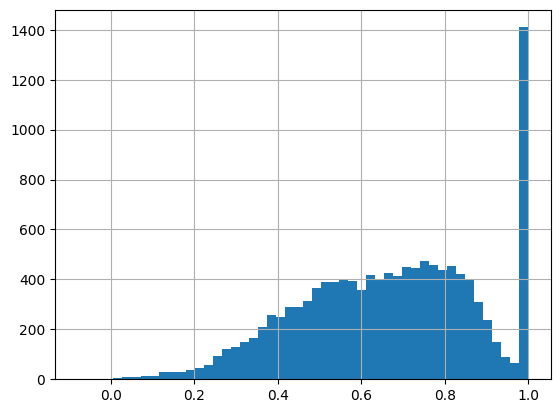

In [103]:
df.similarity.hist(bins=50)

In [104]:
df['rel_len'] = log10(df.dutch_len/df.english_len)